# Starbucks Capstone Challenge

### Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Data Understanding

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


### Problem Statement / Metrics

I would like to build a classifier that predicts whether a customer will respond to an offer based on the customers demographics and the offers attributes.

### Metrics

I am using the accuracy and F1-score to assess the model. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of the model performance. For this situation, evaluating a model’s precision and recall provides the better insight to its performance. Hence the F1-score metric will be a good major as it is a weighted average of the precision and recall metrics.


In [145]:
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

In [146]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Preprocessing

### 1. Portfolio - contains offer ids and meta data about each offer (duration, type, etc.)

In [147]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [148]:
portfolio.shape

(10, 6)

In [149]:
# Check for null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [150]:
# Number of the unique offers
portfolio.id.nunique()

10

In [151]:
# Offers by type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

### Preprocessing Portfolio

In [152]:
# Change column ordering
portfolio = portfolio[["id", "difficulty", "reward", "duration", "offer_type", "channels"]]

In [153]:
# Change the name of the 'id' column to 'offerid'
portfolio.rename(columns={"id": "offerid"}, inplace = True)

#### Reference:
- Running get_dummies on several DataFrame columns
- https://stackoverflow.com/questions/24109779/running-get-dummies-on-several-dataframe-columns

In [154]:
# clean offer type
# One-Hot encode the 'offertype' column
offertype_df= pd.get_dummies(data=portfolio, columns=['offer_type'])

In [155]:
offertype_df= pd.get_dummies(portfolio['offer_type'])

In [156]:
offertype_df.head()

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0


#### Reference:
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
       
- Multilabelbinarizer allows you to encode multiple labels per instance. 
- To translate the resulting array, you could build a DataFrame with this array and the encoded classes    

In [157]:
# clean 'channels'
# One-Hot encode the 'channels' columns
# This will create 4 columns, 1 indicates that channel is used for the communication  

mlb = MultiLabelBinarizer()
mlb.fit(portfolio['channels'])
channels_df = pd.DataFrame(mlb.transform(portfolio['channels']), columns=mlb.classes_)

In [158]:
channels_df.head()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1


In [159]:
# Add the new columns to the root dataset. Concat joins all the 3 dataframes
portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

# Drop the "offertype" & "channels" column after transforming them 
portfolio = portfolio.drop(columns=['offer_type', 'channels'])

In [160]:
portfolio.head(10)

,offerid,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,7,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,2,10,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,2,7,0,1,0,1,1,0,1


In [161]:
portfolio.shape

(10, 11)

In [162]:
portfolio.describe()

,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,7.700000,4.200000,6.500000,0.400000,0.400000,0.200000,1.0,0.900000,0.600000,0.800000
std,5.831905,3.583915,2.321398,0.516398,0.516398,0.421637,0.0,0.316228,0.516398,0.421637
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,5.000000,2.000000,5.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000
50%,8.500000,4.000000,7.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000
75%,10.000000,5.000000,7.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000
max,20.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


### 2. Profile - demographic data for each customer

In [163]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [164]:
profile.shape

(17000, 5)

In [165]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


#### max(age) 118 does not look correct

<AxesSubplot:>

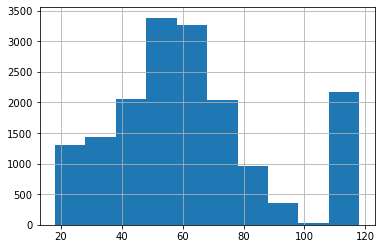

In [166]:
# Lets check what is the age distribution

profile.age.hist()

In [167]:
#check count of age=118 value and corresponding gender and income columns

print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


<AxesSubplot:>

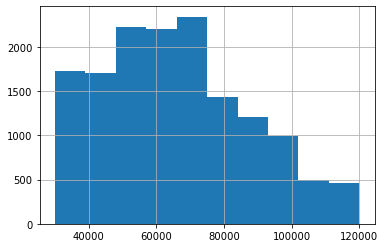

In [168]:
#check distributions of income
profile.income.hist()

<AxesSubplot:>

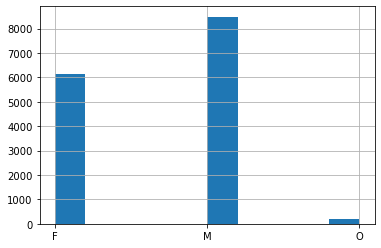

In [169]:
#check gender distributions
profile.gender.hist()

In [170]:
profile.isnull().sum()*100/len(profile)

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

 When gender has value None, the income is also unknown
 When gender and income are unknown, age is set to 118 for all the rows with NaN values.
 Missing values are roughly 12.79%. 

In [171]:
# Change column ordering
profile = profile[["id", "age", "gender", "income", "became_member_on"]]

In [172]:
# Change the name of the 'id' column to 'customerid'
profile.rename(columns={"id": "customerid"}, inplace = True)

#### References : 
 Use of lambda function to convert age 118 to N/A
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
- https://www.analyticsvidhya.com/blog/2020/03/what-are-lambda-functions-in-python/


 reset_index():- reset_index in pandas is used to reset index of the dataframe object to default indexing (0 to number of rows minus 1) or to reset multi level index.
- https://www.geeksforgeeks.org/python-pandas-dataframe-reset_index/

In [173]:
# Convert missing value encoded as 118 to N/A in the "age" column
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

In [174]:
# drop all missing values
profile = profile[profile['gender'] != 'O'] # Remove customers with unspecified gender

# Since we are deleting some rows, we need to re-index the rows. This can be achieved using reset_index() function
profile.dropna(inplace=True)
profile = profile.reset_index(drop=True)

Reference : Calculating number of days between two dates:
    
https://stackoverflow.com/questions/22132525/add-column-with-number-of-days-between-dates-in-dataframe-pandas
    

In [175]:
# Calculate the membership duration, which is number of days since the user is a member of starbucks
profile['membership_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
profile['membership_days'] = profile['membership_days'].dt.days
profile = profile.drop(columns=['became_member_on'])

In [176]:
# Perform Encoding on the "gender" column
profile["gender"] = profile["gender"].map({'M': 1, 'F': 0})

In [177]:
profile.head()

,customerid,age,gender,income,membership_days
0,0610b486422d4921ae7d2bf64640c50b,55.0,0,112000.0,1587
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,0,100000.0,1654
2,e2127556f4f64592b11af22de27a7932,68.0,1,70000.0,1302
3,389bc3fa690240e798340f5a15918d5c,65.0,1,53000.0,1378
4,2eeac8d8feae4a8cad5a6af0499a211d,58.0,1,51000.0,1468


In [178]:
profile.shape

(14613, 5)

In [179]:
profile.describe()

,age,gender,income,membership_days
count,14613.000000,14613.000000,14613.000000,14613.000000
mean,54.393417,0.580579,65435.707931,1733.991035
std,17.400201,0.493481,21633.524110,419.681797
min,18.000000,0.000000,30000.000000,1211.000000
25%,42.000000,0.000000,49000.000000,1419.000000
50%,55.000000,1.000000,64000.000000,1569.000000
75%,66.000000,1.000000,80000.000000,2009.000000
max,101.000000,1.000000,120000.000000,3034.000000


### 3. Transcript - records for transactions, offers received, offers viewed, and offers completed

Preprocessing of this dataset is very crucial for the analysis.
Depending on what business question one want to solve this dataset needs to be processed.

In [187]:
transcript.head(10)

,customerid,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
13,c27e0d6ab72c455a8bb66d980963de60,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
14,d53717f5400c4e84affdaeda9dd926b3,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
15,f806632c011441378d4646567f357a21,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0


In [188]:
transcript.shape

(268791, 4)

In [189]:
# Get a view of all the transactions/events type
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

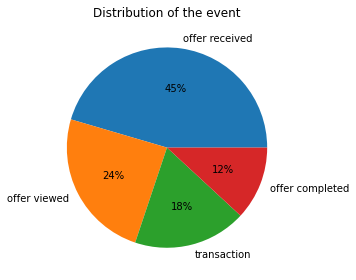

In [190]:
# percentage distribution of the events
plt.pie((transcript.event).value_counts(),labels=transcript['event'].unique(),autopct='%0.0f%%' )
plt.title('Distribution of the event')
plt.tight_layout()
plt.show(); 

#### Just filter based on 1 customerId to understand how the event data of each customer look like and which factors need to be addressed during the analysis

In [191]:
transcript[transcript['customerid']=='0009655768c64bdeb2e877511632db8f']

,customerid,event,value,time
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372
153401,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408
168412,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414
168413,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414
187554,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456
204340,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504


In [192]:
# Change the name of the 'person' column to 'customerid', 
# so that we can use 'customerid' as a joining key/primary key while merging the datasets 

transcript.rename(columns={"person": "customerid"}, inplace = True)

In [193]:
# To make dataset consistent and easy one-to-one mappping,delete the customer id's that are not in the customer 'profile' Dataset

transcript = transcript[transcript['customerid'].isin(profile['customerid'])]

For the transcript dataframe, we want to extract the values from column `value`. There are three values in that column which are `amount`, `offer_id`, and `reward`. 
Since my primary focus is on classifying success of offer, I will extract only offerid from 'value' and subsequently will drop 'value' column 

In [194]:
# Extract the offerid from the value column into a separate column
transcript['offerid'] = transcript['value'].apply(lambda x: list(x.values())[0])
transcript = transcript.drop(columns=['value'])

In [195]:
# Out of 4 events type, I'm interested only in the offer viewed and offer completed. 
# So I will keep only those events.
transcript = transcript[(transcript['event'] == "offer viewed") | (transcript['event'] == "offer completed")]

In [196]:
# Change column ordering consistent with other two datasets and also reset index as some rows were deleted in the above steps

transcript = transcript[["customerid", "offerid", "event", "time"]]

transcript = transcript.reset_index(drop=True)

- reset_index():-
- reset_index in pandas is used to reset index of the dataframe object to default indexing (0 to number of rows minus 1) or to reset multi level index.
- Reference : https://www.geeksforgeeks.org/python-pandas-dataframe-reset_index/

In [197]:
transcript.head(10)

,customerid,offerid,event,time
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,0
1,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed,0
2,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,offer viewed,0
3,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,offer viewed,0
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,offer viewed,0
5,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,offer completed,0
6,8c7df0c393db488aac3e58b06a7ea5f9,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,0
7,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,0
8,262ad0fb526a4d53b572007da60cce24,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,0
9,f8aedd0cbea0419c806842b4265b82e5,ae264e3637204a6fb9bb56bc8210ddfd,offer viewed,0


#### Preparing data for the classification

Here Starbucks has already classified transactions as offer viewed/completed. 
In the real world, one may need to consider transaction time and transaction type to determine the sequence and type of the transactions. 
Here I'm creating new variable/indicator 'response' as below:
- If a particular offer was viewed and then the offer was completed, then it's a success case and hence the value in the response column will be 1
- If a particular offer was only viewed and not completed, then the value in the response column should be 0 as offer was not successful.
In order to assign 1 and 0 correctly we need to maintain the sequence of the transactions; i) viewing the offer and then ii) completing the offer by each customerid. 
For that we will first group the transactions by 'customerid'


#### References:
- Conditional For loops:
- https://docs.python.org/3/tutorial/controlflow.html
- https://stackoverflow.com/questions/37009287/using-pandas-append-within-for-loop
- https://datatofish.com/if-condition-in-pandas-dataframe

In [198]:
transcript = transcript.groupby('customerid')

In [199]:
transcript.head()

,customerid,offerid,event,time
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,0
1,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,offer viewed,0
2,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,offer viewed,0
3,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,offer viewed,0
4,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,offer viewed,0
...,...,...,...,...
81016,0355c6a5fdbc429ea5b05e8a9ecd2eae,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,714
81020,9b51e8797290403b90d09d864dec4b94,3f207df678b143eea3cee63160fa8bed,offer viewed,714
81023,452cdae2c68e4732a4177d3929562690,fafdcd668e3743c1bb461111dcafc2a4,offer completed,714
81028,8431c16f8e1d440880db371a68f82dd0,fafdcd668e3743c1bb461111dcafc2a4,offer completed,714


In [200]:
cln_transcript = [] # create new cleaned dataset

for i in (list(transcript.groups)): # do the below steps for each customer
    data = transcript.get_group(i).drop_duplicates(subset=["offerid","event"])
    
    for value in data["offerid"].value_counts().items():
        if(value[1] == 1):
            condition = data["event"][list(data.loc[data['offerid']==value[0]].index)[0]] == "offer completed"
            if(condition == True):
                pass
            else:
                cln_transcript.append([i, value[0], 0])
        else:
            ev1 = data["event"][list(data.loc[data['offerid']==value[0]].index)[0]]
            ev2 = data["event"][list(data.loc[data['offerid']==value[0]].index)[1]]
            if((ev1 == 'offer viewed') & (ev2 == 'offer completed')):
                cln_transcript.append([i, value[0], 1])
            else:
                cln_transcript.append([i, value[0], 0])

In [201]:
transcript = pd.DataFrame(cln_transcript, columns =['customerid', 'offerid', 'response'])
transcript.head(10)

,customerid,offerid,response
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
5,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1
6,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,0
7,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1
8,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1
9,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1


In [202]:
transcript.shape

(41835, 3)

#### Final combined dataset is created by merging all the three datasets

In [203]:
final_dataset = pd.merge(pd.merge(profile, transcript, on='customerid'), portfolio, on='offerid')

#Drop customerid and offerid columns as we don't need them further
final_dataset = final_dataset.drop(columns=['customerid', 'offerid'])

# Cast dtype to integer for the numeric columns age and income using astype(int)
final_dataset[["age", "income"]] = final_dataset[["age", "income"]].astype(int)

In [204]:
final_dataset.head()

,age,gender,income,membership_days,response,difficulty,reward,duration,bogo,discount,informational,email,mobile,social,web
0,75,0,100000,1654,0,5,5,5,1,0,0,1,1,1,1
1,65,1,53000,1378,1,5,5,5,1,0,0,1,1,1,1
2,61,0,57000,1529,1,5,5,5,1,0,0,1,1,1,1
3,67,1,96000,2644,1,5,5,5,1,0,0,1,1,1,1
4,96,0,89000,1462,1,5,5,5,1,0,0,1,1,1,1


In [205]:
final_dataset.shape

(41835, 15)

### Prepare datasets for ML classifier

- Select the data where either bogo or discount offer is sent
- Create X : set of independant variables (regressors), which will be used to predict Y
- Create Y : dependant variable, in our case its 'response'
- Divide each dataset into test and train datasets using train_test_split(). Train dataset to train the model and test dataset for testing accuracy of the fitted model.


In [206]:
final_dataset_ml = final_dataset[(final_dataset["bogo"] == 1) | (final_dataset["discount"] == 1)]

In [207]:
X = final_dataset_ml[['age', 'gender', 'income', 'membership_days','difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web']].values
y = final_dataset_ml['response'].values

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

## 1. Random Forest Classifier


### Reference
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://chrisalbon.com/code/machine_learning/trees_and_forests/random_forest_classifier_example/

In [209]:
#Create a Gaussian Classifier
rf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

In [210]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6479516651930445
F1 Score: 0.7024536056794121


In [211]:
rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [150, 200, 250, 300]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 30,
                               cv = 3,
                               verbose = 2,
                               n_jobs = 3)

rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=3,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [150, 200, 250, 300]},
                   verbose=2)

### Evalaute Random Forest Model Performance

- References
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch
- https://scikit-learn.org/stable/modules/model_evaluation.html
- https://analyticsindiamag.com/guide-to-hyperparameters-tuning-using-gridsearchcv-and-randomizedsearchcv/

In [212]:
rf_random.best_estimator_

RandomForestClassifier(min_samples_leaf=4, min_samples_split=5,
                       n_estimators=300)

In [213]:
rf = RandomForestClassifier(n_estimators = 250, min_samples_split = 5, min_samples_leaf = 4,random_state = 4)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [214]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6662245800176835
F1 Score: 0.7215049797122832


### Vizualizing Important Features

#### Reference
-https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

Feature importances can give us insight into a problem by telling us what variables are the most discerning between classes.
Feature importances can be used for feature engineering by building additional features from the most important. We can also use feature importances for feature selection by removing low importance features.

In [265]:
# Extract feature importances

feature_imp = pd.DataFrame({'feature': ('age', 'gender', 'income', 'membership_days','difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web'),
                       'importance': rf.feature_importances_}).sort_values('importance', ascending=False)

feature_imp


,feature,importance
3,membership_days,0.423308
2,income,0.241618
0,age,0.216673
5,reward,0.045030
1,gender,0.026133
6,duration,0.019300
4,difficulty,0.011224
9,social,0.008687
10,web,0.006728
8,mobile,0.001298


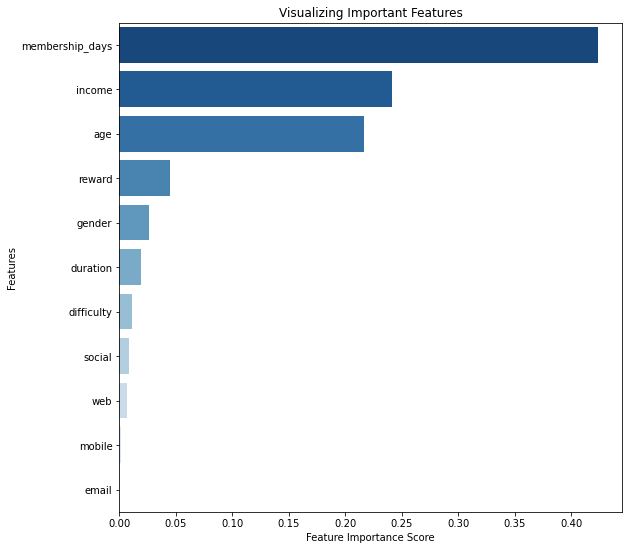

In [273]:
importance = pd.Series(rf.feature_importances_,index=['age', 'gender', 'income', 'membership_days',
                       'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web']).sort_values(ascending=False)

palette = sns.color_palette("Blues_r", importance.shape[0])
plt.figure(figsize=(9, 9))

sns.barplot(x=importance, y=importance.index, palette=palette)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## 2. Gradient Boosting Classifier

In [220]:
gb_clf = GradientBoostingClassifier()

# Create the random grid
random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}

gb_random = RandomizedSearchCV(estimator = gb_clf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   n_jobs = 3)

gb_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=3,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'loss': ['deviance', 'exponential'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 30, 50, 100, 150,
                                                         200, 250, 300]},
                   verbose=2)

### Evaluate Gradient Boosting Model Performance

In [221]:
gb_random.best_estimator_

GradientBoostingClassifier(min_samples_leaf=2, min_samples_split=5,
                           n_estimators=300)

In [222]:
gb = GradientBoostingClassifier(loss='exponential', n_estimators = 300, min_samples_split = 10, min_samples_leaf = 4, random_state = 4)
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)

In [223]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6802239905688181
F1 Score: 0.7345890410958903


## 3. CatBoost Classifier 

CatBoost is an algorithm for gradient boosting on decision trees. 
Catboost build one of the most accurate model on whatever dataset you feed it with — requiring minimal data prep.
It is a readymade classifier in scikit-learn’s conventions terms.
Though I have applied it on the cleaned and transformed dataset using one-hot encoding etc, Catboost would deal with the categorical features automatically and is scalable in nature.

#### References:

- https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html
- https://www.kaggle.com/prashant111/catboost-classifier-in-python
- https://medium.com/aiplusoau/hyperparameter-tuning-a5fe69d2a6c7

In [224]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [225]:
from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.5, 
    custom_loss=['AUC', 'Accuracy']
)

cb_clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=False,
        plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [226]:
print('CatBoost model is fitted: ' + str(cb_clf.is_fitted()))
print('CatBoost model parameters:')
print(cb_clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 50, 'learning_rate': 0.5, 'random_seed': 42, 'custom_loss': ['AUC', 'Accuracy']}


In [227]:
y_pred = cb_clf.predict(X_test)

In [228]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.6799292661361627
F1 Score: 0.7333660692364351


In [229]:
import numpy as np
from scipy.stats import randint
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

#Instantiate CatBoostClassifier
cbc = CatBoostClassifier()

# Creating the hyperparameter grid
param_dist = { 'learning_rate': np.linspace(0,0.2,5),
               'max_depth': randint(3, 10)}
               
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbc , param_dist, scoring='accuracy', cv =5)

#Fit the model
rscv.fit(X_train, y_train)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

0:	learn: 0.6856379	total: 56.2ms	remaining: 56.2s
1:	learn: 0.6790601	total: 59.3ms	remaining: 29.6s
2:	learn: 0.6729637	total: 61.9ms	remaining: 20.6s
3:	learn: 0.6676778	total: 64.3ms	remaining: 16s
4:	learn: 0.6626487	total: 67ms	remaining: 13.3s
5:	learn: 0.6582389	total: 69.7ms	remaining: 11.6s
6:	learn: 0.6549254	total: 72.4ms	remaining: 10.3s
7:	learn: 0.6511504	total: 75.2ms	remaining: 9.32s
8:	learn: 0.6475567	total: 78ms	remaining: 8.59s
9:	learn: 0.6446940	total: 80.8ms	remaining: 8s
10:	learn: 0.6422889	total: 83.7ms	remaining: 7.52s
11:	learn: 0.6399636	total: 86.1ms	remaining: 7.09s
12:	learn: 0.6376826	total: 89ms	remaining: 6.76s
13:	learn: 0.6354050	total: 91.7ms	remaining: 6.46s
14:	learn: 0.6335291	total: 94.3ms	remaining: 6.2s
15:	learn: 0.6316664	total: 97.3ms	remaining: 5.98s
16:	learn: 0.6298468	total: 100ms	remaining: 5.79s
17:	learn: 0.6282475	total: 103ms	remaining: 5.61s
18:	learn: 0.6267297	total: 106ms	remaining: 5.46s
19:	learn: 0.6253900	total: 108ms	rem

188:	learn: 0.5938723	total: 590ms	remaining: 2.53s
189:	learn: 0.5938236	total: 593ms	remaining: 2.53s
190:	learn: 0.5937762	total: 596ms	remaining: 2.52s
191:	learn: 0.5937397	total: 599ms	remaining: 2.52s
192:	learn: 0.5937180	total: 601ms	remaining: 2.52s
193:	learn: 0.5936912	total: 604ms	remaining: 2.51s
194:	learn: 0.5936759	total: 607ms	remaining: 2.51s
195:	learn: 0.5936514	total: 610ms	remaining: 2.5s
196:	learn: 0.5936308	total: 614ms	remaining: 2.5s
197:	learn: 0.5935878	total: 617ms	remaining: 2.5s
198:	learn: 0.5935359	total: 620ms	remaining: 2.5s
199:	learn: 0.5934876	total: 624ms	remaining: 2.49s
200:	learn: 0.5934523	total: 627ms	remaining: 2.49s
201:	learn: 0.5934081	total: 630ms	remaining: 2.49s
202:	learn: 0.5933334	total: 633ms	remaining: 2.48s
203:	learn: 0.5933193	total: 636ms	remaining: 2.48s
204:	learn: 0.5932609	total: 640ms	remaining: 2.48s
205:	learn: 0.5932338	total: 644ms	remaining: 2.48s
206:	learn: 0.5932073	total: 647ms	remaining: 2.48s
207:	learn: 0.59

368:	learn: 0.5883211	total: 1.13s	remaining: 1.93s
369:	learn: 0.5883134	total: 1.13s	remaining: 1.93s
370:	learn: 0.5883051	total: 1.14s	remaining: 1.92s
371:	learn: 0.5882897	total: 1.14s	remaining: 1.92s
372:	learn: 0.5882783	total: 1.14s	remaining: 1.92s
373:	learn: 0.5882465	total: 1.15s	remaining: 1.92s
374:	learn: 0.5882294	total: 1.15s	remaining: 1.91s
375:	learn: 0.5882053	total: 1.15s	remaining: 1.91s
376:	learn: 0.5881889	total: 1.15s	remaining: 1.91s
377:	learn: 0.5881560	total: 1.16s	remaining: 1.9s
378:	learn: 0.5881367	total: 1.16s	remaining: 1.9s
379:	learn: 0.5881011	total: 1.16s	remaining: 1.9s
380:	learn: 0.5880848	total: 1.17s	remaining: 1.9s
381:	learn: 0.5880580	total: 1.17s	remaining: 1.9s
382:	learn: 0.5880330	total: 1.17s	remaining: 1.89s
383:	learn: 0.5880034	total: 1.18s	remaining: 1.89s
384:	learn: 0.5879880	total: 1.18s	remaining: 1.89s
385:	learn: 0.5879552	total: 1.18s	remaining: 1.88s
386:	learn: 0.5879395	total: 1.19s	remaining: 1.88s
387:	learn: 0.587

537:	learn: 0.5847364	total: 1.66s	remaining: 1.43s
538:	learn: 0.5847101	total: 1.66s	remaining: 1.42s
539:	learn: 0.5846932	total: 1.67s	remaining: 1.42s
540:	learn: 0.5846725	total: 1.67s	remaining: 1.42s
541:	learn: 0.5846420	total: 1.67s	remaining: 1.41s
542:	learn: 0.5846263	total: 1.68s	remaining: 1.41s
543:	learn: 0.5846174	total: 1.68s	remaining: 1.41s
544:	learn: 0.5846013	total: 1.68s	remaining: 1.41s
545:	learn: 0.5845615	total: 1.69s	remaining: 1.4s
546:	learn: 0.5845368	total: 1.69s	remaining: 1.4s
547:	learn: 0.5845282	total: 1.7s	remaining: 1.4s
548:	learn: 0.5845049	total: 1.7s	remaining: 1.4s
549:	learn: 0.5844908	total: 1.7s	remaining: 1.39s
550:	learn: 0.5844684	total: 1.7s	remaining: 1.39s
551:	learn: 0.5844600	total: 1.71s	remaining: 1.39s
552:	learn: 0.5844519	total: 1.71s	remaining: 1.38s
553:	learn: 0.5844347	total: 1.71s	remaining: 1.38s
554:	learn: 0.5844052	total: 1.72s	remaining: 1.38s
555:	learn: 0.5843746	total: 1.72s	remaining: 1.37s
556:	learn: 0.584361

698:	learn: 0.5820305	total: 2.2s	remaining: 947ms
699:	learn: 0.5820134	total: 2.2s	remaining: 944ms
700:	learn: 0.5820098	total: 2.21s	remaining: 942ms
701:	learn: 0.5819953	total: 2.21s	remaining: 940ms
702:	learn: 0.5819920	total: 2.22s	remaining: 937ms
703:	learn: 0.5819712	total: 2.22s	remaining: 935ms
704:	learn: 0.5819515	total: 2.23s	remaining: 932ms
705:	learn: 0.5819367	total: 2.23s	remaining: 930ms
706:	learn: 0.5819210	total: 2.24s	remaining: 927ms
707:	learn: 0.5819080	total: 2.24s	remaining: 924ms
708:	learn: 0.5819033	total: 2.24s	remaining: 921ms
709:	learn: 0.5818801	total: 2.25s	remaining: 918ms
710:	learn: 0.5818607	total: 2.25s	remaining: 915ms
711:	learn: 0.5818493	total: 2.25s	remaining: 911ms
712:	learn: 0.5818320	total: 2.26s	remaining: 908ms
713:	learn: 0.5818152	total: 2.26s	remaining: 905ms
714:	learn: 0.5817964	total: 2.26s	remaining: 902ms
715:	learn: 0.5817843	total: 2.27s	remaining: 899ms
716:	learn: 0.5817699	total: 2.27s	remaining: 896ms
717:	learn: 0.

907:	learn: 0.5788233	total: 2.9s	remaining: 294ms
908:	learn: 0.5788062	total: 2.91s	remaining: 291ms
909:	learn: 0.5787882	total: 2.91s	remaining: 288ms
910:	learn: 0.5787656	total: 2.91s	remaining: 285ms
911:	learn: 0.5787404	total: 2.92s	remaining: 282ms
912:	learn: 0.5787265	total: 2.92s	remaining: 278ms
913:	learn: 0.5787135	total: 2.92s	remaining: 275ms
914:	learn: 0.5787091	total: 2.93s	remaining: 272ms
915:	learn: 0.5786898	total: 2.93s	remaining: 269ms
916:	learn: 0.5786705	total: 2.94s	remaining: 266ms
917:	learn: 0.5786641	total: 2.94s	remaining: 263ms
918:	learn: 0.5786444	total: 2.94s	remaining: 260ms
919:	learn: 0.5786226	total: 2.95s	remaining: 256ms
920:	learn: 0.5786162	total: 2.95s	remaining: 253ms
921:	learn: 0.5786140	total: 2.95s	remaining: 250ms
922:	learn: 0.5785888	total: 2.96s	remaining: 247ms
923:	learn: 0.5785622	total: 2.96s	remaining: 244ms
924:	learn: 0.5785473	total: 2.96s	remaining: 240ms
925:	learn: 0.5785369	total: 2.97s	remaining: 237ms
926:	learn: 0

106:	learn: 0.5949654	total: 357ms	remaining: 2.98s
107:	learn: 0.5948911	total: 361ms	remaining: 2.98s
108:	learn: 0.5948407	total: 366ms	remaining: 2.99s
109:	learn: 0.5947773	total: 369ms	remaining: 2.99s
110:	learn: 0.5947326	total: 372ms	remaining: 2.98s
111:	learn: 0.5946441	total: 376ms	remaining: 2.98s
112:	learn: 0.5946253	total: 379ms	remaining: 2.98s
113:	learn: 0.5945368	total: 382ms	remaining: 2.97s
114:	learn: 0.5944618	total: 385ms	remaining: 2.96s
115:	learn: 0.5944116	total: 388ms	remaining: 2.96s
116:	learn: 0.5943262	total: 392ms	remaining: 2.96s
117:	learn: 0.5942770	total: 397ms	remaining: 2.96s
118:	learn: 0.5941975	total: 400ms	remaining: 2.96s
119:	learn: 0.5941002	total: 403ms	remaining: 2.96s
120:	learn: 0.5940557	total: 408ms	remaining: 2.96s
121:	learn: 0.5939650	total: 413ms	remaining: 2.97s
122:	learn: 0.5939111	total: 417ms	remaining: 2.97s
123:	learn: 0.5938419	total: 424ms	remaining: 2.99s
124:	learn: 0.5937887	total: 429ms	remaining: 3s
125:	learn: 0.5

295:	learn: 0.5876340	total: 1.06s	remaining: 2.53s
296:	learn: 0.5876105	total: 1.06s	remaining: 2.52s
297:	learn: 0.5875746	total: 1.07s	remaining: 2.52s
298:	learn: 0.5875475	total: 1.07s	remaining: 2.51s
299:	learn: 0.5875152	total: 1.07s	remaining: 2.51s
300:	learn: 0.5874937	total: 1.08s	remaining: 2.5s
301:	learn: 0.5874434	total: 1.08s	remaining: 2.5s
302:	learn: 0.5874053	total: 1.08s	remaining: 2.5s
303:	learn: 0.5873854	total: 1.09s	remaining: 2.49s
304:	learn: 0.5873628	total: 1.09s	remaining: 2.49s
305:	learn: 0.5873432	total: 1.09s	remaining: 2.48s
306:	learn: 0.5873054	total: 1.1s	remaining: 2.48s
307:	learn: 0.5872917	total: 1.1s	remaining: 2.48s
308:	learn: 0.5872603	total: 1.1s	remaining: 2.47s
309:	learn: 0.5872232	total: 1.11s	remaining: 2.47s
310:	learn: 0.5871861	total: 1.11s	remaining: 2.46s
311:	learn: 0.5871583	total: 1.11s	remaining: 2.46s
312:	learn: 0.5871215	total: 1.12s	remaining: 2.45s
313:	learn: 0.5870975	total: 1.12s	remaining: 2.45s
314:	learn: 0.5870

508:	learn: 0.5823430	total: 1.77s	remaining: 1.71s
509:	learn: 0.5823302	total: 1.78s	remaining: 1.71s
510:	learn: 0.5823218	total: 1.78s	remaining: 1.71s
511:	learn: 0.5823180	total: 1.79s	remaining: 1.7s
512:	learn: 0.5822936	total: 1.79s	remaining: 1.7s
513:	learn: 0.5822619	total: 1.79s	remaining: 1.7s
514:	learn: 0.5822533	total: 1.8s	remaining: 1.69s
515:	learn: 0.5822320	total: 1.8s	remaining: 1.69s
516:	learn: 0.5822106	total: 1.8s	remaining: 1.69s
517:	learn: 0.5821663	total: 1.81s	remaining: 1.68s
518:	learn: 0.5821455	total: 1.81s	remaining: 1.68s
519:	learn: 0.5821118	total: 1.82s	remaining: 1.68s
520:	learn: 0.5820953	total: 1.82s	remaining: 1.68s
521:	learn: 0.5820786	total: 1.83s	remaining: 1.67s
522:	learn: 0.5820574	total: 1.83s	remaining: 1.67s
523:	learn: 0.5820374	total: 1.83s	remaining: 1.67s
524:	learn: 0.5820088	total: 1.84s	remaining: 1.67s
525:	learn: 0.5819906	total: 1.85s	remaining: 1.66s
526:	learn: 0.5819748	total: 1.85s	remaining: 1.66s
527:	learn: 0.5819

712:	learn: 0.5785449	total: 2.48s	remaining: 1s
713:	learn: 0.5785390	total: 2.49s	remaining: 997ms
714:	learn: 0.5785202	total: 2.49s	remaining: 993ms
715:	learn: 0.5784857	total: 2.49s	remaining: 989ms
716:	learn: 0.5784656	total: 2.5s	remaining: 986ms
717:	learn: 0.5784498	total: 2.5s	remaining: 982ms
718:	learn: 0.5784412	total: 2.5s	remaining: 979ms
719:	learn: 0.5784203	total: 2.51s	remaining: 975ms
720:	learn: 0.5784055	total: 2.51s	remaining: 971ms
721:	learn: 0.5783755	total: 2.51s	remaining: 968ms
722:	learn: 0.5783518	total: 2.52s	remaining: 964ms
723:	learn: 0.5783303	total: 2.52s	remaining: 961ms
724:	learn: 0.5783166	total: 2.52s	remaining: 957ms
725:	learn: 0.5782975	total: 2.52s	remaining: 953ms
726:	learn: 0.5782844	total: 2.53s	remaining: 950ms
727:	learn: 0.5782727	total: 2.53s	remaining: 946ms
728:	learn: 0.5782548	total: 2.54s	remaining: 943ms
729:	learn: 0.5782414	total: 2.54s	remaining: 940ms
730:	learn: 0.5782265	total: 2.54s	remaining: 936ms
731:	learn: 0.5782

884:	learn: 0.5757151	total: 3.02s	remaining: 392ms
885:	learn: 0.5757033	total: 3.02s	remaining: 389ms
886:	learn: 0.5756786	total: 3.02s	remaining: 385ms
887:	learn: 0.5756625	total: 3.03s	remaining: 382ms
888:	learn: 0.5756391	total: 3.03s	remaining: 378ms
889:	learn: 0.5756213	total: 3.03s	remaining: 375ms
890:	learn: 0.5756015	total: 3.04s	remaining: 372ms
891:	learn: 0.5755833	total: 3.04s	remaining: 368ms
892:	learn: 0.5755465	total: 3.04s	remaining: 365ms
893:	learn: 0.5755364	total: 3.05s	remaining: 361ms
894:	learn: 0.5755116	total: 3.05s	remaining: 358ms
895:	learn: 0.5754861	total: 3.05s	remaining: 354ms
896:	learn: 0.5754788	total: 3.06s	remaining: 351ms
897:	learn: 0.5754708	total: 3.06s	remaining: 348ms
898:	learn: 0.5754483	total: 3.06s	remaining: 344ms
899:	learn: 0.5754340	total: 3.07s	remaining: 341ms
900:	learn: 0.5754175	total: 3.07s	remaining: 337ms
901:	learn: 0.5754020	total: 3.07s	remaining: 334ms
902:	learn: 0.5753949	total: 3.07s	remaining: 330ms
903:	learn: 

66:	learn: 0.6010998	total: 185ms	remaining: 2.57s
67:	learn: 0.6008356	total: 188ms	remaining: 2.58s
68:	learn: 0.6007166	total: 191ms	remaining: 2.58s
69:	learn: 0.6005033	total: 194ms	remaining: 2.57s
70:	learn: 0.6003633	total: 197ms	remaining: 2.58s
71:	learn: 0.6001951	total: 200ms	remaining: 2.58s
72:	learn: 0.6000542	total: 204ms	remaining: 2.58s
73:	learn: 0.5999660	total: 206ms	remaining: 2.58s
74:	learn: 0.5998386	total: 209ms	remaining: 2.58s
75:	learn: 0.5997063	total: 212ms	remaining: 2.58s
76:	learn: 0.5995382	total: 216ms	remaining: 2.59s
77:	learn: 0.5994144	total: 220ms	remaining: 2.6s
78:	learn: 0.5992921	total: 222ms	remaining: 2.59s
79:	learn: 0.5992352	total: 225ms	remaining: 2.59s
80:	learn: 0.5990517	total: 228ms	remaining: 2.59s
81:	learn: 0.5988600	total: 231ms	remaining: 2.58s
82:	learn: 0.5987409	total: 233ms	remaining: 2.58s
83:	learn: 0.5985382	total: 236ms	remaining: 2.57s
84:	learn: 0.5983596	total: 239ms	remaining: 2.57s
85:	learn: 0.5982692	total: 241m

254:	learn: 0.5900416	total: 719ms	remaining: 2.1s
255:	learn: 0.5900117	total: 722ms	remaining: 2.1s
256:	learn: 0.5899569	total: 725ms	remaining: 2.1s
257:	learn: 0.5898949	total: 728ms	remaining: 2.09s
258:	learn: 0.5898572	total: 730ms	remaining: 2.09s
259:	learn: 0.5898280	total: 734ms	remaining: 2.09s
260:	learn: 0.5897782	total: 737ms	remaining: 2.08s
261:	learn: 0.5897442	total: 739ms	remaining: 2.08s
262:	learn: 0.5897309	total: 742ms	remaining: 2.08s
263:	learn: 0.5896938	total: 744ms	remaining: 2.08s
264:	learn: 0.5896777	total: 748ms	remaining: 2.07s
265:	learn: 0.5896294	total: 751ms	remaining: 2.07s
266:	learn: 0.5896136	total: 755ms	remaining: 2.07s
267:	learn: 0.5895875	total: 759ms	remaining: 2.07s
268:	learn: 0.5895686	total: 762ms	remaining: 2.07s
269:	learn: 0.5895297	total: 766ms	remaining: 2.07s
270:	learn: 0.5894827	total: 768ms	remaining: 2.07s
271:	learn: 0.5894592	total: 771ms	remaining: 2.06s
272:	learn: 0.5894036	total: 774ms	remaining: 2.06s
273:	learn: 0.5

438:	learn: 0.5848861	total: 1.25s	remaining: 1.6s
439:	learn: 0.5848523	total: 1.26s	remaining: 1.6s
440:	learn: 0.5848313	total: 1.26s	remaining: 1.6s
441:	learn: 0.5847983	total: 1.26s	remaining: 1.6s
442:	learn: 0.5847819	total: 1.27s	remaining: 1.6s
443:	learn: 0.5847476	total: 1.27s	remaining: 1.59s
444:	learn: 0.5847301	total: 1.28s	remaining: 1.59s
445:	learn: 0.5847186	total: 1.28s	remaining: 1.59s
446:	learn: 0.5846973	total: 1.28s	remaining: 1.59s
447:	learn: 0.5846716	total: 1.29s	remaining: 1.58s
448:	learn: 0.5846412	total: 1.29s	remaining: 1.58s
449:	learn: 0.5846305	total: 1.29s	remaining: 1.58s
450:	learn: 0.5846120	total: 1.3s	remaining: 1.58s
451:	learn: 0.5846020	total: 1.3s	remaining: 1.57s
452:	learn: 0.5845820	total: 1.3s	remaining: 1.57s
453:	learn: 0.5845618	total: 1.3s	remaining: 1.57s
454:	learn: 0.5845244	total: 1.31s	remaining: 1.57s
455:	learn: 0.5844955	total: 1.31s	remaining: 1.56s
456:	learn: 0.5844629	total: 1.31s	remaining: 1.56s
457:	learn: 0.5844470

617:	learn: 0.5811532	total: 1.86s	remaining: 1.15s
618:	learn: 0.5811342	total: 1.87s	remaining: 1.15s
619:	learn: 0.5811183	total: 1.87s	remaining: 1.15s
620:	learn: 0.5811034	total: 1.87s	remaining: 1.14s
621:	learn: 0.5810865	total: 1.88s	remaining: 1.14s
622:	learn: 0.5810620	total: 1.88s	remaining: 1.14s
623:	learn: 0.5810404	total: 1.88s	remaining: 1.13s
624:	learn: 0.5810256	total: 1.89s	remaining: 1.13s
625:	learn: 0.5810116	total: 1.89s	remaining: 1.13s
626:	learn: 0.5809913	total: 1.89s	remaining: 1.13s
627:	learn: 0.5809724	total: 1.9s	remaining: 1.12s
628:	learn: 0.5809572	total: 1.9s	remaining: 1.12s
629:	learn: 0.5809371	total: 1.9s	remaining: 1.12s
630:	learn: 0.5809209	total: 1.91s	remaining: 1.11s
631:	learn: 0.5809037	total: 1.91s	remaining: 1.11s
632:	learn: 0.5808951	total: 1.91s	remaining: 1.11s
633:	learn: 0.5808760	total: 1.92s	remaining: 1.1s
634:	learn: 0.5808579	total: 1.92s	remaining: 1.1s
635:	learn: 0.5808246	total: 1.92s	remaining: 1.1s
636:	learn: 0.5808

796:	learn: 0.5782341	total: 2.4s	remaining: 611ms
797:	learn: 0.5782186	total: 2.4s	remaining: 609ms
798:	learn: 0.5781854	total: 2.41s	remaining: 605ms
799:	learn: 0.5781744	total: 2.41s	remaining: 602ms
800:	learn: 0.5781557	total: 2.41s	remaining: 599ms
801:	learn: 0.5781290	total: 2.42s	remaining: 596ms
802:	learn: 0.5781130	total: 2.42s	remaining: 593ms
803:	learn: 0.5780938	total: 2.42s	remaining: 590ms
804:	learn: 0.5780749	total: 2.42s	remaining: 588ms
805:	learn: 0.5780584	total: 2.43s	remaining: 585ms
806:	learn: 0.5780347	total: 2.43s	remaining: 582ms
807:	learn: 0.5780247	total: 2.44s	remaining: 579ms
808:	learn: 0.5780118	total: 2.44s	remaining: 576ms
809:	learn: 0.5779838	total: 2.44s	remaining: 573ms
810:	learn: 0.5779761	total: 2.44s	remaining: 570ms
811:	learn: 0.5779584	total: 2.45s	remaining: 567ms
812:	learn: 0.5779245	total: 2.45s	remaining: 564ms
813:	learn: 0.5779163	total: 2.45s	remaining: 561ms
814:	learn: 0.5779042	total: 2.46s	remaining: 558ms
815:	learn: 0.

977:	learn: 0.5753245	total: 2.94s	remaining: 66ms
978:	learn: 0.5753154	total: 2.94s	remaining: 63.1ms
979:	learn: 0.5752930	total: 2.94s	remaining: 60ms
980:	learn: 0.5752802	total: 2.94s	remaining: 57ms
981:	learn: 0.5752640	total: 2.95s	remaining: 54ms
982:	learn: 0.5752542	total: 2.95s	remaining: 51ms
983:	learn: 0.5752447	total: 2.96s	remaining: 48ms
984:	learn: 0.5752241	total: 2.96s	remaining: 45ms
985:	learn: 0.5752102	total: 2.96s	remaining: 42ms
986:	learn: 0.5751938	total: 2.96s	remaining: 39ms
987:	learn: 0.5751699	total: 2.97s	remaining: 36.1ms
988:	learn: 0.5751522	total: 2.97s	remaining: 33.1ms
989:	learn: 0.5751185	total: 2.98s	remaining: 30.1ms
990:	learn: 0.5751044	total: 2.98s	remaining: 27ms
991:	learn: 0.5750851	total: 2.98s	remaining: 24ms
992:	learn: 0.5750760	total: 2.98s	remaining: 21ms
993:	learn: 0.5750594	total: 2.99s	remaining: 18ms
994:	learn: 0.5750548	total: 2.99s	remaining: 15ms
995:	learn: 0.5750322	total: 2.99s	remaining: 12ms
996:	learn: 0.5750051	t

197:	learn: 0.5926749	total: 539ms	remaining: 2.18s
198:	learn: 0.5926646	total: 542ms	remaining: 2.18s
199:	learn: 0.5926467	total: 545ms	remaining: 2.18s
200:	learn: 0.5926078	total: 548ms	remaining: 2.18s
201:	learn: 0.5925757	total: 551ms	remaining: 2.18s
202:	learn: 0.5925529	total: 554ms	remaining: 2.17s
203:	learn: 0.5925121	total: 556ms	remaining: 2.17s
204:	learn: 0.5925021	total: 560ms	remaining: 2.17s
205:	learn: 0.5924714	total: 563ms	remaining: 2.17s
206:	learn: 0.5924427	total: 566ms	remaining: 2.17s
207:	learn: 0.5924227	total: 569ms	remaining: 2.17s
208:	learn: 0.5923993	total: 572ms	remaining: 2.17s
209:	learn: 0.5923643	total: 575ms	remaining: 2.16s
210:	learn: 0.5923400	total: 578ms	remaining: 2.16s
211:	learn: 0.5923070	total: 582ms	remaining: 2.16s
212:	learn: 0.5922835	total: 586ms	remaining: 2.17s
213:	learn: 0.5922643	total: 590ms	remaining: 2.17s
214:	learn: 0.5922455	total: 593ms	remaining: 2.16s
215:	learn: 0.5922276	total: 596ms	remaining: 2.16s
216:	learn: 

376:	learn: 0.5872804	total: 1.07s	remaining: 1.78s
377:	learn: 0.5872456	total: 1.08s	remaining: 1.78s
378:	learn: 0.5872132	total: 1.08s	remaining: 1.77s
379:	learn: 0.5871769	total: 1.08s	remaining: 1.77s
380:	learn: 0.5871455	total: 1.09s	remaining: 1.77s
381:	learn: 0.5871248	total: 1.09s	remaining: 1.77s
382:	learn: 0.5871066	total: 1.09s	remaining: 1.76s
383:	learn: 0.5870801	total: 1.1s	remaining: 1.76s
384:	learn: 0.5870432	total: 1.1s	remaining: 1.76s
385:	learn: 0.5870166	total: 1.1s	remaining: 1.75s
386:	learn: 0.5869853	total: 1.11s	remaining: 1.75s
387:	learn: 0.5869516	total: 1.11s	remaining: 1.75s
388:	learn: 0.5869285	total: 1.11s	remaining: 1.75s
389:	learn: 0.5869070	total: 1.12s	remaining: 1.75s
390:	learn: 0.5868822	total: 1.12s	remaining: 1.75s
391:	learn: 0.5868631	total: 1.12s	remaining: 1.74s
392:	learn: 0.5868413	total: 1.13s	remaining: 1.74s
393:	learn: 0.5868226	total: 1.13s	remaining: 1.74s
394:	learn: 0.5867906	total: 1.13s	remaining: 1.74s
395:	learn: 0.5

555:	learn: 0.5834220	total: 1.61s	remaining: 1.29s
556:	learn: 0.5834164	total: 1.62s	remaining: 1.29s
557:	learn: 0.5834069	total: 1.62s	remaining: 1.28s
558:	learn: 0.5833902	total: 1.62s	remaining: 1.28s
559:	learn: 0.5833741	total: 1.64s	remaining: 1.29s
560:	learn: 0.5833532	total: 1.64s	remaining: 1.28s
561:	learn: 0.5833128	total: 1.65s	remaining: 1.28s
562:	learn: 0.5832828	total: 1.65s	remaining: 1.28s
563:	learn: 0.5832649	total: 1.66s	remaining: 1.28s
564:	learn: 0.5832427	total: 1.66s	remaining: 1.28s
565:	learn: 0.5832256	total: 1.66s	remaining: 1.28s
566:	learn: 0.5832103	total: 1.67s	remaining: 1.27s
567:	learn: 0.5832090	total: 1.67s	remaining: 1.27s
568:	learn: 0.5831676	total: 1.67s	remaining: 1.27s
569:	learn: 0.5831569	total: 1.68s	remaining: 1.26s
570:	learn: 0.5831339	total: 1.68s	remaining: 1.26s
571:	learn: 0.5831180	total: 1.68s	remaining: 1.26s
572:	learn: 0.5831072	total: 1.68s	remaining: 1.25s
573:	learn: 0.5830875	total: 1.69s	remaining: 1.25s
574:	learn: 

717:	learn: 0.5806053	total: 2.15s	remaining: 843ms
718:	learn: 0.5805823	total: 2.15s	remaining: 841ms
719:	learn: 0.5805652	total: 2.15s	remaining: 838ms
720:	learn: 0.5805425	total: 2.16s	remaining: 835ms
721:	learn: 0.5805040	total: 2.16s	remaining: 832ms
722:	learn: 0.5804925	total: 2.16s	remaining: 829ms
723:	learn: 0.5804713	total: 2.17s	remaining: 826ms
724:	learn: 0.5804613	total: 2.17s	remaining: 823ms
725:	learn: 0.5804361	total: 2.17s	remaining: 821ms
726:	learn: 0.5804128	total: 2.18s	remaining: 818ms
727:	learn: 0.5803949	total: 2.18s	remaining: 815ms
728:	learn: 0.5803816	total: 2.18s	remaining: 812ms
729:	learn: 0.5803669	total: 2.19s	remaining: 809ms
730:	learn: 0.5803625	total: 2.19s	remaining: 806ms
731:	learn: 0.5803405	total: 2.19s	remaining: 803ms
732:	learn: 0.5803291	total: 2.19s	remaining: 800ms
733:	learn: 0.5803222	total: 2.2s	remaining: 797ms
734:	learn: 0.5802955	total: 2.2s	remaining: 794ms
735:	learn: 0.5802776	total: 2.2s	remaining: 791ms
736:	learn: 0.5

898:	learn: 0.5775749	total: 2.69s	remaining: 302ms
899:	learn: 0.5775457	total: 2.69s	remaining: 299ms
900:	learn: 0.5775324	total: 2.69s	remaining: 296ms
901:	learn: 0.5775138	total: 2.69s	remaining: 293ms
902:	learn: 0.5775019	total: 2.7s	remaining: 290ms
903:	learn: 0.5774903	total: 2.7s	remaining: 287ms
904:	learn: 0.5774784	total: 2.7s	remaining: 284ms
905:	learn: 0.5774619	total: 2.71s	remaining: 281ms
906:	learn: 0.5774430	total: 2.71s	remaining: 278ms
907:	learn: 0.5774281	total: 2.71s	remaining: 275ms
908:	learn: 0.5774161	total: 2.72s	remaining: 272ms
909:	learn: 0.5774038	total: 2.72s	remaining: 269ms
910:	learn: 0.5773916	total: 2.72s	remaining: 266ms
911:	learn: 0.5773829	total: 2.73s	remaining: 263ms
912:	learn: 0.5773723	total: 2.73s	remaining: 260ms
913:	learn: 0.5773610	total: 2.73s	remaining: 257ms
914:	learn: 0.5773504	total: 2.73s	remaining: 254ms
915:	learn: 0.5773354	total: 2.74s	remaining: 251ms
916:	learn: 0.5773195	total: 2.74s	remaining: 248ms
917:	learn: 0.5

66:	learn: 0.6014165	total: 180ms	remaining: 2.51s
67:	learn: 0.6012350	total: 183ms	remaining: 2.51s
68:	learn: 0.6011135	total: 186ms	remaining: 2.51s
69:	learn: 0.6009655	total: 189ms	remaining: 2.52s
70:	learn: 0.6007998	total: 192ms	remaining: 2.51s
71:	learn: 0.6006813	total: 195ms	remaining: 2.52s
72:	learn: 0.6004958	total: 199ms	remaining: 2.52s
73:	learn: 0.6003618	total: 201ms	remaining: 2.52s
74:	learn: 0.6002050	total: 204ms	remaining: 2.52s
75:	learn: 0.6000233	total: 207ms	remaining: 2.52s
76:	learn: 0.5999206	total: 211ms	remaining: 2.53s
77:	learn: 0.5997485	total: 215ms	remaining: 2.54s
78:	learn: 0.5996954	total: 218ms	remaining: 2.54s
79:	learn: 0.5995455	total: 221ms	remaining: 2.54s
80:	learn: 0.5994252	total: 224ms	remaining: 2.54s
81:	learn: 0.5992816	total: 227ms	remaining: 2.54s
82:	learn: 0.5991321	total: 230ms	remaining: 2.54s
83:	learn: 0.5990332	total: 233ms	remaining: 2.54s
84:	learn: 0.5989336	total: 236ms	remaining: 2.54s
85:	learn: 0.5988422	total: 239

253:	learn: 0.5905111	total: 716ms	remaining: 2.1s
254:	learn: 0.5904444	total: 719ms	remaining: 2.1s
255:	learn: 0.5903954	total: 722ms	remaining: 2.1s
256:	learn: 0.5903475	total: 726ms	remaining: 2.1s
257:	learn: 0.5903252	total: 729ms	remaining: 2.1s
258:	learn: 0.5902824	total: 733ms	remaining: 2.1s
259:	learn: 0.5902603	total: 736ms	remaining: 2.1s
260:	learn: 0.5902227	total: 739ms	remaining: 2.09s
261:	learn: 0.5901872	total: 743ms	remaining: 2.09s
262:	learn: 0.5901589	total: 746ms	remaining: 2.09s
263:	learn: 0.5901167	total: 750ms	remaining: 2.09s
264:	learn: 0.5900509	total: 753ms	remaining: 2.09s
265:	learn: 0.5900089	total: 756ms	remaining: 2.08s
266:	learn: 0.5899683	total: 759ms	remaining: 2.08s
267:	learn: 0.5899428	total: 763ms	remaining: 2.08s
268:	learn: 0.5898844	total: 765ms	remaining: 2.08s
269:	learn: 0.5898566	total: 768ms	remaining: 2.08s
270:	learn: 0.5898235	total: 771ms	remaining: 2.07s
271:	learn: 0.5897921	total: 774ms	remaining: 2.07s
272:	learn: 0.58974

434:	learn: 0.5853867	total: 1.25s	remaining: 1.63s
435:	learn: 0.5853457	total: 1.25s	remaining: 1.62s
436:	learn: 0.5853116	total: 1.26s	remaining: 1.62s
437:	learn: 0.5852715	total: 1.26s	remaining: 1.62s
438:	learn: 0.5852497	total: 1.26s	remaining: 1.62s
439:	learn: 0.5852258	total: 1.27s	remaining: 1.61s
440:	learn: 0.5852072	total: 1.27s	remaining: 1.61s
441:	learn: 0.5851837	total: 1.27s	remaining: 1.61s
442:	learn: 0.5851765	total: 1.28s	remaining: 1.61s
443:	learn: 0.5851490	total: 1.28s	remaining: 1.6s
444:	learn: 0.5851246	total: 1.28s	remaining: 1.6s
445:	learn: 0.5851044	total: 1.29s	remaining: 1.6s
446:	learn: 0.5850874	total: 1.29s	remaining: 1.6s
447:	learn: 0.5850493	total: 1.29s	remaining: 1.59s
448:	learn: 0.5850370	total: 1.3s	remaining: 1.59s
449:	learn: 0.5850064	total: 1.3s	remaining: 1.59s
450:	learn: 0.5849876	total: 1.3s	remaining: 1.59s
451:	learn: 0.5849563	total: 1.3s	remaining: 1.58s
452:	learn: 0.5849403	total: 1.31s	remaining: 1.58s
453:	learn: 0.584917

610:	learn: 0.5815852	total: 1.79s	remaining: 1.14s
611:	learn: 0.5815625	total: 1.79s	remaining: 1.14s
612:	learn: 0.5815408	total: 1.79s	remaining: 1.13s
613:	learn: 0.5815181	total: 1.8s	remaining: 1.13s
614:	learn: 0.5815030	total: 1.8s	remaining: 1.13s
615:	learn: 0.5814902	total: 1.8s	remaining: 1.12s
616:	learn: 0.5814617	total: 1.81s	remaining: 1.12s
617:	learn: 0.5814441	total: 1.81s	remaining: 1.12s
618:	learn: 0.5814149	total: 1.81s	remaining: 1.12s
619:	learn: 0.5813894	total: 1.82s	remaining: 1.11s
620:	learn: 0.5813739	total: 1.82s	remaining: 1.11s
621:	learn: 0.5813533	total: 1.83s	remaining: 1.11s
622:	learn: 0.5813224	total: 1.83s	remaining: 1.11s
623:	learn: 0.5813049	total: 1.83s	remaining: 1.1s
624:	learn: 0.5812876	total: 1.84s	remaining: 1.1s
625:	learn: 0.5812667	total: 1.84s	remaining: 1.1s
626:	learn: 0.5812542	total: 1.84s	remaining: 1.1s
627:	learn: 0.5812352	total: 1.85s	remaining: 1.09s
628:	learn: 0.5812118	total: 1.85s	remaining: 1.09s
629:	learn: 0.58118

788:	learn: 0.5783208	total: 2.32s	remaining: 621ms
789:	learn: 0.5783040	total: 2.33s	remaining: 618ms
790:	learn: 0.5782798	total: 2.33s	remaining: 615ms
791:	learn: 0.5782613	total: 2.33s	remaining: 612ms
792:	learn: 0.5782401	total: 2.33s	remaining: 610ms
793:	learn: 0.5782270	total: 2.34s	remaining: 607ms
794:	learn: 0.5782097	total: 2.34s	remaining: 604ms
795:	learn: 0.5781920	total: 2.35s	remaining: 601ms
796:	learn: 0.5781775	total: 2.35s	remaining: 599ms
797:	learn: 0.5781632	total: 2.35s	remaining: 596ms
798:	learn: 0.5781528	total: 2.36s	remaining: 593ms
799:	learn: 0.5781387	total: 2.36s	remaining: 590ms
800:	learn: 0.5781195	total: 2.36s	remaining: 587ms
801:	learn: 0.5781040	total: 2.37s	remaining: 584ms
802:	learn: 0.5780857	total: 2.37s	remaining: 581ms
803:	learn: 0.5780689	total: 2.37s	remaining: 578ms
804:	learn: 0.5780615	total: 2.37s	remaining: 575ms
805:	learn: 0.5780455	total: 2.38s	remaining: 572ms
806:	learn: 0.5780285	total: 2.38s	remaining: 569ms
807:	learn: 

965:	learn: 0.5753407	total: 2.86s	remaining: 101ms
966:	learn: 0.5753226	total: 2.86s	remaining: 97.7ms
967:	learn: 0.5753004	total: 2.87s	remaining: 94.8ms
968:	learn: 0.5752800	total: 2.87s	remaining: 91.8ms
969:	learn: 0.5752625	total: 2.87s	remaining: 88.9ms
970:	learn: 0.5752401	total: 2.88s	remaining: 85.9ms
971:	learn: 0.5752179	total: 2.88s	remaining: 82.9ms
972:	learn: 0.5752106	total: 2.88s	remaining: 80ms
973:	learn: 0.5751951	total: 2.89s	remaining: 77.1ms
974:	learn: 0.5751758	total: 2.89s	remaining: 74.1ms
975:	learn: 0.5751561	total: 2.89s	remaining: 71.1ms
976:	learn: 0.5751437	total: 2.9s	remaining: 68.2ms
977:	learn: 0.5751276	total: 2.9s	remaining: 65.2ms
978:	learn: 0.5751161	total: 2.9s	remaining: 62.3ms
979:	learn: 0.5751095	total: 2.9s	remaining: 59.3ms
980:	learn: 0.5750885	total: 2.91s	remaining: 56.3ms
981:	learn: 0.5750689	total: 2.91s	remaining: 53.4ms
982:	learn: 0.5750549	total: 2.91s	remaining: 50.4ms
983:	learn: 0.5750414	total: 2.92s	remaining: 47.4ms


126:	learn: 0.5647357	total: 1.39s	remaining: 9.52s
127:	learn: 0.5645408	total: 1.4s	remaining: 9.51s
128:	learn: 0.5642985	total: 1.41s	remaining: 9.52s
129:	learn: 0.5642488	total: 1.42s	remaining: 9.48s
130:	learn: 0.5641147	total: 1.43s	remaining: 9.46s
131:	learn: 0.5639600	total: 1.44s	remaining: 9.45s
132:	learn: 0.5638385	total: 1.45s	remaining: 9.44s
133:	learn: 0.5636611	total: 1.46s	remaining: 9.43s
134:	learn: 0.5636545	total: 1.46s	remaining: 9.37s
135:	learn: 0.5634704	total: 1.47s	remaining: 9.36s
136:	learn: 0.5633167	total: 1.48s	remaining: 9.35s
137:	learn: 0.5631043	total: 1.5s	remaining: 9.34s
138:	learn: 0.5628815	total: 1.51s	remaining: 9.33s
139:	learn: 0.5626374	total: 1.52s	remaining: 9.32s
140:	learn: 0.5623674	total: 1.53s	remaining: 9.31s
141:	learn: 0.5621809	total: 1.54s	remaining: 9.3s
142:	learn: 0.5619427	total: 1.55s	remaining: 9.29s
143:	learn: 0.5617654	total: 1.56s	remaining: 9.28s
144:	learn: 0.5617493	total: 1.56s	remaining: 9.23s
145:	learn: 0.5

285:	learn: 0.5323116	total: 3.11s	remaining: 7.77s
286:	learn: 0.5322170	total: 3.12s	remaining: 7.76s
287:	learn: 0.5320715	total: 3.14s	remaining: 7.76s
288:	learn: 0.5318298	total: 3.15s	remaining: 7.75s
289:	learn: 0.5316318	total: 3.16s	remaining: 7.74s
290:	learn: 0.5313667	total: 3.17s	remaining: 7.72s
291:	learn: 0.5310943	total: 3.18s	remaining: 7.72s
292:	learn: 0.5308725	total: 3.19s	remaining: 7.71s
293:	learn: 0.5306905	total: 3.2s	remaining: 7.69s
294:	learn: 0.5304680	total: 3.21s	remaining: 7.68s
295:	learn: 0.5303099	total: 3.23s	remaining: 7.67s
296:	learn: 0.5300581	total: 3.24s	remaining: 7.66s
297:	learn: 0.5298936	total: 3.25s	remaining: 7.65s
298:	learn: 0.5297139	total: 3.26s	remaining: 7.64s
299:	learn: 0.5295340	total: 3.27s	remaining: 7.63s
300:	learn: 0.5292779	total: 3.28s	remaining: 7.62s
301:	learn: 0.5290296	total: 3.29s	remaining: 7.61s
302:	learn: 0.5288417	total: 3.3s	remaining: 7.6s
303:	learn: 0.5286332	total: 3.31s	remaining: 7.59s
304:	learn: 0.5

460:	learn: 0.4998132	total: 5.06s	remaining: 5.91s
461:	learn: 0.4996766	total: 5.07s	remaining: 5.9s
462:	learn: 0.4994742	total: 5.08s	remaining: 5.89s
463:	learn: 0.4993389	total: 5.09s	remaining: 5.88s
464:	learn: 0.4991070	total: 5.1s	remaining: 5.87s
465:	learn: 0.4988969	total: 5.12s	remaining: 5.86s
466:	learn: 0.4987970	total: 5.13s	remaining: 5.85s
467:	learn: 0.4986439	total: 5.14s	remaining: 5.84s
468:	learn: 0.4985249	total: 5.15s	remaining: 5.83s
469:	learn: 0.4984216	total: 5.16s	remaining: 5.82s
470:	learn: 0.4981654	total: 5.17s	remaining: 5.81s
471:	learn: 0.4980227	total: 5.18s	remaining: 5.79s
472:	learn: 0.4977704	total: 5.19s	remaining: 5.78s
473:	learn: 0.4976540	total: 5.2s	remaining: 5.77s
474:	learn: 0.4975534	total: 5.21s	remaining: 5.76s
475:	learn: 0.4973871	total: 5.22s	remaining: 5.75s
476:	learn: 0.4972385	total: 5.24s	remaining: 5.74s
477:	learn: 0.4971017	total: 5.25s	remaining: 5.73s
478:	learn: 0.4969808	total: 5.26s	remaining: 5.72s
479:	learn: 0.4

637:	learn: 0.4707715	total: 7.02s	remaining: 3.98s
638:	learn: 0.4706861	total: 7.03s	remaining: 3.97s
639:	learn: 0.4705850	total: 7.05s	remaining: 3.96s
640:	learn: 0.4704869	total: 7.06s	remaining: 3.95s
641:	learn: 0.4702392	total: 7.07s	remaining: 3.94s
642:	learn: 0.4700981	total: 7.08s	remaining: 3.93s
643:	learn: 0.4699254	total: 7.09s	remaining: 3.92s
644:	learn: 0.4697354	total: 7.1s	remaining: 3.91s
645:	learn: 0.4696229	total: 7.11s	remaining: 3.9s
646:	learn: 0.4695334	total: 7.12s	remaining: 3.89s
647:	learn: 0.4694109	total: 7.13s	remaining: 3.88s
648:	learn: 0.4692678	total: 7.14s	remaining: 3.86s
649:	learn: 0.4691158	total: 7.16s	remaining: 3.85s
650:	learn: 0.4690119	total: 7.17s	remaining: 3.84s
651:	learn: 0.4689469	total: 7.18s	remaining: 3.83s
652:	learn: 0.4687722	total: 7.19s	remaining: 3.82s
653:	learn: 0.4686586	total: 7.2s	remaining: 3.81s
654:	learn: 0.4685057	total: 7.21s	remaining: 3.8s
655:	learn: 0.4684003	total: 7.22s	remaining: 3.79s
656:	learn: 0.46

798:	learn: 0.4482316	total: 8.81s	remaining: 2.22s
799:	learn: 0.4480911	total: 8.82s	remaining: 2.21s
800:	learn: 0.4479866	total: 8.84s	remaining: 2.19s
801:	learn: 0.4479059	total: 8.85s	remaining: 2.18s
802:	learn: 0.4477528	total: 8.86s	remaining: 2.17s
803:	learn: 0.4475474	total: 8.87s	remaining: 2.16s
804:	learn: 0.4474668	total: 8.88s	remaining: 2.15s
805:	learn: 0.4473123	total: 8.89s	remaining: 2.14s
806:	learn: 0.4472147	total: 8.9s	remaining: 2.13s
807:	learn: 0.4471335	total: 8.91s	remaining: 2.12s
808:	learn: 0.4469956	total: 8.92s	remaining: 2.11s
809:	learn: 0.4468869	total: 8.93s	remaining: 2.1s
810:	learn: 0.4467581	total: 8.95s	remaining: 2.08s
811:	learn: 0.4466415	total: 8.96s	remaining: 2.07s
812:	learn: 0.4465152	total: 8.97s	remaining: 2.06s
813:	learn: 0.4463562	total: 8.98s	remaining: 2.05s
814:	learn: 0.4462356	total: 8.99s	remaining: 2.04s
815:	learn: 0.4460859	total: 9s	remaining: 2.03s
816:	learn: 0.4459162	total: 9.01s	remaining: 2.02s
817:	learn: 0.445

958:	learn: 0.4273326	total: 10.6s	remaining: 452ms
959:	learn: 0.4271654	total: 10.6s	remaining: 441ms
960:	learn: 0.4270517	total: 10.6s	remaining: 430ms
961:	learn: 0.4269095	total: 10.6s	remaining: 419ms
962:	learn: 0.4267370	total: 10.6s	remaining: 408ms
963:	learn: 0.4266451	total: 10.6s	remaining: 397ms
964:	learn: 0.4265516	total: 10.6s	remaining: 386ms
965:	learn: 0.4263734	total: 10.7s	remaining: 375ms
966:	learn: 0.4262822	total: 10.7s	remaining: 364ms
967:	learn: 0.4261968	total: 10.7s	remaining: 353ms
968:	learn: 0.4261037	total: 10.7s	remaining: 342ms
969:	learn: 0.4259762	total: 10.7s	remaining: 331ms
970:	learn: 0.4258448	total: 10.7s	remaining: 320ms
971:	learn: 0.4257209	total: 10.7s	remaining: 309ms
972:	learn: 0.4255973	total: 10.7s	remaining: 298ms
973:	learn: 0.4254593	total: 10.7s	remaining: 287ms
974:	learn: 0.4252970	total: 10.8s	remaining: 276ms
975:	learn: 0.4251656	total: 10.8s	remaining: 265ms
976:	learn: 0.4250185	total: 10.8s	remaining: 254ms
977:	learn: 

135:	learn: 0.5613832	total: 1.4s	remaining: 8.87s
136:	learn: 0.5611812	total: 1.41s	remaining: 8.87s
137:	learn: 0.5610439	total: 1.42s	remaining: 8.87s
138:	learn: 0.5608344	total: 1.43s	remaining: 8.87s
139:	learn: 0.5605196	total: 1.44s	remaining: 8.86s
140:	learn: 0.5602903	total: 1.45s	remaining: 8.86s
141:	learn: 0.5599655	total: 1.46s	remaining: 8.85s
142:	learn: 0.5598290	total: 1.47s	remaining: 8.84s
143:	learn: 0.5595490	total: 1.49s	remaining: 8.83s
144:	learn: 0.5593891	total: 1.5s	remaining: 8.82s
145:	learn: 0.5591069	total: 1.51s	remaining: 8.82s
146:	learn: 0.5590255	total: 1.52s	remaining: 8.81s
147:	learn: 0.5588636	total: 1.53s	remaining: 8.8s
148:	learn: 0.5585119	total: 1.54s	remaining: 8.8s
149:	learn: 0.5585076	total: 1.54s	remaining: 8.75s
150:	learn: 0.5581842	total: 1.55s	remaining: 8.74s
151:	learn: 0.5579277	total: 1.56s	remaining: 8.74s
152:	learn: 0.5576420	total: 1.58s	remaining: 8.73s
153:	learn: 0.5574699	total: 1.59s	remaining: 8.73s
154:	learn: 0.55

299:	learn: 0.5262747	total: 3.24s	remaining: 7.56s
300:	learn: 0.5260437	total: 3.25s	remaining: 7.55s
301:	learn: 0.5257813	total: 3.26s	remaining: 7.54s
302:	learn: 0.5256288	total: 3.27s	remaining: 7.53s
303:	learn: 0.5252951	total: 3.29s	remaining: 7.52s
304:	learn: 0.5250550	total: 3.3s	remaining: 7.51s
305:	learn: 0.5248012	total: 3.31s	remaining: 7.5s
306:	learn: 0.5245645	total: 3.32s	remaining: 7.49s
307:	learn: 0.5243542	total: 3.33s	remaining: 7.48s
308:	learn: 0.5240951	total: 3.34s	remaining: 7.47s
309:	learn: 0.5238528	total: 3.35s	remaining: 7.46s
310:	learn: 0.5236827	total: 3.36s	remaining: 7.45s
311:	learn: 0.5234793	total: 3.37s	remaining: 7.44s
312:	learn: 0.5232364	total: 3.38s	remaining: 7.42s
313:	learn: 0.5229921	total: 3.39s	remaining: 7.41s
314:	learn: 0.5227757	total: 3.4s	remaining: 7.4s
315:	learn: 0.5226167	total: 3.42s	remaining: 7.39s
316:	learn: 0.5224329	total: 3.43s	remaining: 7.38s
317:	learn: 0.5222776	total: 3.44s	remaining: 7.37s
318:	learn: 0.52

459:	learn: 0.4954721	total: 5.01s	remaining: 5.89s
460:	learn: 0.4953150	total: 5.03s	remaining: 5.88s
461:	learn: 0.4952350	total: 5.04s	remaining: 5.87s
462:	learn: 0.4950461	total: 5.05s	remaining: 5.86s
463:	learn: 0.4948724	total: 5.06s	remaining: 5.84s
464:	learn: 0.4947496	total: 5.07s	remaining: 5.83s
465:	learn: 0.4946033	total: 5.08s	remaining: 5.82s
466:	learn: 0.4944518	total: 5.09s	remaining: 5.81s
467:	learn: 0.4942387	total: 5.1s	remaining: 5.8s
468:	learn: 0.4940070	total: 5.11s	remaining: 5.79s
469:	learn: 0.4937560	total: 5.13s	remaining: 5.78s
470:	learn: 0.4934783	total: 5.14s	remaining: 5.77s
471:	learn: 0.4933813	total: 5.15s	remaining: 5.76s
472:	learn: 0.4932297	total: 5.16s	remaining: 5.75s
473:	learn: 0.4930048	total: 5.17s	remaining: 5.74s
474:	learn: 0.4928825	total: 5.18s	remaining: 5.72s
475:	learn: 0.4927455	total: 5.19s	remaining: 5.71s
476:	learn: 0.4925657	total: 5.2s	remaining: 5.7s
477:	learn: 0.4923000	total: 5.21s	remaining: 5.69s
478:	learn: 0.49

631:	learn: 0.4667339	total: 6.96s	remaining: 4.05s
632:	learn: 0.4665825	total: 6.98s	remaining: 4.04s
633:	learn: 0.4663693	total: 6.99s	remaining: 4.04s
634:	learn: 0.4662245	total: 7s	remaining: 4.02s
635:	learn: 0.4660774	total: 7.01s	remaining: 4.01s
636:	learn: 0.4659281	total: 7.02s	remaining: 4s
637:	learn: 0.4658536	total: 7.03s	remaining: 3.99s
638:	learn: 0.4657180	total: 7.04s	remaining: 3.98s
639:	learn: 0.4655934	total: 7.05s	remaining: 3.97s
640:	learn: 0.4655316	total: 7.07s	remaining: 3.96s
641:	learn: 0.4653687	total: 7.08s	remaining: 3.94s
642:	learn: 0.4651760	total: 7.09s	remaining: 3.93s
643:	learn: 0.4650937	total: 7.1s	remaining: 3.92s
644:	learn: 0.4649843	total: 7.11s	remaining: 3.91s
645:	learn: 0.4648105	total: 7.12s	remaining: 3.9s
646:	learn: 0.4646603	total: 7.13s	remaining: 3.89s
647:	learn: 0.4645312	total: 7.14s	remaining: 3.88s
648:	learn: 0.4643630	total: 7.15s	remaining: 3.87s
649:	learn: 0.4642524	total: 7.16s	remaining: 3.86s
650:	learn: 0.464090

790:	learn: 0.4437759	total: 8.74s	remaining: 2.31s
791:	learn: 0.4436295	total: 8.76s	remaining: 2.3s
792:	learn: 0.4434224	total: 8.77s	remaining: 2.29s
793:	learn: 0.4432654	total: 8.78s	remaining: 2.28s
794:	learn: 0.4431162	total: 8.79s	remaining: 2.27s
795:	learn: 0.4430269	total: 8.8s	remaining: 2.25s
796:	learn: 0.4428821	total: 8.81s	remaining: 2.24s
797:	learn: 0.4427602	total: 8.82s	remaining: 2.23s
798:	learn: 0.4426229	total: 8.83s	remaining: 2.22s
799:	learn: 0.4425221	total: 8.84s	remaining: 2.21s
800:	learn: 0.4423252	total: 8.85s	remaining: 2.2s
801:	learn: 0.4422116	total: 8.87s	remaining: 2.19s
802:	learn: 0.4420697	total: 8.88s	remaining: 2.18s
803:	learn: 0.4418693	total: 8.89s	remaining: 2.17s
804:	learn: 0.4417021	total: 8.9s	remaining: 2.15s
805:	learn: 0.4415583	total: 8.91s	remaining: 2.14s
806:	learn: 0.4414175	total: 8.92s	remaining: 2.13s
807:	learn: 0.4412560	total: 8.93s	remaining: 2.12s
808:	learn: 0.4411136	total: 8.94s	remaining: 2.11s
809:	learn: 0.44

952:	learn: 0.4224111	total: 10.5s	remaining: 520ms
953:	learn: 0.4222908	total: 10.5s	remaining: 509ms
954:	learn: 0.4221864	total: 10.6s	remaining: 497ms
955:	learn: 0.4221212	total: 10.6s	remaining: 487ms
956:	learn: 0.4219880	total: 10.6s	remaining: 475ms
957:	learn: 0.4218927	total: 10.6s	remaining: 464ms
958:	learn: 0.4217465	total: 10.6s	remaining: 453ms
959:	learn: 0.4216346	total: 10.6s	remaining: 442ms
960:	learn: 0.4215499	total: 10.6s	remaining: 431ms
961:	learn: 0.4214375	total: 10.6s	remaining: 420ms
962:	learn: 0.4212455	total: 10.6s	remaining: 409ms
963:	learn: 0.4211282	total: 10.7s	remaining: 398ms
964:	learn: 0.4210009	total: 10.7s	remaining: 387ms
965:	learn: 0.4208903	total: 10.7s	remaining: 376ms
966:	learn: 0.4207493	total: 10.7s	remaining: 365ms
967:	learn: 0.4205287	total: 10.7s	remaining: 354ms
968:	learn: 0.4203968	total: 10.7s	remaining: 343ms
969:	learn: 0.4202426	total: 10.7s	remaining: 332ms
970:	learn: 0.4201272	total: 10.7s	remaining: 321ms
971:	learn: 

129:	learn: 0.5639601	total: 1.37s	remaining: 9.15s
130:	learn: 0.5638102	total: 1.38s	remaining: 9.14s
131:	learn: 0.5637290	total: 1.38s	remaining: 9.1s
132:	learn: 0.5634717	total: 1.4s	remaining: 9.11s
133:	learn: 0.5631342	total: 1.41s	remaining: 9.1s
134:	learn: 0.5629539	total: 1.42s	remaining: 9.1s
135:	learn: 0.5627640	total: 1.43s	remaining: 9.09s
136:	learn: 0.5627640	total: 1.43s	remaining: 9.03s
137:	learn: 0.5625852	total: 1.44s	remaining: 9.02s
138:	learn: 0.5623562	total: 1.45s	remaining: 9.01s
139:	learn: 0.5623061	total: 1.46s	remaining: 8.97s
140:	learn: 0.5620286	total: 1.47s	remaining: 8.96s
141:	learn: 0.5619019	total: 1.48s	remaining: 8.95s
142:	learn: 0.5616289	total: 1.49s	remaining: 8.95s
143:	learn: 0.5616289	total: 1.5s	remaining: 8.89s
144:	learn: 0.5614593	total: 1.51s	remaining: 8.88s
145:	learn: 0.5612101	total: 1.52s	remaining: 8.87s
146:	learn: 0.5610634	total: 1.53s	remaining: 8.87s
147:	learn: 0.5609325	total: 1.54s	remaining: 8.86s
148:	learn: 0.560

290:	learn: 0.5307391	total: 3.14s	remaining: 7.66s
291:	learn: 0.5304382	total: 3.16s	remaining: 7.66s
292:	learn: 0.5302960	total: 3.17s	remaining: 7.65s
293:	learn: 0.5300286	total: 3.18s	remaining: 7.64s
294:	learn: 0.5297618	total: 3.19s	remaining: 7.63s
295:	learn: 0.5295637	total: 3.21s	remaining: 7.62s
296:	learn: 0.5292060	total: 3.22s	remaining: 7.61s
297:	learn: 0.5290089	total: 3.23s	remaining: 7.6s
298:	learn: 0.5288192	total: 3.24s	remaining: 7.59s
299:	learn: 0.5285808	total: 3.25s	remaining: 7.58s
300:	learn: 0.5284531	total: 3.26s	remaining: 7.57s
301:	learn: 0.5282797	total: 3.27s	remaining: 7.56s
302:	learn: 0.5280675	total: 3.28s	remaining: 7.55s
303:	learn: 0.5278284	total: 3.29s	remaining: 7.54s
304:	learn: 0.5275957	total: 3.31s	remaining: 7.53s
305:	learn: 0.5274655	total: 3.32s	remaining: 7.52s
306:	learn: 0.5273513	total: 3.33s	remaining: 7.51s
307:	learn: 0.5271234	total: 3.34s	remaining: 7.51s
308:	learn: 0.5268721	total: 3.35s	remaining: 7.5s
309:	learn: 0.

450:	learn: 0.5009207	total: 4.96s	remaining: 6.03s
451:	learn: 0.5007894	total: 4.97s	remaining: 6.02s
452:	learn: 0.5005938	total: 4.98s	remaining: 6.01s
453:	learn: 0.5004078	total: 4.99s	remaining: 6s
454:	learn: 0.5002051	total: 5s	remaining: 5.99s
455:	learn: 0.5000926	total: 5.01s	remaining: 5.98s
456:	learn: 0.4999217	total: 5.02s	remaining: 5.97s
457:	learn: 0.4997445	total: 5.03s	remaining: 5.96s
458:	learn: 0.4996172	total: 5.04s	remaining: 5.95s
459:	learn: 0.4994592	total: 5.05s	remaining: 5.93s
460:	learn: 0.4993467	total: 5.07s	remaining: 5.92s
461:	learn: 0.4991909	total: 5.08s	remaining: 5.91s
462:	learn: 0.4990861	total: 5.09s	remaining: 5.9s
463:	learn: 0.4989138	total: 5.1s	remaining: 5.89s
464:	learn: 0.4987280	total: 5.11s	remaining: 5.88s
465:	learn: 0.4986270	total: 5.12s	remaining: 5.87s
466:	learn: 0.4984289	total: 5.13s	remaining: 5.86s
467:	learn: 0.4982268	total: 5.14s	remaining: 5.84s
468:	learn: 0.4980917	total: 5.15s	remaining: 5.83s
469:	learn: 0.497955

611:	learn: 0.4748579	total: 6.73s	remaining: 4.27s
612:	learn: 0.4747039	total: 6.74s	remaining: 4.26s
613:	learn: 0.4745745	total: 6.75s	remaining: 4.25s
614:	learn: 0.4744625	total: 6.77s	remaining: 4.24s
615:	learn: 0.4742434	total: 6.78s	remaining: 4.22s
616:	learn: 0.4740895	total: 6.79s	remaining: 4.21s
617:	learn: 0.4740205	total: 6.8s	remaining: 4.2s
618:	learn: 0.4738235	total: 6.81s	remaining: 4.19s
619:	learn: 0.4736241	total: 6.82s	remaining: 4.18s
620:	learn: 0.4735145	total: 6.83s	remaining: 4.17s
621:	learn: 0.4733684	total: 6.84s	remaining: 4.16s
622:	learn: 0.4732531	total: 6.85s	remaining: 4.15s
623:	learn: 0.4730947	total: 6.86s	remaining: 4.13s
624:	learn: 0.4729543	total: 6.87s	remaining: 4.12s
625:	learn: 0.4727813	total: 6.88s	remaining: 4.11s
626:	learn: 0.4726470	total: 6.89s	remaining: 4.1s
627:	learn: 0.4725431	total: 6.91s	remaining: 4.09s
628:	learn: 0.4724567	total: 6.92s	remaining: 4.08s
629:	learn: 0.4723274	total: 6.93s	remaining: 4.07s
630:	learn: 0.4

771:	learn: 0.4512417	total: 8.56s	remaining: 2.53s
772:	learn: 0.4510568	total: 8.58s	remaining: 2.52s
773:	learn: 0.4509550	total: 8.59s	remaining: 2.51s
774:	learn: 0.4508008	total: 8.6s	remaining: 2.5s
775:	learn: 0.4506733	total: 8.61s	remaining: 2.48s
776:	learn: 0.4505545	total: 8.62s	remaining: 2.47s
777:	learn: 0.4503649	total: 8.63s	remaining: 2.46s
778:	learn: 0.4502635	total: 8.64s	remaining: 2.45s
779:	learn: 0.4501578	total: 8.65s	remaining: 2.44s
780:	learn: 0.4500232	total: 8.66s	remaining: 2.43s
781:	learn: 0.4499357	total: 8.67s	remaining: 2.42s
782:	learn: 0.4498322	total: 8.68s	remaining: 2.41s
783:	learn: 0.4496869	total: 8.69s	remaining: 2.4s
784:	learn: 0.4495440	total: 8.71s	remaining: 2.38s
785:	learn: 0.4494281	total: 8.71s	remaining: 2.37s
786:	learn: 0.4493352	total: 8.73s	remaining: 2.36s
787:	learn: 0.4491776	total: 8.74s	remaining: 2.35s
788:	learn: 0.4490482	total: 8.76s	remaining: 2.34s
789:	learn: 0.4489247	total: 8.79s	remaining: 2.34s
790:	learn: 0.4

945:	learn: 0.4283936	total: 10.6s	remaining: 605ms
946:	learn: 0.4283194	total: 10.6s	remaining: 593ms
947:	learn: 0.4281282	total: 10.6s	remaining: 582ms
948:	learn: 0.4280115	total: 10.6s	remaining: 571ms
949:	learn: 0.4279105	total: 10.6s	remaining: 560ms
950:	learn: 0.4277944	total: 10.6s	remaining: 549ms
951:	learn: 0.4276187	total: 10.7s	remaining: 537ms
952:	learn: 0.4274628	total: 10.7s	remaining: 526ms
953:	learn: 0.4272288	total: 10.7s	remaining: 515ms
954:	learn: 0.4271084	total: 10.7s	remaining: 504ms
955:	learn: 0.4269749	total: 10.7s	remaining: 493ms
956:	learn: 0.4268321	total: 10.7s	remaining: 481ms
957:	learn: 0.4267268	total: 10.7s	remaining: 470ms
958:	learn: 0.4265405	total: 10.7s	remaining: 459ms
959:	learn: 0.4264242	total: 10.7s	remaining: 448ms
960:	learn: 0.4262835	total: 10.8s	remaining: 437ms
961:	learn: 0.4261427	total: 10.8s	remaining: 425ms
962:	learn: 0.4259978	total: 10.8s	remaining: 414ms
963:	learn: 0.4258847	total: 10.8s	remaining: 403ms
964:	learn: 

123:	learn: 0.5654088	total: 1.38s	remaining: 9.72s
124:	learn: 0.5651841	total: 1.39s	remaining: 9.71s
125:	learn: 0.5649308	total: 1.4s	remaining: 9.73s
126:	learn: 0.5645746	total: 1.41s	remaining: 9.72s
127:	learn: 0.5644689	total: 1.43s	remaining: 9.72s
128:	learn: 0.5642788	total: 1.44s	remaining: 9.71s
129:	learn: 0.5641227	total: 1.45s	remaining: 9.7s
130:	learn: 0.5639047	total: 1.46s	remaining: 9.69s
131:	learn: 0.5638417	total: 1.47s	remaining: 9.64s
132:	learn: 0.5636913	total: 1.48s	remaining: 9.63s
133:	learn: 0.5634268	total: 1.49s	remaining: 9.62s
134:	learn: 0.5631916	total: 1.5s	remaining: 9.6s
135:	learn: 0.5630357	total: 1.51s	remaining: 9.59s
136:	learn: 0.5629047	total: 1.52s	remaining: 9.57s
137:	learn: 0.5626276	total: 1.53s	remaining: 9.56s
138:	learn: 0.5624340	total: 1.54s	remaining: 9.55s
139:	learn: 0.5621251	total: 1.55s	remaining: 9.54s
140:	learn: 0.5619335	total: 1.56s	remaining: 9.53s
141:	learn: 0.5617554	total: 1.57s	remaining: 9.52s
142:	learn: 0.56

296:	learn: 0.5297689	total: 3.31s	remaining: 7.83s
297:	learn: 0.5295788	total: 3.32s	remaining: 7.82s
298:	learn: 0.5292395	total: 3.33s	remaining: 7.82s
299:	learn: 0.5290348	total: 3.35s	remaining: 7.8s
300:	learn: 0.5287947	total: 3.36s	remaining: 7.79s
301:	learn: 0.5286054	total: 3.37s	remaining: 7.78s
302:	learn: 0.5284736	total: 3.38s	remaining: 7.77s
303:	learn: 0.5282620	total: 3.39s	remaining: 7.76s
304:	learn: 0.5280865	total: 3.4s	remaining: 7.75s
305:	learn: 0.5277758	total: 3.41s	remaining: 7.74s
306:	learn: 0.5275555	total: 3.42s	remaining: 7.73s
307:	learn: 0.5274007	total: 3.44s	remaining: 7.72s
308:	learn: 0.5271795	total: 3.45s	remaining: 7.71s
309:	learn: 0.5270199	total: 3.46s	remaining: 7.7s
310:	learn: 0.5267770	total: 3.47s	remaining: 7.68s
311:	learn: 0.5266544	total: 3.48s	remaining: 7.67s
312:	learn: 0.5264994	total: 3.49s	remaining: 7.66s
313:	learn: 0.5263332	total: 3.5s	remaining: 7.65s
314:	learn: 0.5260738	total: 3.51s	remaining: 7.64s
315:	learn: 0.52

455:	learn: 0.4992810	total: 5.09s	remaining: 6.07s
456:	learn: 0.4991703	total: 5.1s	remaining: 6.06s
457:	learn: 0.4990277	total: 5.11s	remaining: 6.05s
458:	learn: 0.4988934	total: 5.13s	remaining: 6.04s
459:	learn: 0.4985927	total: 5.14s	remaining: 6.03s
460:	learn: 0.4984231	total: 5.15s	remaining: 6.02s
461:	learn: 0.4982836	total: 5.16s	remaining: 6.01s
462:	learn: 0.4981266	total: 5.17s	remaining: 6s
463:	learn: 0.4979882	total: 5.18s	remaining: 5.98s
464:	learn: 0.4978174	total: 5.19s	remaining: 5.97s
465:	learn: 0.4976402	total: 5.2s	remaining: 5.96s
466:	learn: 0.4974935	total: 5.21s	remaining: 5.95s
467:	learn: 0.4972853	total: 5.22s	remaining: 5.94s
468:	learn: 0.4971308	total: 5.23s	remaining: 5.92s
469:	learn: 0.4970283	total: 5.24s	remaining: 5.91s
470:	learn: 0.4968887	total: 5.25s	remaining: 5.9s
471:	learn: 0.4967195	total: 5.26s	remaining: 5.89s
472:	learn: 0.4965653	total: 5.28s	remaining: 5.88s
473:	learn: 0.4963472	total: 5.29s	remaining: 5.87s
474:	learn: 0.4961

617:	learn: 0.4732482	total: 6.88s	remaining: 4.25s
618:	learn: 0.4731655	total: 6.89s	remaining: 4.24s
619:	learn: 0.4730641	total: 6.91s	remaining: 4.23s
620:	learn: 0.4729497	total: 6.92s	remaining: 4.22s
621:	learn: 0.4727525	total: 6.93s	remaining: 4.21s
622:	learn: 0.4726623	total: 6.94s	remaining: 4.2s
623:	learn: 0.4724776	total: 6.95s	remaining: 4.19s
624:	learn: 0.4722877	total: 6.96s	remaining: 4.18s
625:	learn: 0.4721823	total: 6.97s	remaining: 4.17s
626:	learn: 0.4720093	total: 7.02s	remaining: 4.17s
627:	learn: 0.4718520	total: 7.06s	remaining: 4.18s
628:	learn: 0.4717158	total: 7.08s	remaining: 4.18s
629:	learn: 0.4715794	total: 7.1s	remaining: 4.17s
630:	learn: 0.4714335	total: 7.11s	remaining: 4.16s
631:	learn: 0.4712995	total: 7.12s	remaining: 4.14s
632:	learn: 0.4711119	total: 7.13s	remaining: 4.13s
633:	learn: 0.4709081	total: 7.14s	remaining: 4.12s
634:	learn: 0.4707648	total: 7.15s	remaining: 4.11s
635:	learn: 0.4705398	total: 7.16s	remaining: 4.1s
636:	learn: 0.4

778:	learn: 0.4498344	total: 8.76s	remaining: 2.49s
779:	learn: 0.4496781	total: 8.77s	remaining: 2.47s
780:	learn: 0.4495140	total: 8.79s	remaining: 2.46s
781:	learn: 0.4493894	total: 8.8s	remaining: 2.45s
782:	learn: 0.4491999	total: 8.81s	remaining: 2.44s
783:	learn: 0.4490357	total: 8.82s	remaining: 2.43s
784:	learn: 0.4489179	total: 8.83s	remaining: 2.42s
785:	learn: 0.4487400	total: 8.84s	remaining: 2.41s
786:	learn: 0.4486421	total: 8.85s	remaining: 2.4s
787:	learn: 0.4485342	total: 8.86s	remaining: 2.38s
788:	learn: 0.4484427	total: 8.87s	remaining: 2.37s
789:	learn: 0.4482431	total: 8.88s	remaining: 2.36s
790:	learn: 0.4480785	total: 8.89s	remaining: 2.35s
791:	learn: 0.4479446	total: 8.91s	remaining: 2.34s
792:	learn: 0.4477570	total: 8.92s	remaining: 2.33s
793:	learn: 0.4475830	total: 8.93s	remaining: 2.32s
794:	learn: 0.4474423	total: 8.94s	remaining: 2.31s
795:	learn: 0.4473215	total: 8.95s	remaining: 2.29s
796:	learn: 0.4472207	total: 8.96s	remaining: 2.28s
797:	learn: 0.

938:	learn: 0.4283555	total: 10.6s	remaining: 690ms
939:	learn: 0.4282192	total: 10.6s	remaining: 679ms
940:	learn: 0.4281458	total: 10.7s	remaining: 668ms
941:	learn: 0.4280246	total: 10.7s	remaining: 657ms
942:	learn: 0.4279121	total: 10.7s	remaining: 645ms
943:	learn: 0.4277418	total: 10.7s	remaining: 634ms
944:	learn: 0.4275819	total: 10.7s	remaining: 623ms
945:	learn: 0.4275140	total: 10.7s	remaining: 611ms
946:	learn: 0.4274104	total: 10.7s	remaining: 600ms
947:	learn: 0.4272846	total: 10.7s	remaining: 589ms
948:	learn: 0.4271144	total: 10.7s	remaining: 577ms
949:	learn: 0.4269563	total: 10.8s	remaining: 566ms
950:	learn: 0.4268416	total: 10.8s	remaining: 555ms
951:	learn: 0.4267419	total: 10.8s	remaining: 543ms
952:	learn: 0.4265695	total: 10.8s	remaining: 532ms
953:	learn: 0.4264718	total: 10.8s	remaining: 521ms
954:	learn: 0.4263466	total: 10.8s	remaining: 509ms
955:	learn: 0.4262469	total: 10.8s	remaining: 498ms
956:	learn: 0.4261484	total: 10.8s	remaining: 487ms
957:	learn: 

114:	learn: 0.5671832	total: 1.18s	remaining: 9.07s
115:	learn: 0.5669714	total: 1.19s	remaining: 9.1s
116:	learn: 0.5666488	total: 1.21s	remaining: 9.14s
117:	learn: 0.5664300	total: 1.22s	remaining: 9.14s
118:	learn: 0.5662274	total: 1.23s	remaining: 9.13s
119:	learn: 0.5658853	total: 1.24s	remaining: 9.13s
120:	learn: 0.5657407	total: 1.26s	remaining: 9.12s
121:	learn: 0.5654891	total: 1.27s	remaining: 9.12s
122:	learn: 0.5652702	total: 1.28s	remaining: 9.12s
123:	learn: 0.5649633	total: 1.29s	remaining: 9.11s
124:	learn: 0.5647838	total: 1.3s	remaining: 9.11s
125:	learn: 0.5647410	total: 1.31s	remaining: 9.07s
126:	learn: 0.5645600	total: 1.32s	remaining: 9.06s
127:	learn: 0.5643913	total: 1.33s	remaining: 9.06s
128:	learn: 0.5640999	total: 1.34s	remaining: 9.06s
129:	learn: 0.5639826	total: 1.35s	remaining: 9.05s
130:	learn: 0.5637081	total: 1.36s	remaining: 9.04s
131:	learn: 0.5635856	total: 1.38s	remaining: 9.05s
132:	learn: 0.5635855	total: 1.38s	remaining: 8.98s
133:	learn: 0.

287:	learn: 0.5297364	total: 3.13s	remaining: 7.73s
288:	learn: 0.5294193	total: 3.14s	remaining: 7.72s
289:	learn: 0.5291895	total: 3.15s	remaining: 7.71s
290:	learn: 0.5289353	total: 3.16s	remaining: 7.71s
291:	learn: 0.5287536	total: 3.17s	remaining: 7.7s
292:	learn: 0.5285624	total: 3.19s	remaining: 7.68s
293:	learn: 0.5282667	total: 3.2s	remaining: 7.68s
294:	learn: 0.5280765	total: 3.21s	remaining: 7.67s
295:	learn: 0.5278086	total: 3.22s	remaining: 7.66s
296:	learn: 0.5276272	total: 3.23s	remaining: 7.65s
297:	learn: 0.5273092	total: 3.24s	remaining: 7.64s
298:	learn: 0.5271675	total: 3.25s	remaining: 7.63s
299:	learn: 0.5270398	total: 3.26s	remaining: 7.62s
300:	learn: 0.5267714	total: 3.27s	remaining: 7.61s
301:	learn: 0.5265831	total: 3.29s	remaining: 7.59s
302:	learn: 0.5264102	total: 3.3s	remaining: 7.58s
303:	learn: 0.5262400	total: 3.31s	remaining: 7.58s
304:	learn: 0.5259779	total: 3.32s	remaining: 7.57s
305:	learn: 0.5257492	total: 3.33s	remaining: 7.56s
306:	learn: 0.5

448:	learn: 0.4979045	total: 4.92s	remaining: 6.04s
449:	learn: 0.4976201	total: 4.93s	remaining: 6.03s
450:	learn: 0.4974394	total: 4.95s	remaining: 6.02s
451:	learn: 0.4972374	total: 4.96s	remaining: 6.01s
452:	learn: 0.4970839	total: 4.97s	remaining: 6s
453:	learn: 0.4969801	total: 4.98s	remaining: 5.99s
454:	learn: 0.4968101	total: 4.99s	remaining: 5.98s
455:	learn: 0.4965831	total: 5s	remaining: 5.96s
456:	learn: 0.4964268	total: 5.01s	remaining: 5.95s
457:	learn: 0.4961374	total: 5.02s	remaining: 5.94s
458:	learn: 0.4959944	total: 5.03s	remaining: 5.93s
459:	learn: 0.4957987	total: 5.04s	remaining: 5.92s
460:	learn: 0.4956061	total: 5.05s	remaining: 5.91s
461:	learn: 0.4954965	total: 5.07s	remaining: 5.9s
462:	learn: 0.4953881	total: 5.08s	remaining: 5.89s
463:	learn: 0.4952396	total: 5.09s	remaining: 5.88s
464:	learn: 0.4950620	total: 5.1s	remaining: 5.87s
465:	learn: 0.4949081	total: 5.11s	remaining: 5.86s
466:	learn: 0.4948536	total: 5.12s	remaining: 5.84s
467:	learn: 0.494699

608:	learn: 0.4709897	total: 6.69s	remaining: 4.3s
609:	learn: 0.4708214	total: 6.71s	remaining: 4.29s
610:	learn: 0.4706063	total: 6.72s	remaining: 4.28s
611:	learn: 0.4704124	total: 6.73s	remaining: 4.27s
612:	learn: 0.4702236	total: 6.74s	remaining: 4.26s
613:	learn: 0.4700563	total: 6.75s	remaining: 4.25s
614:	learn: 0.4699063	total: 6.76s	remaining: 4.23s
615:	learn: 0.4697600	total: 6.77s	remaining: 4.22s
616:	learn: 0.4696033	total: 6.79s	remaining: 4.21s
617:	learn: 0.4694139	total: 6.8s	remaining: 4.2s
618:	learn: 0.4692254	total: 6.81s	remaining: 4.19s
619:	learn: 0.4689744	total: 6.82s	remaining: 4.18s
620:	learn: 0.4688336	total: 6.83s	remaining: 4.17s
621:	learn: 0.4686643	total: 6.84s	remaining: 4.16s
622:	learn: 0.4685107	total: 6.85s	remaining: 4.14s
623:	learn: 0.4682710	total: 6.86s	remaining: 4.13s
624:	learn: 0.4680453	total: 6.87s	remaining: 4.12s
625:	learn: 0.4678731	total: 6.88s	remaining: 4.11s
626:	learn: 0.4676036	total: 6.89s	remaining: 4.1s
627:	learn: 0.46

769:	learn: 0.4459463	total: 8.48s	remaining: 2.53s
770:	learn: 0.4457750	total: 8.49s	remaining: 2.52s
771:	learn: 0.4456121	total: 8.5s	remaining: 2.51s
772:	learn: 0.4454358	total: 8.51s	remaining: 2.5s
773:	learn: 0.4452636	total: 8.53s	remaining: 2.49s
774:	learn: 0.4451201	total: 8.54s	remaining: 2.48s
775:	learn: 0.4449881	total: 8.55s	remaining: 2.47s
776:	learn: 0.4448149	total: 8.56s	remaining: 2.46s
777:	learn: 0.4446872	total: 8.57s	remaining: 2.44s
778:	learn: 0.4445394	total: 8.58s	remaining: 2.43s
779:	learn: 0.4444149	total: 8.59s	remaining: 2.42s
780:	learn: 0.4442982	total: 8.6s	remaining: 2.41s
781:	learn: 0.4441413	total: 8.61s	remaining: 2.4s
782:	learn: 0.4440170	total: 8.62s	remaining: 2.39s
783:	learn: 0.4438838	total: 8.63s	remaining: 2.38s
784:	learn: 0.4437389	total: 8.64s	remaining: 2.37s
785:	learn: 0.4435862	total: 8.66s	remaining: 2.36s
786:	learn: 0.4433974	total: 8.67s	remaining: 2.35s
787:	learn: 0.4432593	total: 8.68s	remaining: 2.33s
788:	learn: 0.44

944:	learn: 0.4227308	total: 10.5s	remaining: 609ms
945:	learn: 0.4226447	total: 10.5s	remaining: 598ms
946:	learn: 0.4225201	total: 10.5s	remaining: 587ms
947:	learn: 0.4222971	total: 10.5s	remaining: 576ms
948:	learn: 0.4221718	total: 10.5s	remaining: 565ms
949:	learn: 0.4221069	total: 10.5s	remaining: 554ms
950:	learn: 0.4219434	total: 10.5s	remaining: 543ms
951:	learn: 0.4217810	total: 10.6s	remaining: 532ms
952:	learn: 0.4215954	total: 10.6s	remaining: 521ms
953:	learn: 0.4214672	total: 10.6s	remaining: 510ms
954:	learn: 0.4212837	total: 10.6s	remaining: 499ms
955:	learn: 0.4211614	total: 10.6s	remaining: 488ms
956:	learn: 0.4210887	total: 10.6s	remaining: 476ms
957:	learn: 0.4210186	total: 10.6s	remaining: 465ms
958:	learn: 0.4209343	total: 10.6s	remaining: 454ms
959:	learn: 0.4208412	total: 10.6s	remaining: 443ms
960:	learn: 0.4207528	total: 10.6s	remaining: 432ms
961:	learn: 0.4206432	total: 10.7s	remaining: 421ms
962:	learn: 0.4205398	total: 10.7s	remaining: 410ms
963:	learn: 

124:	learn: 0.5878626	total: 360ms	remaining: 2.52s
125:	learn: 0.5877798	total: 364ms	remaining: 2.52s
126:	learn: 0.5877389	total: 367ms	remaining: 2.52s
127:	learn: 0.5876493	total: 370ms	remaining: 2.52s
128:	learn: 0.5875794	total: 373ms	remaining: 2.52s
129:	learn: 0.5875216	total: 376ms	remaining: 2.52s
130:	learn: 0.5874684	total: 380ms	remaining: 2.52s
131:	learn: 0.5874271	total: 383ms	remaining: 2.52s
132:	learn: 0.5873166	total: 385ms	remaining: 2.51s
133:	learn: 0.5872057	total: 389ms	remaining: 2.51s
134:	learn: 0.5871383	total: 392ms	remaining: 2.51s
135:	learn: 0.5870528	total: 397ms	remaining: 2.52s
136:	learn: 0.5870199	total: 400ms	remaining: 2.52s
137:	learn: 0.5869666	total: 402ms	remaining: 2.51s
138:	learn: 0.5869376	total: 406ms	remaining: 2.51s
139:	learn: 0.5868652	total: 409ms	remaining: 2.51s
140:	learn: 0.5867948	total: 411ms	remaining: 2.51s
141:	learn: 0.5867497	total: 414ms	remaining: 2.5s
142:	learn: 0.5866730	total: 417ms	remaining: 2.5s
143:	learn: 0.

301:	learn: 0.5785296	total: 895ms	remaining: 2.07s
302:	learn: 0.5784626	total: 899ms	remaining: 2.07s
303:	learn: 0.5784197	total: 903ms	remaining: 2.07s
304:	learn: 0.5783953	total: 906ms	remaining: 2.06s
305:	learn: 0.5783696	total: 909ms	remaining: 2.06s
306:	learn: 0.5783470	total: 912ms	remaining: 2.06s
307:	learn: 0.5782965	total: 916ms	remaining: 2.06s
308:	learn: 0.5782524	total: 920ms	remaining: 2.06s
309:	learn: 0.5781928	total: 924ms	remaining: 2.06s
310:	learn: 0.5781438	total: 926ms	remaining: 2.05s
311:	learn: 0.5780887	total: 930ms	remaining: 2.05s
312:	learn: 0.5780626	total: 933ms	remaining: 2.05s
313:	learn: 0.5780111	total: 936ms	remaining: 2.04s
314:	learn: 0.5779794	total: 939ms	remaining: 2.04s
315:	learn: 0.5779296	total: 942ms	remaining: 2.04s
316:	learn: 0.5778712	total: 945ms	remaining: 2.04s
317:	learn: 0.5778078	total: 947ms	remaining: 2.03s
318:	learn: 0.5777790	total: 950ms	remaining: 2.03s
319:	learn: 0.5777243	total: 952ms	remaining: 2.02s
320:	learn: 

481:	learn: 0.5710913	total: 1.43s	remaining: 1.54s
482:	learn: 0.5710456	total: 1.44s	remaining: 1.54s
483:	learn: 0.5710334	total: 1.44s	remaining: 1.53s
484:	learn: 0.5710189	total: 1.44s	remaining: 1.53s
485:	learn: 0.5709935	total: 1.45s	remaining: 1.53s
486:	learn: 0.5709569	total: 1.45s	remaining: 1.53s
487:	learn: 0.5709183	total: 1.45s	remaining: 1.52s
488:	learn: 0.5709134	total: 1.45s	remaining: 1.52s
489:	learn: 0.5709039	total: 1.46s	remaining: 1.52s
490:	learn: 0.5708168	total: 1.46s	remaining: 1.52s
491:	learn: 0.5707818	total: 1.47s	remaining: 1.51s
492:	learn: 0.5707329	total: 1.47s	remaining: 1.51s
493:	learn: 0.5707166	total: 1.47s	remaining: 1.51s
494:	learn: 0.5706526	total: 1.47s	remaining: 1.5s
495:	learn: 0.5706080	total: 1.48s	remaining: 1.5s
496:	learn: 0.5705983	total: 1.48s	remaining: 1.5s
497:	learn: 0.5705801	total: 1.48s	remaining: 1.49s
498:	learn: 0.5705426	total: 1.49s	remaining: 1.49s
499:	learn: 0.5705236	total: 1.49s	remaining: 1.49s
500:	learn: 0.5

656:	learn: 0.5656493	total: 1.97s	remaining: 1.03s
657:	learn: 0.5656111	total: 1.97s	remaining: 1.02s
658:	learn: 0.5655614	total: 1.98s	remaining: 1.02s
659:	learn: 0.5655450	total: 1.98s	remaining: 1.02s
660:	learn: 0.5655331	total: 1.98s	remaining: 1.02s
661:	learn: 0.5655131	total: 1.99s	remaining: 1.01s
662:	learn: 0.5654736	total: 1.99s	remaining: 1.01s
663:	learn: 0.5654458	total: 1.99s	remaining: 1.01s
664:	learn: 0.5654140	total: 2s	remaining: 1.01s
665:	learn: 0.5654009	total: 2s	remaining: 1s
666:	learn: 0.5653887	total: 2s	remaining: 1s
667:	learn: 0.5653657	total: 2.01s	remaining: 998ms
668:	learn: 0.5653424	total: 2.01s	remaining: 996ms
669:	learn: 0.5653154	total: 2.01s	remaining: 992ms
670:	learn: 0.5652593	total: 2.02s	remaining: 989ms
671:	learn: 0.5652499	total: 2.02s	remaining: 986ms
672:	learn: 0.5651994	total: 2.02s	remaining: 983ms
673:	learn: 0.5651231	total: 2.02s	remaining: 980ms
674:	learn: 0.5650584	total: 2.03s	remaining: 977ms
675:	learn: 0.5650528	total

835:	learn: 0.5608764	total: 2.51s	remaining: 492ms
836:	learn: 0.5608530	total: 2.51s	remaining: 489ms
837:	learn: 0.5607862	total: 2.51s	remaining: 486ms
838:	learn: 0.5607134	total: 2.52s	remaining: 483ms
839:	learn: 0.5607123	total: 2.52s	remaining: 480ms
840:	learn: 0.5606899	total: 2.52s	remaining: 477ms
841:	learn: 0.5606798	total: 2.53s	remaining: 474ms
842:	learn: 0.5606515	total: 2.53s	remaining: 471ms
843:	learn: 0.5606239	total: 2.53s	remaining: 468ms
844:	learn: 0.5606177	total: 2.54s	remaining: 466ms
845:	learn: 0.5605990	total: 2.54s	remaining: 463ms
846:	learn: 0.5605635	total: 2.55s	remaining: 460ms
847:	learn: 0.5605199	total: 2.55s	remaining: 457ms
848:	learn: 0.5604996	total: 2.55s	remaining: 454ms
849:	learn: 0.5604691	total: 2.56s	remaining: 451ms
850:	learn: 0.5604142	total: 2.56s	remaining: 448ms
851:	learn: 0.5603347	total: 2.56s	remaining: 445ms
852:	learn: 0.5602931	total: 2.57s	remaining: 442ms
853:	learn: 0.5602637	total: 2.57s	remaining: 439ms
854:	learn: 

0:	learn: 0.6722768	total: 3.01ms	remaining: 3.01s
1:	learn: 0.6585119	total: 6.38ms	remaining: 3.19s
2:	learn: 0.6463571	total: 9.46ms	remaining: 3.14s
3:	learn: 0.6388186	total: 12.5ms	remaining: 3.11s
4:	learn: 0.6320988	total: 15.5ms	remaining: 3.08s
5:	learn: 0.6270976	total: 18.2ms	remaining: 3.01s
6:	learn: 0.6237582	total: 20.9ms	remaining: 2.97s
7:	learn: 0.6196157	total: 23.5ms	remaining: 2.92s
8:	learn: 0.6163471	total: 26.3ms	remaining: 2.9s
9:	learn: 0.6135466	total: 28.9ms	remaining: 2.86s
10:	learn: 0.6118322	total: 31.7ms	remaining: 2.85s
11:	learn: 0.6098350	total: 34.4ms	remaining: 2.83s
12:	learn: 0.6081229	total: 37.4ms	remaining: 2.84s
13:	learn: 0.6071632	total: 40.1ms	remaining: 2.82s
14:	learn: 0.6063597	total: 42.7ms	remaining: 2.81s
15:	learn: 0.6053525	total: 45.5ms	remaining: 2.8s
16:	learn: 0.6042496	total: 48.3ms	remaining: 2.79s
17:	learn: 0.6031626	total: 51.3ms	remaining: 2.8s
18:	learn: 0.6024067	total: 54.2ms	remaining: 2.79s
19:	learn: 0.6017348	tota

183:	learn: 0.5818321	total: 536ms	remaining: 2.38s
184:	learn: 0.5817664	total: 539ms	remaining: 2.38s
185:	learn: 0.5817301	total: 543ms	remaining: 2.38s
186:	learn: 0.5816601	total: 547ms	remaining: 2.38s
187:	learn: 0.5816132	total: 550ms	remaining: 2.38s
188:	learn: 0.5815751	total: 553ms	remaining: 2.37s
189:	learn: 0.5815089	total: 556ms	remaining: 2.37s
190:	learn: 0.5814472	total: 559ms	remaining: 2.37s
191:	learn: 0.5813968	total: 563ms	remaining: 2.37s
192:	learn: 0.5813428	total: 567ms	remaining: 2.37s
193:	learn: 0.5812680	total: 570ms	remaining: 2.37s
194:	learn: 0.5812241	total: 573ms	remaining: 2.37s
195:	learn: 0.5811411	total: 577ms	remaining: 2.36s
196:	learn: 0.5810575	total: 580ms	remaining: 2.36s
197:	learn: 0.5810291	total: 583ms	remaining: 2.36s
198:	learn: 0.5810061	total: 586ms	remaining: 2.36s
199:	learn: 0.5809163	total: 589ms	remaining: 2.36s
200:	learn: 0.5808617	total: 592ms	remaining: 2.35s
201:	learn: 0.5807778	total: 595ms	remaining: 2.35s
202:	learn: 

360:	learn: 0.5726374	total: 1.07s	remaining: 1.9s
361:	learn: 0.5725875	total: 1.08s	remaining: 1.9s
362:	learn: 0.5725552	total: 1.08s	remaining: 1.9s
363:	learn: 0.5725188	total: 1.08s	remaining: 1.89s
364:	learn: 0.5724834	total: 1.09s	remaining: 1.89s
365:	learn: 0.5724144	total: 1.09s	remaining: 1.89s
366:	learn: 0.5723695	total: 1.09s	remaining: 1.89s
367:	learn: 0.5723457	total: 1.1s	remaining: 1.88s
368:	learn: 0.5722852	total: 1.1s	remaining: 1.88s
369:	learn: 0.5722062	total: 1.1s	remaining: 1.88s
370:	learn: 0.5720872	total: 1.11s	remaining: 1.88s
371:	learn: 0.5720664	total: 1.11s	remaining: 1.88s
372:	learn: 0.5720058	total: 1.11s	remaining: 1.87s
373:	learn: 0.5719444	total: 1.12s	remaining: 1.87s
374:	learn: 0.5718861	total: 1.12s	remaining: 1.87s
375:	learn: 0.5718744	total: 1.12s	remaining: 1.86s
376:	learn: 0.5718521	total: 1.13s	remaining: 1.86s
377:	learn: 0.5718216	total: 1.13s	remaining: 1.86s
378:	learn: 0.5717999	total: 1.13s	remaining: 1.85s
379:	learn: 0.5717

534:	learn: 0.5660138	total: 1.61s	remaining: 1.4s
535:	learn: 0.5659770	total: 1.61s	remaining: 1.4s
536:	learn: 0.5659596	total: 1.62s	remaining: 1.39s
537:	learn: 0.5659462	total: 1.62s	remaining: 1.39s
538:	learn: 0.5658824	total: 1.62s	remaining: 1.39s
539:	learn: 0.5658348	total: 1.63s	remaining: 1.39s
540:	learn: 0.5658091	total: 1.63s	remaining: 1.38s
541:	learn: 0.5657698	total: 1.63s	remaining: 1.38s
542:	learn: 0.5657028	total: 1.64s	remaining: 1.38s
543:	learn: 0.5656581	total: 1.64s	remaining: 1.37s
544:	learn: 0.5656397	total: 1.64s	remaining: 1.37s
545:	learn: 0.5655911	total: 1.65s	remaining: 1.37s
546:	learn: 0.5655577	total: 1.65s	remaining: 1.37s
547:	learn: 0.5655164	total: 1.65s	remaining: 1.36s
548:	learn: 0.5654705	total: 1.66s	remaining: 1.36s
549:	learn: 0.5654463	total: 1.66s	remaining: 1.36s
550:	learn: 0.5653729	total: 1.66s	remaining: 1.35s
551:	learn: 0.5653374	total: 1.67s	remaining: 1.35s
552:	learn: 0.5653049	total: 1.67s	remaining: 1.35s
553:	learn: 0.

712:	learn: 0.5597033	total: 2.15s	remaining: 865ms
713:	learn: 0.5596719	total: 2.15s	remaining: 862ms
714:	learn: 0.5596452	total: 2.15s	remaining: 859ms
715:	learn: 0.5596116	total: 2.16s	remaining: 856ms
716:	learn: 0.5595959	total: 2.16s	remaining: 853ms
717:	learn: 0.5595608	total: 2.16s	remaining: 850ms
718:	learn: 0.5595428	total: 2.17s	remaining: 847ms
719:	learn: 0.5595045	total: 2.17s	remaining: 844ms
720:	learn: 0.5594787	total: 2.17s	remaining: 841ms
721:	learn: 0.5594582	total: 2.18s	remaining: 838ms
722:	learn: 0.5594426	total: 2.18s	remaining: 836ms
723:	learn: 0.5594173	total: 2.18s	remaining: 833ms
724:	learn: 0.5593936	total: 2.19s	remaining: 830ms
725:	learn: 0.5593770	total: 2.19s	remaining: 828ms
726:	learn: 0.5593577	total: 2.19s	remaining: 825ms
727:	learn: 0.5593221	total: 2.2s	remaining: 822ms
728:	learn: 0.5592502	total: 2.2s	remaining: 819ms
729:	learn: 0.5592328	total: 2.21s	remaining: 816ms
730:	learn: 0.5592174	total: 2.21s	remaining: 813ms
731:	learn: 0.

888:	learn: 0.5546754	total: 2.68s	remaining: 335ms
889:	learn: 0.5546671	total: 2.69s	remaining: 332ms
890:	learn: 0.5546247	total: 2.69s	remaining: 329ms
891:	learn: 0.5546180	total: 2.69s	remaining: 326ms
892:	learn: 0.5546130	total: 2.7s	remaining: 323ms
893:	learn: 0.5545792	total: 2.7s	remaining: 320ms
894:	learn: 0.5545002	total: 2.7s	remaining: 317ms
895:	learn: 0.5544705	total: 2.71s	remaining: 314ms
896:	learn: 0.5544470	total: 2.71s	remaining: 311ms
897:	learn: 0.5544109	total: 2.71s	remaining: 308ms
898:	learn: 0.5543590	total: 2.72s	remaining: 305ms
899:	learn: 0.5543082	total: 2.72s	remaining: 302ms
900:	learn: 0.5542877	total: 2.72s	remaining: 299ms
901:	learn: 0.5542742	total: 2.73s	remaining: 296ms
902:	learn: 0.5542614	total: 2.73s	remaining: 293ms
903:	learn: 0.5542497	total: 2.73s	remaining: 290ms
904:	learn: 0.5542296	total: 2.73s	remaining: 287ms
905:	learn: 0.5541894	total: 2.74s	remaining: 284ms
906:	learn: 0.5541667	total: 2.74s	remaining: 281ms
907:	learn: 0.5

65:	learn: 0.5924054	total: 181ms	remaining: 2.56s
66:	learn: 0.5922713	total: 184ms	remaining: 2.56s
67:	learn: 0.5922206	total: 187ms	remaining: 2.57s
68:	learn: 0.5921035	total: 190ms	remaining: 2.56s
69:	learn: 0.5919432	total: 193ms	remaining: 2.57s
70:	learn: 0.5916954	total: 196ms	remaining: 2.57s
71:	learn: 0.5916239	total: 200ms	remaining: 2.58s
72:	learn: 0.5915294	total: 203ms	remaining: 2.58s
73:	learn: 0.5914178	total: 206ms	remaining: 2.57s
74:	learn: 0.5913481	total: 209ms	remaining: 2.58s
75:	learn: 0.5912767	total: 214ms	remaining: 2.6s
76:	learn: 0.5911427	total: 217ms	remaining: 2.6s
77:	learn: 0.5911178	total: 220ms	remaining: 2.6s
78:	learn: 0.5909819	total: 224ms	remaining: 2.61s
79:	learn: 0.5909047	total: 226ms	remaining: 2.6s
80:	learn: 0.5908036	total: 229ms	remaining: 2.6s
81:	learn: 0.5906552	total: 232ms	remaining: 2.6s
82:	learn: 0.5905245	total: 236ms	remaining: 2.6s
83:	learn: 0.5903743	total: 239ms	remaining: 2.6s
84:	learn: 0.5902766	total: 242ms	remai

245:	learn: 0.5796086	total: 717ms	remaining: 2.2s
246:	learn: 0.5795628	total: 721ms	remaining: 2.2s
247:	learn: 0.5795344	total: 724ms	remaining: 2.19s
248:	learn: 0.5794632	total: 727ms	remaining: 2.19s
249:	learn: 0.5794302	total: 730ms	remaining: 2.19s
250:	learn: 0.5793921	total: 735ms	remaining: 2.19s
251:	learn: 0.5793530	total: 738ms	remaining: 2.19s
252:	learn: 0.5793180	total: 742ms	remaining: 2.19s
253:	learn: 0.5792645	total: 745ms	remaining: 2.19s
254:	learn: 0.5791887	total: 748ms	remaining: 2.19s
255:	learn: 0.5791381	total: 753ms	remaining: 2.19s
256:	learn: 0.5791008	total: 757ms	remaining: 2.19s
257:	learn: 0.5790559	total: 760ms	remaining: 2.19s
258:	learn: 0.5790088	total: 764ms	remaining: 2.18s
259:	learn: 0.5789415	total: 767ms	remaining: 2.18s
260:	learn: 0.5789244	total: 770ms	remaining: 2.18s
261:	learn: 0.5788750	total: 773ms	remaining: 2.18s
262:	learn: 0.5787913	total: 776ms	remaining: 2.17s
263:	learn: 0.5787302	total: 779ms	remaining: 2.17s
264:	learn: 0.

415:	learn: 0.5717186	total: 1.25s	remaining: 1.76s
416:	learn: 0.5716777	total: 1.26s	remaining: 1.76s
417:	learn: 0.5716317	total: 1.26s	remaining: 1.75s
418:	learn: 0.5716001	total: 1.26s	remaining: 1.75s
419:	learn: 0.5715944	total: 1.27s	remaining: 1.75s
420:	learn: 0.5715725	total: 1.27s	remaining: 1.75s
421:	learn: 0.5715459	total: 1.27s	remaining: 1.74s
422:	learn: 0.5715106	total: 1.28s	remaining: 1.74s
423:	learn: 0.5714736	total: 1.28s	remaining: 1.74s
424:	learn: 0.5714216	total: 1.28s	remaining: 1.74s
425:	learn: 0.5713888	total: 1.29s	remaining: 1.74s
426:	learn: 0.5713723	total: 1.29s	remaining: 1.73s
427:	learn: 0.5712919	total: 1.29s	remaining: 1.73s
428:	learn: 0.5712550	total: 1.3s	remaining: 1.73s
429:	learn: 0.5712232	total: 1.3s	remaining: 1.72s
430:	learn: 0.5711874	total: 1.3s	remaining: 1.72s
431:	learn: 0.5711498	total: 1.31s	remaining: 1.72s
432:	learn: 0.5710908	total: 1.31s	remaining: 1.71s
433:	learn: 0.5710743	total: 1.31s	remaining: 1.71s
434:	learn: 0.5

592:	learn: 0.5652428	total: 1.79s	remaining: 1.23s
593:	learn: 0.5651922	total: 1.79s	remaining: 1.23s
594:	learn: 0.5651633	total: 1.8s	remaining: 1.22s
595:	learn: 0.5651139	total: 1.8s	remaining: 1.22s
596:	learn: 0.5650732	total: 1.8s	remaining: 1.22s
597:	learn: 0.5650522	total: 1.81s	remaining: 1.22s
598:	learn: 0.5650103	total: 1.81s	remaining: 1.21s
599:	learn: 0.5649924	total: 1.82s	remaining: 1.21s
600:	learn: 0.5649447	total: 1.82s	remaining: 1.21s
601:	learn: 0.5649127	total: 1.82s	remaining: 1.21s
602:	learn: 0.5649025	total: 1.83s	remaining: 1.2s
603:	learn: 0.5648589	total: 1.83s	remaining: 1.2s
604:	learn: 0.5648298	total: 1.83s	remaining: 1.2s
605:	learn: 0.5647886	total: 1.84s	remaining: 1.2s
606:	learn: 0.5647508	total: 1.84s	remaining: 1.19s
607:	learn: 0.5647208	total: 1.84s	remaining: 1.19s
608:	learn: 0.5647045	total: 1.85s	remaining: 1.19s
609:	learn: 0.5646854	total: 1.85s	remaining: 1.18s
610:	learn: 0.5646135	total: 1.85s	remaining: 1.18s
611:	learn: 0.56456

769:	learn: 0.5593921	total: 2.33s	remaining: 695ms
770:	learn: 0.5593851	total: 2.33s	remaining: 692ms
771:	learn: 0.5593669	total: 2.33s	remaining: 689ms
772:	learn: 0.5593608	total: 2.34s	remaining: 686ms
773:	learn: 0.5593044	total: 2.34s	remaining: 683ms
774:	learn: 0.5592924	total: 2.34s	remaining: 681ms
775:	learn: 0.5592846	total: 2.35s	remaining: 678ms
776:	learn: 0.5592378	total: 2.35s	remaining: 675ms
777:	learn: 0.5592116	total: 2.35s	remaining: 672ms
778:	learn: 0.5591816	total: 2.36s	remaining: 669ms
779:	learn: 0.5591694	total: 2.36s	remaining: 666ms
780:	learn: 0.5591411	total: 2.37s	remaining: 664ms
781:	learn: 0.5591106	total: 2.37s	remaining: 660ms
782:	learn: 0.5590750	total: 2.37s	remaining: 657ms
783:	learn: 0.5590504	total: 2.38s	remaining: 654ms
784:	learn: 0.5590270	total: 2.38s	remaining: 651ms
785:	learn: 0.5589855	total: 2.38s	remaining: 648ms
786:	learn: 0.5589005	total: 2.38s	remaining: 646ms
787:	learn: 0.5588863	total: 2.39s	remaining: 642ms
788:	learn: 

945:	learn: 0.5545700	total: 2.86s	remaining: 163ms
946:	learn: 0.5545584	total: 2.87s	remaining: 160ms
947:	learn: 0.5545320	total: 2.87s	remaining: 157ms
948:	learn: 0.5545003	total: 2.87s	remaining: 154ms
949:	learn: 0.5544627	total: 2.88s	remaining: 151ms
950:	learn: 0.5544433	total: 2.88s	remaining: 148ms
951:	learn: 0.5544330	total: 2.88s	remaining: 145ms
952:	learn: 0.5544056	total: 2.88s	remaining: 142ms
953:	learn: 0.5543850	total: 2.89s	remaining: 139ms
954:	learn: 0.5543081	total: 2.89s	remaining: 136ms
955:	learn: 0.5543000	total: 2.9s	remaining: 133ms
956:	learn: 0.5542866	total: 2.9s	remaining: 130ms
957:	learn: 0.5542609	total: 2.9s	remaining: 127ms
958:	learn: 0.5542250	total: 2.91s	remaining: 124ms
959:	learn: 0.5542004	total: 2.91s	remaining: 121ms
960:	learn: 0.5541756	total: 2.91s	remaining: 118ms
961:	learn: 0.5541442	total: 2.92s	remaining: 115ms
962:	learn: 0.5541253	total: 2.92s	remaining: 112ms
963:	learn: 0.5540880	total: 2.92s	remaining: 109ms
964:	learn: 0.5

123:	learn: 0.5873289	total: 356ms	remaining: 2.51s
124:	learn: 0.5872701	total: 359ms	remaining: 2.52s
125:	learn: 0.5871701	total: 362ms	remaining: 2.51s
126:	learn: 0.5871015	total: 366ms	remaining: 2.51s
127:	learn: 0.5870001	total: 369ms	remaining: 2.51s
128:	learn: 0.5869474	total: 372ms	remaining: 2.51s
129:	learn: 0.5868901	total: 375ms	remaining: 2.51s
130:	learn: 0.5868713	total: 378ms	remaining: 2.51s
131:	learn: 0.5867613	total: 382ms	remaining: 2.51s
132:	learn: 0.5866652	total: 386ms	remaining: 2.52s
133:	learn: 0.5865734	total: 390ms	remaining: 2.52s
134:	learn: 0.5864683	total: 392ms	remaining: 2.51s
135:	learn: 0.5864082	total: 395ms	remaining: 2.51s
136:	learn: 0.5863313	total: 398ms	remaining: 2.51s
137:	learn: 0.5862654	total: 401ms	remaining: 2.5s
138:	learn: 0.5861820	total: 404ms	remaining: 2.5s
139:	learn: 0.5861192	total: 407ms	remaining: 2.5s
140:	learn: 0.5860182	total: 409ms	remaining: 2.49s
141:	learn: 0.5859714	total: 413ms	remaining: 2.49s
142:	learn: 0.5

298:	learn: 0.5769769	total: 892ms	remaining: 2.09s
299:	learn: 0.5769651	total: 895ms	remaining: 2.09s
300:	learn: 0.5769288	total: 899ms	remaining: 2.09s
301:	learn: 0.5768775	total: 903ms	remaining: 2.09s
302:	learn: 0.5768235	total: 907ms	remaining: 2.08s
303:	learn: 0.5767739	total: 910ms	remaining: 2.08s
304:	learn: 0.5767167	total: 913ms	remaining: 2.08s
305:	learn: 0.5766981	total: 916ms	remaining: 2.08s
306:	learn: 0.5766631	total: 920ms	remaining: 2.08s
307:	learn: 0.5765758	total: 924ms	remaining: 2.08s
308:	learn: 0.5765237	total: 928ms	remaining: 2.08s
309:	learn: 0.5764825	total: 931ms	remaining: 2.07s
310:	learn: 0.5764136	total: 935ms	remaining: 2.07s
311:	learn: 0.5763866	total: 938ms	remaining: 2.07s
312:	learn: 0.5763234	total: 941ms	remaining: 2.06s
313:	learn: 0.5762541	total: 943ms	remaining: 2.06s
314:	learn: 0.5762294	total: 947ms	remaining: 2.06s
315:	learn: 0.5761975	total: 950ms	remaining: 2.06s
316:	learn: 0.5761487	total: 952ms	remaining: 2.05s
317:	learn: 

472:	learn: 0.5700706	total: 1.43s	remaining: 1.59s
473:	learn: 0.5700226	total: 1.43s	remaining: 1.59s
474:	learn: 0.5700147	total: 1.44s	remaining: 1.59s
475:	learn: 0.5699956	total: 1.44s	remaining: 1.58s
476:	learn: 0.5699757	total: 1.44s	remaining: 1.58s
477:	learn: 0.5699589	total: 1.45s	remaining: 1.58s
478:	learn: 0.5699205	total: 1.45s	remaining: 1.58s
479:	learn: 0.5698232	total: 1.45s	remaining: 1.57s
480:	learn: 0.5697721	total: 1.46s	remaining: 1.57s
481:	learn: 0.5697201	total: 1.46s	remaining: 1.57s
482:	learn: 0.5696580	total: 1.46s	remaining: 1.56s
483:	learn: 0.5695895	total: 1.47s	remaining: 1.56s
484:	learn: 0.5695611	total: 1.47s	remaining: 1.56s
485:	learn: 0.5695237	total: 1.47s	remaining: 1.56s
486:	learn: 0.5695064	total: 1.48s	remaining: 1.56s
487:	learn: 0.5694901	total: 1.48s	remaining: 1.55s
488:	learn: 0.5694383	total: 1.48s	remaining: 1.55s
489:	learn: 0.5693459	total: 1.49s	remaining: 1.55s
490:	learn: 0.5693206	total: 1.49s	remaining: 1.54s
491:	learn: 

649:	learn: 0.5643383	total: 1.96s	remaining: 1.06s
650:	learn: 0.5642782	total: 1.97s	remaining: 1.05s
651:	learn: 0.5642347	total: 1.97s	remaining: 1.05s
652:	learn: 0.5642160	total: 1.97s	remaining: 1.05s
653:	learn: 0.5642000	total: 1.98s	remaining: 1.04s
654:	learn: 0.5641872	total: 1.98s	remaining: 1.04s
655:	learn: 0.5641751	total: 1.98s	remaining: 1.04s
656:	learn: 0.5641520	total: 1.99s	remaining: 1.04s
657:	learn: 0.5641299	total: 2.01s	remaining: 1.04s
658:	learn: 0.5641210	total: 2.02s	remaining: 1.05s
659:	learn: 0.5640785	total: 2.03s	remaining: 1.05s
660:	learn: 0.5640439	total: 2.04s	remaining: 1.04s
661:	learn: 0.5640419	total: 2.04s	remaining: 1.04s
662:	learn: 0.5640011	total: 2.05s	remaining: 1.04s
663:	learn: 0.5639519	total: 2.05s	remaining: 1.04s
664:	learn: 0.5639348	total: 2.05s	remaining: 1.03s
665:	learn: 0.5638887	total: 2.06s	remaining: 1.03s
666:	learn: 0.5638663	total: 2.06s	remaining: 1.03s
667:	learn: 0.5638348	total: 2.06s	remaining: 1.03s
668:	learn: 

812:	learn: 0.5596902	total: 2.5s	remaining: 575ms
813:	learn: 0.5596570	total: 2.5s	remaining: 572ms
814:	learn: 0.5596277	total: 2.51s	remaining: 569ms
815:	learn: 0.5595798	total: 2.51s	remaining: 566ms
816:	learn: 0.5595305	total: 2.51s	remaining: 563ms
817:	learn: 0.5594906	total: 2.52s	remaining: 560ms
818:	learn: 0.5594654	total: 2.52s	remaining: 557ms
819:	learn: 0.5594217	total: 2.52s	remaining: 554ms
820:	learn: 0.5593967	total: 2.53s	remaining: 551ms
821:	learn: 0.5593668	total: 2.53s	remaining: 548ms
822:	learn: 0.5593296	total: 2.54s	remaining: 545ms
823:	learn: 0.5592862	total: 2.54s	remaining: 542ms
824:	learn: 0.5592334	total: 2.54s	remaining: 539ms
825:	learn: 0.5592073	total: 2.54s	remaining: 536ms
826:	learn: 0.5591961	total: 2.55s	remaining: 533ms
827:	learn: 0.5591427	total: 2.55s	remaining: 530ms
828:	learn: 0.5591183	total: 2.55s	remaining: 527ms
829:	learn: 0.5591049	total: 2.56s	remaining: 524ms
830:	learn: 0.5590952	total: 2.56s	remaining: 520ms
831:	learn: 0.

984:	learn: 0.5549670	total: 3.04s	remaining: 46.3ms
985:	learn: 0.5549447	total: 3.04s	remaining: 43.2ms
986:	learn: 0.5549357	total: 3.04s	remaining: 40.1ms
987:	learn: 0.5549161	total: 3.05s	remaining: 37ms
988:	learn: 0.5548878	total: 3.05s	remaining: 33.9ms
989:	learn: 0.5548822	total: 3.05s	remaining: 30.8ms
990:	learn: 0.5548280	total: 3.06s	remaining: 27.8ms
991:	learn: 0.5548111	total: 3.06s	remaining: 24.7ms
992:	learn: 0.5547713	total: 3.06s	remaining: 21.6ms
993:	learn: 0.5547396	total: 3.07s	remaining: 18.5ms
994:	learn: 0.5547163	total: 3.07s	remaining: 15.4ms
995:	learn: 0.5546786	total: 3.07s	remaining: 12.3ms
996:	learn: 0.5546285	total: 3.08s	remaining: 9.26ms
997:	learn: 0.5545963	total: 3.08s	remaining: 6.17ms
998:	learn: 0.5545642	total: 3.08s	remaining: 3.09ms
999:	learn: 0.5545476	total: 3.09s	remaining: 0us
0:	learn: 0.6725773	total: 4.58ms	remaining: 4.58s
1:	learn: 0.6573117	total: 9.4ms	remaining: 4.69s
2:	learn: 0.6455770	total: 12.4ms	remaining: 4.14s
3:	le

182:	learn: 0.5825643	total: 537ms	remaining: 2.4s
183:	learn: 0.5825052	total: 540ms	remaining: 2.4s
184:	learn: 0.5824584	total: 544ms	remaining: 2.4s
185:	learn: 0.5823980	total: 547ms	remaining: 2.39s
186:	learn: 0.5823376	total: 551ms	remaining: 2.39s
187:	learn: 0.5822856	total: 554ms	remaining: 2.39s
188:	learn: 0.5821952	total: 557ms	remaining: 2.39s
189:	learn: 0.5821474	total: 560ms	remaining: 2.38s
190:	learn: 0.5820925	total: 564ms	remaining: 2.39s
191:	learn: 0.5820230	total: 567ms	remaining: 2.39s
192:	learn: 0.5819177	total: 571ms	remaining: 2.39s
193:	learn: 0.5818347	total: 574ms	remaining: 2.38s
194:	learn: 0.5817720	total: 577ms	remaining: 2.38s
195:	learn: 0.5816964	total: 580ms	remaining: 2.38s
196:	learn: 0.5815997	total: 582ms	remaining: 2.37s
197:	learn: 0.5815571	total: 585ms	remaining: 2.37s
198:	learn: 0.5815077	total: 588ms	remaining: 2.37s
199:	learn: 0.5814455	total: 591ms	remaining: 2.36s
200:	learn: 0.5813737	total: 594ms	remaining: 2.36s
201:	learn: 0.5

357:	learn: 0.5734221	total: 1.07s	remaining: 1.92s
358:	learn: 0.5733935	total: 1.08s	remaining: 1.92s
359:	learn: 0.5733582	total: 1.08s	remaining: 1.92s
360:	learn: 0.5732958	total: 1.08s	remaining: 1.92s
361:	learn: 0.5732482	total: 1.09s	remaining: 1.92s
362:	learn: 0.5731941	total: 1.09s	remaining: 1.92s
363:	learn: 0.5731537	total: 1.09s	remaining: 1.91s
364:	learn: 0.5731236	total: 1.1s	remaining: 1.91s
365:	learn: 0.5730956	total: 1.1s	remaining: 1.91s
366:	learn: 0.5730558	total: 1.11s	remaining: 1.91s
367:	learn: 0.5730256	total: 1.11s	remaining: 1.91s
368:	learn: 0.5729680	total: 1.11s	remaining: 1.9s
369:	learn: 0.5729199	total: 1.12s	remaining: 1.9s
370:	learn: 0.5728497	total: 1.12s	remaining: 1.9s
371:	learn: 0.5727979	total: 1.12s	remaining: 1.9s
372:	learn: 0.5727351	total: 1.13s	remaining: 1.89s
373:	learn: 0.5727056	total: 1.13s	remaining: 1.89s
374:	learn: 0.5726736	total: 1.13s	remaining: 1.89s
375:	learn: 0.5726576	total: 1.14s	remaining: 1.89s
376:	learn: 0.5726

533:	learn: 0.5666656	total: 1.61s	remaining: 1.41s
534:	learn: 0.5666528	total: 1.61s	remaining: 1.4s
535:	learn: 0.5666226	total: 1.62s	remaining: 1.4s
536:	learn: 0.5665887	total: 1.62s	remaining: 1.4s
537:	learn: 0.5665867	total: 1.62s	remaining: 1.4s
538:	learn: 0.5665380	total: 1.63s	remaining: 1.39s
539:	learn: 0.5665112	total: 1.63s	remaining: 1.39s
540:	learn: 0.5664891	total: 1.64s	remaining: 1.39s
541:	learn: 0.5664696	total: 1.64s	remaining: 1.38s
542:	learn: 0.5664446	total: 1.64s	remaining: 1.38s
543:	learn: 0.5664001	total: 1.64s	remaining: 1.38s
544:	learn: 0.5663835	total: 1.65s	remaining: 1.38s
545:	learn: 0.5663736	total: 1.65s	remaining: 1.37s
546:	learn: 0.5663466	total: 1.66s	remaining: 1.37s
547:	learn: 0.5663183	total: 1.66s	remaining: 1.37s
548:	learn: 0.5663097	total: 1.66s	remaining: 1.36s
549:	learn: 0.5662780	total: 1.66s	remaining: 1.36s
550:	learn: 0.5662503	total: 1.67s	remaining: 1.36s
551:	learn: 0.5662289	total: 1.67s	remaining: 1.35s
552:	learn: 0.56

710:	learn: 0.5608374	total: 2.15s	remaining: 873ms
711:	learn: 0.5608296	total: 2.15s	remaining: 871ms
712:	learn: 0.5608081	total: 2.15s	remaining: 868ms
713:	learn: 0.5607840	total: 2.16s	remaining: 865ms
714:	learn: 0.5607639	total: 2.16s	remaining: 862ms
715:	learn: 0.5607373	total: 2.17s	remaining: 859ms
716:	learn: 0.5607155	total: 2.17s	remaining: 856ms
717:	learn: 0.5606663	total: 2.17s	remaining: 853ms
718:	learn: 0.5605944	total: 2.17s	remaining: 850ms
719:	learn: 0.5605564	total: 2.18s	remaining: 847ms
720:	learn: 0.5605246	total: 2.18s	remaining: 844ms
721:	learn: 0.5604964	total: 2.18s	remaining: 841ms
722:	learn: 0.5604767	total: 2.19s	remaining: 839ms
723:	learn: 0.5604472	total: 2.19s	remaining: 836ms
724:	learn: 0.5604007	total: 2.19s	remaining: 833ms
725:	learn: 0.5603671	total: 2.2s	remaining: 830ms
726:	learn: 0.5603439	total: 2.2s	remaining: 827ms
727:	learn: 0.5602770	total: 2.2s	remaining: 824ms
728:	learn: 0.5602347	total: 2.21s	remaining: 820ms
729:	learn: 0.5

887:	learn: 0.5554217	total: 2.68s	remaining: 339ms
888:	learn: 0.5553830	total: 2.69s	remaining: 336ms
889:	learn: 0.5553404	total: 2.69s	remaining: 333ms
890:	learn: 0.5553182	total: 2.69s	remaining: 330ms
891:	learn: 0.5552924	total: 2.7s	remaining: 327ms
892:	learn: 0.5552298	total: 2.7s	remaining: 324ms
893:	learn: 0.5552077	total: 2.7s	remaining: 321ms
894:	learn: 0.5551813	total: 2.71s	remaining: 318ms
895:	learn: 0.5551704	total: 2.71s	remaining: 315ms
896:	learn: 0.5551431	total: 2.71s	remaining: 312ms
897:	learn: 0.5551146	total: 2.72s	remaining: 309ms
898:	learn: 0.5550995	total: 2.72s	remaining: 306ms
899:	learn: 0.5550332	total: 2.72s	remaining: 303ms
900:	learn: 0.5550254	total: 2.73s	remaining: 300ms
901:	learn: 0.5550053	total: 2.73s	remaining: 297ms
902:	learn: 0.5549739	total: 2.73s	remaining: 294ms
903:	learn: 0.5549633	total: 2.74s	remaining: 291ms
904:	learn: 0.5549569	total: 2.74s	remaining: 288ms
905:	learn: 0.5549287	total: 2.74s	remaining: 285ms
906:	learn: 0.5

49:	learn: 0.5713703	total: 383ms	remaining: 7.28s
50:	learn: 0.5710469	total: 391ms	remaining: 7.27s
51:	learn: 0.5707565	total: 400ms	remaining: 7.28s
52:	learn: 0.5702827	total: 409ms	remaining: 7.31s
53:	learn: 0.5699516	total: 417ms	remaining: 7.3s
54:	learn: 0.5697442	total: 424ms	remaining: 7.29s
55:	learn: 0.5695710	total: 432ms	remaining: 7.28s
56:	learn: 0.5692427	total: 439ms	remaining: 7.27s
57:	learn: 0.5689045	total: 447ms	remaining: 7.25s
58:	learn: 0.5685166	total: 454ms	remaining: 7.25s
59:	learn: 0.5680201	total: 462ms	remaining: 7.24s
60:	learn: 0.5674749	total: 470ms	remaining: 7.23s
61:	learn: 0.5670568	total: 477ms	remaining: 7.21s
62:	learn: 0.5665836	total: 485ms	remaining: 7.21s
63:	learn: 0.5663016	total: 492ms	remaining: 7.19s
64:	learn: 0.5658836	total: 500ms	remaining: 7.19s
65:	learn: 0.5654415	total: 507ms	remaining: 7.17s
66:	learn: 0.5650310	total: 514ms	remaining: 7.16s
67:	learn: 0.5644885	total: 521ms	remaining: 7.14s
68:	learn: 0.5638567	total: 529m

217:	learn: 0.4998430	total: 1.66s	remaining: 5.97s
218:	learn: 0.4996058	total: 1.67s	remaining: 5.96s
219:	learn: 0.4991715	total: 1.68s	remaining: 5.96s
220:	learn: 0.4988008	total: 1.69s	remaining: 5.96s
221:	learn: 0.4982806	total: 1.7s	remaining: 5.95s
222:	learn: 0.4978923	total: 1.71s	remaining: 5.94s
223:	learn: 0.4976109	total: 1.71s	remaining: 5.94s
224:	learn: 0.4973268	total: 1.72s	remaining: 5.93s
225:	learn: 0.4969965	total: 1.73s	remaining: 5.92s
226:	learn: 0.4966503	total: 1.74s	remaining: 5.91s
227:	learn: 0.4963723	total: 1.74s	remaining: 5.9s
228:	learn: 0.4960692	total: 1.75s	remaining: 5.89s
229:	learn: 0.4957861	total: 1.76s	remaining: 5.88s
230:	learn: 0.4954389	total: 1.76s	remaining: 5.88s
231:	learn: 0.4951660	total: 1.77s	remaining: 5.87s
232:	learn: 0.4946899	total: 1.78s	remaining: 5.86s
233:	learn: 0.4942548	total: 1.79s	remaining: 5.85s
234:	learn: 0.4940370	total: 1.79s	remaining: 5.84s
235:	learn: 0.4936464	total: 1.8s	remaining: 5.83s
236:	learn: 0.4

385:	learn: 0.4457582	total: 2.95s	remaining: 4.69s
386:	learn: 0.4455352	total: 2.95s	remaining: 4.68s
387:	learn: 0.4453369	total: 2.96s	remaining: 4.67s
388:	learn: 0.4450222	total: 2.97s	remaining: 4.67s
389:	learn: 0.4447873	total: 2.98s	remaining: 4.66s
390:	learn: 0.4444038	total: 2.99s	remaining: 4.65s
391:	learn: 0.4440329	total: 3s	remaining: 4.64s
392:	learn: 0.4437174	total: 3s	remaining: 4.64s
393:	learn: 0.4434568	total: 3.01s	remaining: 4.63s
394:	learn: 0.4432253	total: 3.02s	remaining: 4.62s
395:	learn: 0.4430083	total: 3.02s	remaining: 4.61s
396:	learn: 0.4427106	total: 3.03s	remaining: 4.61s
397:	learn: 0.4424703	total: 3.04s	remaining: 4.6s
398:	learn: 0.4422603	total: 3.05s	remaining: 4.59s
399:	learn: 0.4419601	total: 3.05s	remaining: 4.58s
400:	learn: 0.4417311	total: 3.06s	remaining: 4.57s
401:	learn: 0.4415841	total: 3.07s	remaining: 4.57s
402:	learn: 0.4412353	total: 3.08s	remaining: 4.56s
403:	learn: 0.4409872	total: 3.08s	remaining: 4.55s
404:	learn: 0.44059

554:	learn: 0.4043876	total: 4.24s	remaining: 3.4s
555:	learn: 0.4042214	total: 4.24s	remaining: 3.39s
556:	learn: 0.4039610	total: 4.25s	remaining: 3.38s
557:	learn: 0.4036638	total: 4.26s	remaining: 3.37s
558:	learn: 0.4034879	total: 4.27s	remaining: 3.37s
559:	learn: 0.4033798	total: 4.28s	remaining: 3.36s
560:	learn: 0.4031930	total: 4.29s	remaining: 3.35s
561:	learn: 0.4028775	total: 4.29s	remaining: 3.35s
562:	learn: 0.4025781	total: 4.3s	remaining: 3.34s
563:	learn: 0.4023611	total: 4.31s	remaining: 3.33s
564:	learn: 0.4020641	total: 4.32s	remaining: 3.32s
565:	learn: 0.4018555	total: 4.32s	remaining: 3.31s
566:	learn: 0.4017029	total: 4.33s	remaining: 3.31s
567:	learn: 0.4015331	total: 4.34s	remaining: 3.3s
568:	learn: 0.4013283	total: 4.34s	remaining: 3.29s
569:	learn: 0.4010683	total: 4.35s	remaining: 3.28s
570:	learn: 0.4009611	total: 4.36s	remaining: 3.27s
571:	learn: 0.4008532	total: 4.37s	remaining: 3.27s
572:	learn: 0.4006867	total: 4.37s	remaining: 3.26s
573:	learn: 0.4

723:	learn: 0.3693379	total: 5.52s	remaining: 2.1s
724:	learn: 0.3690152	total: 5.53s	remaining: 2.1s
725:	learn: 0.3687830	total: 5.54s	remaining: 2.09s
726:	learn: 0.3686206	total: 5.54s	remaining: 2.08s
727:	learn: 0.3683069	total: 5.55s	remaining: 2.07s
728:	learn: 0.3680221	total: 5.56s	remaining: 2.07s
729:	learn: 0.3678061	total: 5.57s	remaining: 2.06s
730:	learn: 0.3676138	total: 5.58s	remaining: 2.05s
731:	learn: 0.3674047	total: 5.58s	remaining: 2.04s
732:	learn: 0.3672975	total: 5.59s	remaining: 2.04s
733:	learn: 0.3671399	total: 5.6s	remaining: 2.03s
734:	learn: 0.3667989	total: 5.61s	remaining: 2.02s
735:	learn: 0.3666627	total: 5.61s	remaining: 2.01s
736:	learn: 0.3665206	total: 5.62s	remaining: 2.01s
737:	learn: 0.3663995	total: 5.63s	remaining: 2s
738:	learn: 0.3661434	total: 5.64s	remaining: 1.99s
739:	learn: 0.3659011	total: 5.64s	remaining: 1.98s
740:	learn: 0.3657164	total: 5.65s	remaining: 1.98s
741:	learn: 0.3655728	total: 5.66s	remaining: 1.97s
742:	learn: 0.3654

892:	learn: 0.3390723	total: 6.8s	remaining: 815ms
893:	learn: 0.3389264	total: 6.81s	remaining: 808ms
894:	learn: 0.3387785	total: 6.82s	remaining: 800ms
895:	learn: 0.3387001	total: 6.83s	remaining: 793ms
896:	learn: 0.3385704	total: 6.83s	remaining: 785ms
897:	learn: 0.3383986	total: 6.84s	remaining: 777ms
898:	learn: 0.3382359	total: 6.85s	remaining: 770ms
899:	learn: 0.3381040	total: 6.86s	remaining: 762ms
900:	learn: 0.3379974	total: 6.87s	remaining: 754ms
901:	learn: 0.3378200	total: 6.87s	remaining: 747ms
902:	learn: 0.3375739	total: 6.88s	remaining: 739ms
903:	learn: 0.3375168	total: 6.89s	remaining: 731ms
904:	learn: 0.3372892	total: 6.89s	remaining: 724ms
905:	learn: 0.3371091	total: 6.9s	remaining: 716ms
906:	learn: 0.3368505	total: 6.91s	remaining: 709ms
907:	learn: 0.3366361	total: 6.92s	remaining: 701ms
908:	learn: 0.3364554	total: 6.92s	remaining: 693ms
909:	learn: 0.3362437	total: 6.93s	remaining: 686ms
910:	learn: 0.3360999	total: 6.94s	remaining: 678ms
911:	learn: 0.

71:	learn: 0.5599607	total: 570ms	remaining: 7.35s
72:	learn: 0.5594767	total: 578ms	remaining: 7.34s
73:	learn: 0.5589200	total: 586ms	remaining: 7.33s
74:	learn: 0.5584044	total: 593ms	remaining: 7.32s
75:	learn: 0.5579482	total: 603ms	remaining: 7.33s
76:	learn: 0.5574986	total: 611ms	remaining: 7.32s
77:	learn: 0.5569298	total: 619ms	remaining: 7.31s
78:	learn: 0.5564839	total: 626ms	remaining: 7.3s
79:	learn: 0.5560223	total: 634ms	remaining: 7.29s
80:	learn: 0.5555916	total: 641ms	remaining: 7.27s
81:	learn: 0.5551617	total: 648ms	remaining: 7.26s
82:	learn: 0.5548188	total: 655ms	remaining: 7.24s
83:	learn: 0.5542779	total: 663ms	remaining: 7.23s
84:	learn: 0.5539513	total: 670ms	remaining: 7.22s
85:	learn: 0.5532319	total: 678ms	remaining: 7.21s
86:	learn: 0.5528501	total: 685ms	remaining: 7.19s
87:	learn: 0.5523184	total: 693ms	remaining: 7.18s
88:	learn: 0.5517206	total: 700ms	remaining: 7.17s
89:	learn: 0.5513046	total: 708ms	remaining: 7.15s
90:	learn: 0.5509097	total: 715m

237:	learn: 0.4902856	total: 1.84s	remaining: 5.9s
238:	learn: 0.4899579	total: 1.85s	remaining: 5.9s
239:	learn: 0.4894304	total: 1.86s	remaining: 5.89s
240:	learn: 0.4891364	total: 1.87s	remaining: 5.89s
241:	learn: 0.4888446	total: 1.88s	remaining: 5.88s
242:	learn: 0.4884686	total: 1.89s	remaining: 5.87s
243:	learn: 0.4881616	total: 1.89s	remaining: 5.86s
244:	learn: 0.4877013	total: 1.9s	remaining: 5.86s
245:	learn: 0.4873705	total: 1.91s	remaining: 5.85s
246:	learn: 0.4870543	total: 1.92s	remaining: 5.84s
247:	learn: 0.4867860	total: 1.92s	remaining: 5.83s
248:	learn: 0.4864088	total: 1.93s	remaining: 5.82s
249:	learn: 0.4861146	total: 1.94s	remaining: 5.81s
250:	learn: 0.4857426	total: 1.95s	remaining: 5.81s
251:	learn: 0.4853825	total: 1.95s	remaining: 5.8s
252:	learn: 0.4851056	total: 1.96s	remaining: 5.79s
253:	learn: 0.4848200	total: 1.97s	remaining: 5.78s
254:	learn: 0.4845651	total: 1.98s	remaining: 5.77s
255:	learn: 0.4842685	total: 1.98s	remaining: 5.76s
256:	learn: 0.48

404:	learn: 0.4399362	total: 3.13s	remaining: 4.59s
405:	learn: 0.4396181	total: 3.14s	remaining: 4.59s
406:	learn: 0.4394938	total: 3.14s	remaining: 4.58s
407:	learn: 0.4392406	total: 3.15s	remaining: 4.58s
408:	learn: 0.4390496	total: 3.16s	remaining: 4.57s
409:	learn: 0.4388300	total: 3.17s	remaining: 4.56s
410:	learn: 0.4386140	total: 3.18s	remaining: 4.55s
411:	learn: 0.4383357	total: 3.18s	remaining: 4.54s
412:	learn: 0.4379653	total: 3.19s	remaining: 4.54s
413:	learn: 0.4377229	total: 3.2s	remaining: 4.53s
414:	learn: 0.4374026	total: 3.21s	remaining: 4.52s
415:	learn: 0.4371221	total: 3.21s	remaining: 4.51s
416:	learn: 0.4369579	total: 3.22s	remaining: 4.5s
417:	learn: 0.4367693	total: 3.23s	remaining: 4.5s
418:	learn: 0.4365736	total: 3.24s	remaining: 4.49s
419:	learn: 0.4362798	total: 3.24s	remaining: 4.48s
420:	learn: 0.4361293	total: 3.25s	remaining: 4.47s
421:	learn: 0.4359141	total: 3.26s	remaining: 4.46s
422:	learn: 0.4356338	total: 3.27s	remaining: 4.46s
423:	learn: 0.4

571:	learn: 0.3990242	total: 4.41s	remaining: 3.3s
572:	learn: 0.3988075	total: 4.41s	remaining: 3.29s
573:	learn: 0.3985217	total: 4.42s	remaining: 3.28s
574:	learn: 0.3981796	total: 4.43s	remaining: 3.27s
575:	learn: 0.3979446	total: 4.44s	remaining: 3.27s
576:	learn: 0.3976621	total: 4.45s	remaining: 3.26s
577:	learn: 0.3972971	total: 4.46s	remaining: 3.25s
578:	learn: 0.3970327	total: 4.46s	remaining: 3.25s
579:	learn: 0.3968588	total: 4.47s	remaining: 3.24s
580:	learn: 0.3966624	total: 4.48s	remaining: 3.23s
581:	learn: 0.3964758	total: 4.49s	remaining: 3.22s
582:	learn: 0.3963676	total: 4.49s	remaining: 3.21s
583:	learn: 0.3960000	total: 4.5s	remaining: 3.21s
584:	learn: 0.3957687	total: 4.51s	remaining: 3.2s
585:	learn: 0.3955655	total: 4.51s	remaining: 3.19s
586:	learn: 0.3953565	total: 4.52s	remaining: 3.18s
587:	learn: 0.3950979	total: 4.53s	remaining: 3.17s
588:	learn: 0.3947973	total: 4.54s	remaining: 3.17s
589:	learn: 0.3946158	total: 4.55s	remaining: 3.16s
590:	learn: 0.3

738:	learn: 0.3647382	total: 5.68s	remaining: 2.01s
739:	learn: 0.3645379	total: 5.69s	remaining: 2s
740:	learn: 0.3642776	total: 5.7s	remaining: 1.99s
741:	learn: 0.3639848	total: 5.71s	remaining: 1.99s
742:	learn: 0.3637168	total: 5.72s	remaining: 1.98s
743:	learn: 0.3634915	total: 5.73s	remaining: 1.97s
744:	learn: 0.3632269	total: 5.73s	remaining: 1.96s
745:	learn: 0.3629792	total: 5.74s	remaining: 1.96s
746:	learn: 0.3628127	total: 5.75s	remaining: 1.95s
747:	learn: 0.3626265	total: 5.76s	remaining: 1.94s
748:	learn: 0.3624791	total: 5.76s	remaining: 1.93s
749:	learn: 0.3622676	total: 5.77s	remaining: 1.92s
750:	learn: 0.3621704	total: 5.78s	remaining: 1.92s
751:	learn: 0.3620106	total: 5.79s	remaining: 1.91s
752:	learn: 0.3618552	total: 5.79s	remaining: 1.9s
753:	learn: 0.3616760	total: 5.8s	remaining: 1.89s
754:	learn: 0.3616203	total: 5.81s	remaining: 1.88s
755:	learn: 0.3613814	total: 5.82s	remaining: 1.88s
756:	learn: 0.3611622	total: 5.83s	remaining: 1.87s
757:	learn: 0.3609

907:	learn: 0.3338135	total: 6.98s	remaining: 707ms
908:	learn: 0.3336311	total: 6.99s	remaining: 700ms
909:	learn: 0.3333412	total: 7s	remaining: 692ms
910:	learn: 0.3331338	total: 7.01s	remaining: 685ms
911:	learn: 0.3329129	total: 7.01s	remaining: 677ms
912:	learn: 0.3327857	total: 7.02s	remaining: 669ms
913:	learn: 0.3324475	total: 7.03s	remaining: 662ms
914:	learn: 0.3322900	total: 7.04s	remaining: 654ms
915:	learn: 0.3321383	total: 7.05s	remaining: 646ms
916:	learn: 0.3319897	total: 7.05s	remaining: 639ms
917:	learn: 0.3318316	total: 7.06s	remaining: 631ms
918:	learn: 0.3316127	total: 7.07s	remaining: 623ms
919:	learn: 0.3314799	total: 7.08s	remaining: 615ms
920:	learn: 0.3313780	total: 7.08s	remaining: 608ms
921:	learn: 0.3311779	total: 7.09s	remaining: 600ms
922:	learn: 0.3310454	total: 7.1s	remaining: 592ms
923:	learn: 0.3308542	total: 7.11s	remaining: 585ms
924:	learn: 0.3308112	total: 7.11s	remaining: 577ms
925:	learn: 0.3306113	total: 7.12s	remaining: 569ms
926:	learn: 0.33

73:	learn: 0.5604102	total: 569ms	remaining: 7.12s
74:	learn: 0.5599229	total: 577ms	remaining: 7.12s
75:	learn: 0.5595138	total: 585ms	remaining: 7.11s
76:	learn: 0.5590930	total: 593ms	remaining: 7.11s
77:	learn: 0.5586590	total: 602ms	remaining: 7.12s
78:	learn: 0.5581909	total: 610ms	remaining: 7.11s
79:	learn: 0.5578180	total: 617ms	remaining: 7.1s
80:	learn: 0.5570956	total: 625ms	remaining: 7.09s
81:	learn: 0.5566033	total: 632ms	remaining: 7.08s
82:	learn: 0.5560880	total: 640ms	remaining: 7.07s
83:	learn: 0.5554061	total: 647ms	remaining: 7.06s
84:	learn: 0.5548209	total: 654ms	remaining: 7.04s
85:	learn: 0.5544800	total: 662ms	remaining: 7.03s
86:	learn: 0.5538215	total: 669ms	remaining: 7.02s
87:	learn: 0.5529707	total: 677ms	remaining: 7.02s
88:	learn: 0.5524394	total: 685ms	remaining: 7.01s
89:	learn: 0.5518964	total: 692ms	remaining: 7s
90:	learn: 0.5515091	total: 699ms	remaining: 6.98s
91:	learn: 0.5510157	total: 707ms	remaining: 6.97s
92:	learn: 0.5503528	total: 714ms	r

241:	learn: 0.4929014	total: 1.85s	remaining: 5.79s
242:	learn: 0.4925999	total: 1.85s	remaining: 5.78s
243:	learn: 0.4921537	total: 1.86s	remaining: 5.78s
244:	learn: 0.4918969	total: 1.87s	remaining: 5.77s
245:	learn: 0.4915452	total: 1.88s	remaining: 5.76s
246:	learn: 0.4912477	total: 1.89s	remaining: 5.76s
247:	learn: 0.4909690	total: 1.9s	remaining: 5.75s
248:	learn: 0.4906728	total: 1.9s	remaining: 5.74s
249:	learn: 0.4902638	total: 1.91s	remaining: 5.74s
250:	learn: 0.4899783	total: 1.92s	remaining: 5.73s
251:	learn: 0.4896215	total: 1.93s	remaining: 5.72s
252:	learn: 0.4892361	total: 1.93s	remaining: 5.71s
253:	learn: 0.4887198	total: 1.94s	remaining: 5.7s
254:	learn: 0.4882560	total: 1.95s	remaining: 5.7s
255:	learn: 0.4879445	total: 1.96s	remaining: 5.69s
256:	learn: 0.4876530	total: 1.96s	remaining: 5.68s
257:	learn: 0.4872758	total: 1.97s	remaining: 5.67s
258:	learn: 0.4870582	total: 1.98s	remaining: 5.66s
259:	learn: 0.4867188	total: 1.99s	remaining: 5.65s
260:	learn: 0.48

408:	learn: 0.4409982	total: 3.13s	remaining: 4.52s
409:	learn: 0.4408346	total: 3.13s	remaining: 4.51s
410:	learn: 0.4405707	total: 3.14s	remaining: 4.5s
411:	learn: 0.4403198	total: 3.15s	remaining: 4.5s
412:	learn: 0.4400584	total: 3.16s	remaining: 4.49s
413:	learn: 0.4397882	total: 3.17s	remaining: 4.48s
414:	learn: 0.4395542	total: 3.17s	remaining: 4.48s
415:	learn: 0.4394190	total: 3.18s	remaining: 4.47s
416:	learn: 0.4391016	total: 3.19s	remaining: 4.46s
417:	learn: 0.4388911	total: 3.2s	remaining: 4.45s
418:	learn: 0.4386292	total: 3.2s	remaining: 4.44s
419:	learn: 0.4384316	total: 3.21s	remaining: 4.43s
420:	learn: 0.4381274	total: 3.22s	remaining: 4.43s
421:	learn: 0.4377959	total: 3.23s	remaining: 4.42s
422:	learn: 0.4375931	total: 3.23s	remaining: 4.41s
423:	learn: 0.4373945	total: 3.24s	remaining: 4.4s
424:	learn: 0.4370638	total: 3.25s	remaining: 4.4s
425:	learn: 0.4368455	total: 3.26s	remaining: 4.39s
426:	learn: 0.4365415	total: 3.27s	remaining: 4.38s
427:	learn: 0.4363

576:	learn: 0.4001015	total: 4.41s	remaining: 3.23s
577:	learn: 0.3998264	total: 4.42s	remaining: 3.23s
578:	learn: 0.3996061	total: 4.42s	remaining: 3.22s
579:	learn: 0.3994439	total: 4.43s	remaining: 3.21s
580:	learn: 0.3992635	total: 4.44s	remaining: 3.2s
581:	learn: 0.3990383	total: 4.45s	remaining: 3.2s
582:	learn: 0.3989147	total: 4.46s	remaining: 3.19s
583:	learn: 0.3987157	total: 4.46s	remaining: 3.18s
584:	learn: 0.3985432	total: 4.47s	remaining: 3.17s
585:	learn: 0.3983546	total: 4.48s	remaining: 3.16s
586:	learn: 0.3981648	total: 4.49s	remaining: 3.16s
587:	learn: 0.3979435	total: 4.49s	remaining: 3.15s
588:	learn: 0.3978290	total: 4.5s	remaining: 3.14s
589:	learn: 0.3976453	total: 4.51s	remaining: 3.13s
590:	learn: 0.3973858	total: 4.52s	remaining: 3.13s
591:	learn: 0.3971307	total: 4.52s	remaining: 3.12s
592:	learn: 0.3970388	total: 4.53s	remaining: 3.11s
593:	learn: 0.3967967	total: 4.54s	remaining: 3.1s
594:	learn: 0.3964096	total: 4.55s	remaining: 3.09s
595:	learn: 0.39

744:	learn: 0.3648489	total: 5.69s	remaining: 1.95s
745:	learn: 0.3647147	total: 5.7s	remaining: 1.94s
746:	learn: 0.3645028	total: 5.7s	remaining: 1.93s
747:	learn: 0.3643884	total: 5.71s	remaining: 1.92s
748:	learn: 0.3641204	total: 5.72s	remaining: 1.92s
749:	learn: 0.3639888	total: 5.73s	remaining: 1.91s
750:	learn: 0.3638122	total: 5.74s	remaining: 1.9s
751:	learn: 0.3635494	total: 5.74s	remaining: 1.89s
752:	learn: 0.3634565	total: 5.75s	remaining: 1.89s
753:	learn: 0.3632900	total: 5.76s	remaining: 1.88s
754:	learn: 0.3630904	total: 5.77s	remaining: 1.87s
755:	learn: 0.3629577	total: 5.77s	remaining: 1.86s
756:	learn: 0.3627194	total: 5.78s	remaining: 1.85s
757:	learn: 0.3625330	total: 5.79s	remaining: 1.85s
758:	learn: 0.3623506	total: 5.8s	remaining: 1.84s
759:	learn: 0.3622491	total: 5.8s	remaining: 1.83s
760:	learn: 0.3620842	total: 5.81s	remaining: 1.82s
761:	learn: 0.3619375	total: 5.82s	remaining: 1.82s
762:	learn: 0.3617518	total: 5.83s	remaining: 1.81s
763:	learn: 0.361

912:	learn: 0.3350555	total: 6.97s	remaining: 664ms
913:	learn: 0.3347591	total: 6.98s	remaining: 657ms
914:	learn: 0.3346927	total: 6.99s	remaining: 649ms
915:	learn: 0.3344818	total: 7s	remaining: 642ms
916:	learn: 0.3342986	total: 7s	remaining: 634ms
917:	learn: 0.3340583	total: 7.01s	remaining: 626ms
918:	learn: 0.3339054	total: 7.02s	remaining: 619ms
919:	learn: 0.3338196	total: 7.03s	remaining: 611ms
920:	learn: 0.3336625	total: 7.04s	remaining: 603ms
921:	learn: 0.3333432	total: 7.04s	remaining: 596ms
922:	learn: 0.3332041	total: 7.05s	remaining: 588ms
923:	learn: 0.3329754	total: 7.06s	remaining: 580ms
924:	learn: 0.3328577	total: 7.07s	remaining: 573ms
925:	learn: 0.3327300	total: 7.07s	remaining: 565ms
926:	learn: 0.3325728	total: 7.08s	remaining: 558ms
927:	learn: 0.3324316	total: 7.09s	remaining: 550ms
928:	learn: 0.3321797	total: 7.09s	remaining: 542ms
929:	learn: 0.3319765	total: 7.1s	remaining: 535ms
930:	learn: 0.3318765	total: 7.11s	remaining: 527ms
931:	learn: 0.33167

74:	learn: 0.5600605	total: 566ms	remaining: 6.98s
75:	learn: 0.5594192	total: 574ms	remaining: 6.98s
76:	learn: 0.5591224	total: 582ms	remaining: 6.98s
77:	learn: 0.5587799	total: 590ms	remaining: 6.97s
78:	learn: 0.5581238	total: 599ms	remaining: 6.98s
79:	learn: 0.5573492	total: 607ms	remaining: 6.98s
80:	learn: 0.5572078	total: 615ms	remaining: 6.97s
81:	learn: 0.5568725	total: 622ms	remaining: 6.96s
82:	learn: 0.5564287	total: 629ms	remaining: 6.95s
83:	learn: 0.5558748	total: 637ms	remaining: 6.94s
84:	learn: 0.5555538	total: 644ms	remaining: 6.93s
85:	learn: 0.5549268	total: 651ms	remaining: 6.92s
86:	learn: 0.5542538	total: 659ms	remaining: 6.92s
87:	learn: 0.5539835	total: 667ms	remaining: 6.91s
88:	learn: 0.5535463	total: 675ms	remaining: 6.91s
89:	learn: 0.5532312	total: 683ms	remaining: 6.9s
90:	learn: 0.5528414	total: 690ms	remaining: 6.89s
91:	learn: 0.5524698	total: 697ms	remaining: 6.88s
92:	learn: 0.5520020	total: 704ms	remaining: 6.87s
93:	learn: 0.5514810	total: 711m

240:	learn: 0.4942336	total: 1.84s	remaining: 5.8s
241:	learn: 0.4939475	total: 1.85s	remaining: 5.8s
242:	learn: 0.4934283	total: 1.86s	remaining: 5.79s
243:	learn: 0.4931161	total: 1.87s	remaining: 5.79s
244:	learn: 0.4927903	total: 1.88s	remaining: 5.78s
245:	learn: 0.4924902	total: 1.88s	remaining: 5.78s
246:	learn: 0.4922202	total: 1.89s	remaining: 5.77s
247:	learn: 0.4919095	total: 1.9s	remaining: 5.76s
248:	learn: 0.4913953	total: 1.91s	remaining: 5.75s
249:	learn: 0.4909281	total: 1.91s	remaining: 5.74s
250:	learn: 0.4904896	total: 1.92s	remaining: 5.74s
251:	learn: 0.4901052	total: 1.93s	remaining: 5.73s
252:	learn: 0.4898208	total: 1.94s	remaining: 5.72s
253:	learn: 0.4896132	total: 1.94s	remaining: 5.71s
254:	learn: 0.4891917	total: 1.95s	remaining: 5.71s
255:	learn: 0.4887526	total: 1.96s	remaining: 5.7s
256:	learn: 0.4884888	total: 1.97s	remaining: 5.69s
257:	learn: 0.4882495	total: 1.98s	remaining: 5.68s
258:	learn: 0.4879244	total: 1.98s	remaining: 5.68s
259:	learn: 0.48

408:	learn: 0.4408636	total: 3.14s	remaining: 4.54s
409:	learn: 0.4406724	total: 3.15s	remaining: 4.53s
410:	learn: 0.4401693	total: 3.16s	remaining: 4.52s
411:	learn: 0.4399529	total: 3.16s	remaining: 4.52s
412:	learn: 0.4395563	total: 3.17s	remaining: 4.51s
413:	learn: 0.4393638	total: 3.18s	remaining: 4.5s
414:	learn: 0.4390856	total: 3.19s	remaining: 4.49s
415:	learn: 0.4389401	total: 3.19s	remaining: 4.49s
416:	learn: 0.4387081	total: 3.2s	remaining: 4.48s
417:	learn: 0.4386348	total: 3.21s	remaining: 4.47s
418:	learn: 0.4384726	total: 3.22s	remaining: 4.46s
419:	learn: 0.4382543	total: 3.23s	remaining: 4.45s
420:	learn: 0.4379508	total: 3.23s	remaining: 4.45s
421:	learn: 0.4375182	total: 3.24s	remaining: 4.44s
422:	learn: 0.4372407	total: 3.25s	remaining: 4.43s
423:	learn: 0.4368992	total: 3.25s	remaining: 4.42s
424:	learn: 0.4365886	total: 3.26s	remaining: 4.41s
425:	learn: 0.4363764	total: 3.27s	remaining: 4.41s
426:	learn: 0.4361928	total: 3.28s	remaining: 4.4s
427:	learn: 0.4

568:	learn: 0.4024023	total: 4.38s	remaining: 3.32s
569:	learn: 0.4021270	total: 4.39s	remaining: 3.31s
570:	learn: 0.4019908	total: 4.4s	remaining: 3.31s
571:	learn: 0.4016917	total: 4.41s	remaining: 3.3s
572:	learn: 0.4015068	total: 4.42s	remaining: 3.29s
573:	learn: 0.4013609	total: 4.43s	remaining: 3.29s
574:	learn: 0.4011727	total: 4.43s	remaining: 3.28s
575:	learn: 0.4010201	total: 4.44s	remaining: 3.27s
576:	learn: 0.4006256	total: 4.45s	remaining: 3.26s
577:	learn: 0.4002669	total: 4.46s	remaining: 3.26s
578:	learn: 0.4000380	total: 4.47s	remaining: 3.25s
579:	learn: 0.3998424	total: 4.47s	remaining: 3.24s
580:	learn: 0.3996669	total: 4.48s	remaining: 3.23s
581:	learn: 0.3995458	total: 4.49s	remaining: 3.23s
582:	learn: 0.3992602	total: 4.5s	remaining: 3.22s
583:	learn: 0.3991094	total: 4.5s	remaining: 3.21s
584:	learn: 0.3989363	total: 4.51s	remaining: 3.2s
585:	learn: 0.3987786	total: 4.52s	remaining: 3.19s
586:	learn: 0.3985587	total: 4.53s	remaining: 3.19s
587:	learn: 0.398

747:	learn: 0.3644915	total: 5.82s	remaining: 1.96s
748:	learn: 0.3641795	total: 5.83s	remaining: 1.95s
749:	learn: 0.3639354	total: 5.84s	remaining: 1.95s
750:	learn: 0.3637535	total: 5.84s	remaining: 1.94s
751:	learn: 0.3635881	total: 5.86s	remaining: 1.93s
752:	learn: 0.3634273	total: 5.86s	remaining: 1.92s
753:	learn: 0.3632542	total: 5.87s	remaining: 1.92s
754:	learn: 0.3630483	total: 5.88s	remaining: 1.91s
755:	learn: 0.3629002	total: 5.89s	remaining: 1.9s
756:	learn: 0.3626295	total: 5.89s	remaining: 1.89s
757:	learn: 0.3624491	total: 5.9s	remaining: 1.88s
758:	learn: 0.3622920	total: 5.91s	remaining: 1.88s
759:	learn: 0.3620941	total: 5.92s	remaining: 1.87s
760:	learn: 0.3619806	total: 5.92s	remaining: 1.86s
761:	learn: 0.3617408	total: 5.93s	remaining: 1.85s
762:	learn: 0.3615942	total: 5.94s	remaining: 1.84s
763:	learn: 0.3613614	total: 5.95s	remaining: 1.84s
764:	learn: 0.3612310	total: 5.95s	remaining: 1.83s
765:	learn: 0.3610862	total: 5.96s	remaining: 1.82s
766:	learn: 0.

920:	learn: 0.3347193	total: 7.22s	remaining: 620ms
921:	learn: 0.3345075	total: 7.23s	remaining: 612ms
922:	learn: 0.3342107	total: 7.24s	remaining: 604ms
923:	learn: 0.3339920	total: 7.25s	remaining: 596ms
924:	learn: 0.3338100	total: 7.25s	remaining: 588ms
925:	learn: 0.3336543	total: 7.26s	remaining: 580ms
926:	learn: 0.3335043	total: 7.27s	remaining: 573ms
927:	learn: 0.3333408	total: 7.28s	remaining: 565ms
928:	learn: 0.3332608	total: 7.29s	remaining: 557ms
929:	learn: 0.3330815	total: 7.29s	remaining: 549ms
930:	learn: 0.3329114	total: 7.3s	remaining: 541ms
931:	learn: 0.3326654	total: 7.31s	remaining: 533ms
932:	learn: 0.3325026	total: 7.32s	remaining: 525ms
933:	learn: 0.3322164	total: 7.32s	remaining: 518ms
934:	learn: 0.3321125	total: 7.33s	remaining: 510ms
935:	learn: 0.3319775	total: 7.34s	remaining: 502ms
936:	learn: 0.3317640	total: 7.35s	remaining: 494ms
937:	learn: 0.3315829	total: 7.35s	remaining: 486ms
938:	learn: 0.3314544	total: 7.36s	remaining: 478ms
939:	learn: 0

98:	learn: 0.5470874	total: 743ms	remaining: 6.76s
99:	learn: 0.5464916	total: 752ms	remaining: 6.76s
100:	learn: 0.5458993	total: 760ms	remaining: 6.76s
101:	learn: 0.5455303	total: 768ms	remaining: 6.76s
102:	learn: 0.5452625	total: 777ms	remaining: 6.76s
103:	learn: 0.5448760	total: 784ms	remaining: 6.76s
104:	learn: 0.5442722	total: 792ms	remaining: 6.75s
105:	learn: 0.5435779	total: 800ms	remaining: 6.75s
106:	learn: 0.5431277	total: 807ms	remaining: 6.74s
107:	learn: 0.5424089	total: 815ms	remaining: 6.73s
108:	learn: 0.5419183	total: 822ms	remaining: 6.72s
109:	learn: 0.5414820	total: 830ms	remaining: 6.71s
110:	learn: 0.5410524	total: 837ms	remaining: 6.71s
111:	learn: 0.5405464	total: 845ms	remaining: 6.7s
112:	learn: 0.5400928	total: 853ms	remaining: 6.69s
113:	learn: 0.5396627	total: 860ms	remaining: 6.68s
114:	learn: 0.5393244	total: 868ms	remaining: 6.68s
115:	learn: 0.5385924	total: 875ms	remaining: 6.67s
116:	learn: 0.5381589	total: 883ms	remaining: 6.66s
117:	learn: 0.5

270:	learn: 0.4786833	total: 2.06s	remaining: 5.53s
271:	learn: 0.4782578	total: 2.06s	remaining: 5.52s
272:	learn: 0.4779609	total: 2.07s	remaining: 5.52s
273:	learn: 0.4777879	total: 2.08s	remaining: 5.51s
274:	learn: 0.4774097	total: 2.09s	remaining: 5.5s
275:	learn: 0.4770642	total: 2.1s	remaining: 5.5s
276:	learn: 0.4766026	total: 2.1s	remaining: 5.49s
277:	learn: 0.4762887	total: 2.11s	remaining: 5.48s
278:	learn: 0.4758829	total: 2.12s	remaining: 5.47s
279:	learn: 0.4755276	total: 2.13s	remaining: 5.47s
280:	learn: 0.4751999	total: 2.13s	remaining: 5.46s
281:	learn: 0.4746912	total: 2.14s	remaining: 5.45s
282:	learn: 0.4743023	total: 2.15s	remaining: 5.45s
283:	learn: 0.4740045	total: 2.16s	remaining: 5.44s
284:	learn: 0.4736117	total: 2.16s	remaining: 5.43s
285:	learn: 0.4732276	total: 2.17s	remaining: 5.42s
286:	learn: 0.4727299	total: 2.18s	remaining: 5.41s
287:	learn: 0.4725478	total: 2.19s	remaining: 5.4s
288:	learn: 0.4722924	total: 2.19s	remaining: 5.4s
289:	learn: 0.4720

438:	learn: 0.4287531	total: 3.33s	remaining: 4.26s
439:	learn: 0.4283525	total: 3.34s	remaining: 4.25s
440:	learn: 0.4280449	total: 3.35s	remaining: 4.25s
441:	learn: 0.4277403	total: 3.36s	remaining: 4.24s
442:	learn: 0.4275407	total: 3.37s	remaining: 4.24s
443:	learn: 0.4272563	total: 3.38s	remaining: 4.23s
444:	learn: 0.4270695	total: 3.38s	remaining: 4.22s
445:	learn: 0.4269001	total: 3.39s	remaining: 4.21s
446:	learn: 0.4266702	total: 3.4s	remaining: 4.2s
447:	learn: 0.4263291	total: 3.4s	remaining: 4.2s
448:	learn: 0.4261673	total: 3.41s	remaining: 4.19s
449:	learn: 0.4259956	total: 3.42s	remaining: 4.18s
450:	learn: 0.4256509	total: 3.43s	remaining: 4.17s
451:	learn: 0.4254833	total: 3.43s	remaining: 4.16s
452:	learn: 0.4251139	total: 3.44s	remaining: 4.16s
453:	learn: 0.4247948	total: 3.45s	remaining: 4.15s
454:	learn: 0.4245068	total: 3.46s	remaining: 4.14s
455:	learn: 0.4242826	total: 3.47s	remaining: 4.13s
456:	learn: 0.4241006	total: 3.47s	remaining: 4.13s
457:	learn: 0.42

607:	learn: 0.3880242	total: 4.63s	remaining: 2.98s
608:	learn: 0.3878414	total: 4.64s	remaining: 2.98s
609:	learn: 0.3876425	total: 4.64s	remaining: 2.97s
610:	learn: 0.3875041	total: 4.65s	remaining: 2.96s
611:	learn: 0.3873652	total: 4.66s	remaining: 2.96s
612:	learn: 0.3871836	total: 4.67s	remaining: 2.95s
613:	learn: 0.3870808	total: 4.68s	remaining: 2.94s
614:	learn: 0.3867200	total: 4.68s	remaining: 2.93s
615:	learn: 0.3866086	total: 4.69s	remaining: 2.92s
616:	learn: 0.3864087	total: 4.7s	remaining: 2.92s
617:	learn: 0.3861281	total: 4.71s	remaining: 2.91s
618:	learn: 0.3857351	total: 4.71s	remaining: 2.9s
619:	learn: 0.3854405	total: 4.72s	remaining: 2.89s
620:	learn: 0.3851478	total: 4.73s	remaining: 2.89s
621:	learn: 0.3850108	total: 4.74s	remaining: 2.88s
622:	learn: 0.3848594	total: 4.74s	remaining: 2.87s
623:	learn: 0.3847179	total: 4.75s	remaining: 2.86s
624:	learn: 0.3844473	total: 4.76s	remaining: 2.85s
625:	learn: 0.3842165	total: 4.76s	remaining: 2.85s
626:	learn: 0.

768:	learn: 0.3566126	total: 5.92s	remaining: 1.78s
769:	learn: 0.3565247	total: 5.93s	remaining: 1.77s
770:	learn: 0.3563222	total: 5.93s	remaining: 1.76s
771:	learn: 0.3560887	total: 5.94s	remaining: 1.75s
772:	learn: 0.3559237	total: 5.95s	remaining: 1.75s
773:	learn: 0.3557376	total: 5.96s	remaining: 1.74s
774:	learn: 0.3555762	total: 5.97s	remaining: 1.73s
775:	learn: 0.3553283	total: 5.97s	remaining: 1.73s
776:	learn: 0.3551052	total: 5.98s	remaining: 1.72s
777:	learn: 0.3550291	total: 5.99s	remaining: 1.71s
778:	learn: 0.3547584	total: 6s	remaining: 1.7s
779:	learn: 0.3545430	total: 6.01s	remaining: 1.69s
780:	learn: 0.3543810	total: 6.01s	remaining: 1.69s
781:	learn: 0.3542806	total: 6.02s	remaining: 1.68s
782:	learn: 0.3541909	total: 6.03s	remaining: 1.67s
783:	learn: 0.3539816	total: 6.04s	remaining: 1.66s
784:	learn: 0.3538481	total: 6.04s	remaining: 1.66s
785:	learn: 0.3536826	total: 6.05s	remaining: 1.65s
786:	learn: 0.3535425	total: 6.06s	remaining: 1.64s
787:	learn: 0.35

937:	learn: 0.3284852	total: 7.2s	remaining: 476ms
938:	learn: 0.3282713	total: 7.21s	remaining: 468ms
939:	learn: 0.3280571	total: 7.22s	remaining: 461ms
940:	learn: 0.3278095	total: 7.23s	remaining: 453ms
941:	learn: 0.3276385	total: 7.23s	remaining: 445ms
942:	learn: 0.3275352	total: 7.24s	remaining: 438ms
943:	learn: 0.3273592	total: 7.25s	remaining: 430ms
944:	learn: 0.3272690	total: 7.25s	remaining: 422ms
945:	learn: 0.3271492	total: 7.26s	remaining: 415ms
946:	learn: 0.3270694	total: 7.27s	remaining: 407ms
947:	learn: 0.3270046	total: 7.28s	remaining: 399ms
948:	learn: 0.3269318	total: 7.28s	remaining: 391ms
949:	learn: 0.3267637	total: 7.29s	remaining: 384ms
950:	learn: 0.3266004	total: 7.3s	remaining: 376ms
951:	learn: 0.3263156	total: 7.31s	remaining: 368ms
952:	learn: 0.3261865	total: 7.31s	remaining: 361ms
953:	learn: 0.3261062	total: 7.32s	remaining: 353ms
954:	learn: 0.3258732	total: 7.33s	remaining: 345ms
955:	learn: 0.3257413	total: 7.34s	remaining: 338ms
956:	learn: 0.

110:	learn: 0.5679278	total: 1.21s	remaining: 9.66s
111:	learn: 0.5677852	total: 1.22s	remaining: 9.65s
112:	learn: 0.5674896	total: 1.23s	remaining: 9.67s
113:	learn: 0.5673517	total: 1.24s	remaining: 9.66s
114:	learn: 0.5671417	total: 1.25s	remaining: 9.65s
115:	learn: 0.5668197	total: 1.27s	remaining: 9.65s
116:	learn: 0.5665603	total: 1.28s	remaining: 9.64s
117:	learn: 0.5663421	total: 1.29s	remaining: 9.63s
118:	learn: 0.5662054	total: 1.3s	remaining: 9.63s
119:	learn: 0.5661652	total: 1.3s	remaining: 9.56s
120:	learn: 0.5659481	total: 1.31s	remaining: 9.55s
121:	learn: 0.5657935	total: 1.33s	remaining: 9.54s
122:	learn: 0.5656099	total: 1.34s	remaining: 9.53s
123:	learn: 0.5654482	total: 1.35s	remaining: 9.52s
124:	learn: 0.5652846	total: 1.36s	remaining: 9.51s
125:	learn: 0.5649442	total: 1.37s	remaining: 9.51s
126:	learn: 0.5647357	total: 1.38s	remaining: 9.5s
127:	learn: 0.5645408	total: 1.4s	remaining: 9.5s
128:	learn: 0.5642985	total: 1.41s	remaining: 9.53s
129:	learn: 0.564

285:	learn: 0.5323116	total: 3.14s	remaining: 7.84s
286:	learn: 0.5322170	total: 3.15s	remaining: 7.84s
287:	learn: 0.5320715	total: 3.17s	remaining: 7.83s
288:	learn: 0.5318298	total: 3.18s	remaining: 7.82s
289:	learn: 0.5316318	total: 3.19s	remaining: 7.81s
290:	learn: 0.5313667	total: 3.2s	remaining: 7.8s
291:	learn: 0.5310943	total: 3.21s	remaining: 7.79s
292:	learn: 0.5308725	total: 3.22s	remaining: 7.78s
293:	learn: 0.5306905	total: 3.23s	remaining: 7.77s
294:	learn: 0.5304680	total: 3.25s	remaining: 7.75s
295:	learn: 0.5303099	total: 3.26s	remaining: 7.74s
296:	learn: 0.5300581	total: 3.27s	remaining: 7.73s
297:	learn: 0.5298936	total: 3.28s	remaining: 7.72s
298:	learn: 0.5297139	total: 3.29s	remaining: 7.71s
299:	learn: 0.5295340	total: 3.3s	remaining: 7.7s
300:	learn: 0.5292779	total: 3.31s	remaining: 7.69s
301:	learn: 0.5290296	total: 3.32s	remaining: 7.67s
302:	learn: 0.5288417	total: 3.33s	remaining: 7.66s
303:	learn: 0.5286332	total: 3.34s	remaining: 7.65s
304:	learn: 0.52

444:	learn: 0.5026652	total: 4.9s	remaining: 6.12s
445:	learn: 0.5024554	total: 4.91s	remaining: 6.1s
446:	learn: 0.5023159	total: 4.93s	remaining: 6.1s
447:	learn: 0.5021406	total: 4.94s	remaining: 6.09s
448:	learn: 0.5018179	total: 4.95s	remaining: 6.08s
449:	learn: 0.5016641	total: 4.96s	remaining: 6.06s
450:	learn: 0.5015457	total: 4.97s	remaining: 6.05s
451:	learn: 0.5013603	total: 4.98s	remaining: 6.04s
452:	learn: 0.5011429	total: 4.99s	remaining: 6.03s
453:	learn: 0.5010396	total: 5s	remaining: 6.02s
454:	learn: 0.5008463	total: 5.01s	remaining: 6.01s
455:	learn: 0.5007470	total: 5.03s	remaining: 6s
456:	learn: 0.5006715	total: 5.04s	remaining: 5.98s
457:	learn: 0.5005185	total: 5.05s	remaining: 5.97s
458:	learn: 0.5002465	total: 5.06s	remaining: 5.96s
459:	learn: 0.5000603	total: 5.07s	remaining: 5.95s
460:	learn: 0.4998132	total: 5.08s	remaining: 5.94s
461:	learn: 0.4996766	total: 5.09s	remaining: 5.93s
462:	learn: 0.4994742	total: 5.1s	remaining: 5.92s
463:	learn: 0.4993389	

604:	learn: 0.4756858	total: 6.68s	remaining: 4.36s
605:	learn: 0.4755520	total: 6.69s	remaining: 4.35s
606:	learn: 0.4754109	total: 6.71s	remaining: 4.34s
607:	learn: 0.4752963	total: 6.72s	remaining: 4.33s
608:	learn: 0.4750848	total: 6.73s	remaining: 4.32s
609:	learn: 0.4749363	total: 6.74s	remaining: 4.31s
610:	learn: 0.4747579	total: 6.75s	remaining: 4.3s
611:	learn: 0.4745499	total: 6.76s	remaining: 4.29s
612:	learn: 0.4744361	total: 6.77s	remaining: 4.28s
613:	learn: 0.4742344	total: 6.78s	remaining: 4.26s
614:	learn: 0.4740118	total: 6.79s	remaining: 4.25s
615:	learn: 0.4739097	total: 6.8s	remaining: 4.24s
616:	learn: 0.4737546	total: 6.82s	remaining: 4.23s
617:	learn: 0.4735884	total: 6.83s	remaining: 4.22s
618:	learn: 0.4734409	total: 6.84s	remaining: 4.21s
619:	learn: 0.4732625	total: 6.85s	remaining: 4.2s
620:	learn: 0.4731379	total: 6.86s	remaining: 4.19s
621:	learn: 0.4730037	total: 6.9s	remaining: 4.19s
622:	learn: 0.4728662	total: 6.93s	remaining: 4.19s
623:	learn: 0.47

768:	learn: 0.4523181	total: 8.56s	remaining: 2.57s
769:	learn: 0.4521021	total: 8.57s	remaining: 2.56s
770:	learn: 0.4520185	total: 8.58s	remaining: 2.55s
771:	learn: 0.4518328	total: 8.6s	remaining: 2.54s
772:	learn: 0.4517541	total: 8.61s	remaining: 2.53s
773:	learn: 0.4516070	total: 8.62s	remaining: 2.52s
774:	learn: 0.4514991	total: 8.63s	remaining: 2.5s
775:	learn: 0.4512933	total: 8.64s	remaining: 2.49s
776:	learn: 0.4512302	total: 8.65s	remaining: 2.48s
777:	learn: 0.4510611	total: 8.66s	remaining: 2.47s
778:	learn: 0.4509964	total: 8.67s	remaining: 2.46s
779:	learn: 0.4508543	total: 8.68s	remaining: 2.45s
780:	learn: 0.4507357	total: 8.7s	remaining: 2.44s
781:	learn: 0.4506642	total: 8.71s	remaining: 2.43s
782:	learn: 0.4504919	total: 8.72s	remaining: 2.42s
783:	learn: 0.4503785	total: 8.73s	remaining: 2.4s
784:	learn: 0.4502145	total: 8.74s	remaining: 2.39s
785:	learn: 0.4500771	total: 8.75s	remaining: 2.38s
786:	learn: 0.4499808	total: 8.76s	remaining: 2.37s
787:	learn: 0.44

928:	learn: 0.4313131	total: 10.3s	remaining: 790ms
929:	learn: 0.4311743	total: 10.3s	remaining: 779ms
930:	learn: 0.4310581	total: 10.4s	remaining: 768ms
931:	learn: 0.4309209	total: 10.4s	remaining: 757ms
932:	learn: 0.4308110	total: 10.4s	remaining: 746ms
933:	learn: 0.4306819	total: 10.4s	remaining: 734ms
934:	learn: 0.4305535	total: 10.4s	remaining: 723ms
935:	learn: 0.4303933	total: 10.4s	remaining: 712ms
936:	learn: 0.4302668	total: 10.4s	remaining: 701ms
937:	learn: 0.4301425	total: 10.4s	remaining: 690ms
938:	learn: 0.4300167	total: 10.4s	remaining: 679ms
939:	learn: 0.4298176	total: 10.5s	remaining: 668ms
940:	learn: 0.4297275	total: 10.5s	remaining: 656ms
941:	learn: 0.4295395	total: 10.5s	remaining: 645ms
942:	learn: 0.4294482	total: 10.5s	remaining: 634ms
943:	learn: 0.4293386	total: 10.5s	remaining: 623ms
944:	learn: 0.4291677	total: 10.5s	remaining: 612ms
945:	learn: 0.4290717	total: 10.5s	remaining: 601ms
946:	learn: 0.4289658	total: 10.5s	remaining: 590ms
947:	learn: 

92:	learn: 0.5699780	total: 965ms	remaining: 9.41s
93:	learn: 0.5697521	total: 977ms	remaining: 9.41s
94:	learn: 0.5694382	total: 988ms	remaining: 9.42s
95:	learn: 0.5691546	total: 1000ms	remaining: 9.42s
96:	learn: 0.5689740	total: 1.01s	remaining: 9.42s
97:	learn: 0.5686222	total: 1.02s	remaining: 9.42s
98:	learn: 0.5684705	total: 1.03s	remaining: 9.42s
99:	learn: 0.5682013	total: 1.04s	remaining: 9.41s
100:	learn: 0.5679741	total: 1.06s	remaining: 9.4s
101:	learn: 0.5676865	total: 1.07s	remaining: 9.4s
102:	learn: 0.5674791	total: 1.08s	remaining: 9.39s
103:	learn: 0.5674613	total: 1.08s	remaining: 9.32s
104:	learn: 0.5672608	total: 1.09s	remaining: 9.31s
105:	learn: 0.5672519	total: 1.1s	remaining: 9.24s
106:	learn: 0.5669989	total: 1.11s	remaining: 9.24s
107:	learn: 0.5667336	total: 1.12s	remaining: 9.24s
108:	learn: 0.5664803	total: 1.13s	remaining: 9.24s
109:	learn: 0.5664472	total: 1.13s	remaining: 9.18s
110:	learn: 0.5662483	total: 1.15s	remaining: 9.17s
111:	learn: 0.5662428	

265:	learn: 0.5334864	total: 2.88s	remaining: 7.94s
266:	learn: 0.5331631	total: 2.89s	remaining: 7.94s
267:	learn: 0.5330299	total: 2.9s	remaining: 7.93s
268:	learn: 0.5328851	total: 2.92s	remaining: 7.93s
269:	learn: 0.5326377	total: 2.93s	remaining: 7.92s
270:	learn: 0.5323495	total: 2.94s	remaining: 7.91s
271:	learn: 0.5321707	total: 2.95s	remaining: 7.9s
272:	learn: 0.5319833	total: 2.96s	remaining: 7.89s
273:	learn: 0.5318380	total: 2.97s	remaining: 7.88s
274:	learn: 0.5316593	total: 2.98s	remaining: 7.87s
275:	learn: 0.5314783	total: 3s	remaining: 7.86s
276:	learn: 0.5312124	total: 3.01s	remaining: 7.85s
277:	learn: 0.5310275	total: 3.02s	remaining: 7.84s
278:	learn: 0.5308310	total: 3.03s	remaining: 7.83s
279:	learn: 0.5306035	total: 3.04s	remaining: 7.82s
280:	learn: 0.5304645	total: 3.05s	remaining: 7.81s
281:	learn: 0.5302626	total: 3.06s	remaining: 7.79s
282:	learn: 0.5300883	total: 3.07s	remaining: 7.79s
283:	learn: 0.5299661	total: 3.08s	remaining: 7.78s
284:	learn: 0.529

439:	learn: 0.4988642	total: 5.04s	remaining: 6.41s
440:	learn: 0.4987779	total: 5.05s	remaining: 6.4s
441:	learn: 0.4986248	total: 5.06s	remaining: 6.39s
442:	learn: 0.4984473	total: 5.08s	remaining: 6.38s
443:	learn: 0.4982673	total: 5.09s	remaining: 6.37s
444:	learn: 0.4980894	total: 5.1s	remaining: 6.36s
445:	learn: 0.4978757	total: 5.11s	remaining: 6.34s
446:	learn: 0.4976533	total: 5.12s	remaining: 6.33s
447:	learn: 0.4975242	total: 5.13s	remaining: 6.32s
448:	learn: 0.4973573	total: 5.14s	remaining: 6.31s
449:	learn: 0.4972125	total: 5.15s	remaining: 6.3s
450:	learn: 0.4970679	total: 5.16s	remaining: 6.28s
451:	learn: 0.4967932	total: 5.17s	remaining: 6.27s
452:	learn: 0.4966216	total: 5.18s	remaining: 6.26s
453:	learn: 0.4964206	total: 5.2s	remaining: 6.25s
454:	learn: 0.4962633	total: 5.21s	remaining: 6.24s
455:	learn: 0.4961125	total: 5.22s	remaining: 6.22s
456:	learn: 0.4959983	total: 5.23s	remaining: 6.21s
457:	learn: 0.4957533	total: 5.24s	remaining: 6.2s
458:	learn: 0.495

605:	learn: 0.4708578	total: 7s	remaining: 4.55s
606:	learn: 0.4706901	total: 7.01s	remaining: 4.54s
607:	learn: 0.4706113	total: 7.03s	remaining: 4.53s
608:	learn: 0.4704742	total: 7.04s	remaining: 4.52s
609:	learn: 0.4702782	total: 7.05s	remaining: 4.51s
610:	learn: 0.4700942	total: 7.06s	remaining: 4.5s
611:	learn: 0.4699188	total: 7.07s	remaining: 4.48s
612:	learn: 0.4698251	total: 7.08s	remaining: 4.47s
613:	learn: 0.4696458	total: 7.09s	remaining: 4.46s
614:	learn: 0.4694986	total: 7.1s	remaining: 4.45s
615:	learn: 0.4693671	total: 7.12s	remaining: 4.43s
616:	learn: 0.4691864	total: 7.13s	remaining: 4.42s
617:	learn: 0.4689658	total: 7.14s	remaining: 4.41s
618:	learn: 0.4687830	total: 7.15s	remaining: 4.4s
619:	learn: 0.4685503	total: 7.16s	remaining: 4.39s
620:	learn: 0.4683819	total: 7.17s	remaining: 4.38s
621:	learn: 0.4682265	total: 7.18s	remaining: 4.36s
622:	learn: 0.4680181	total: 7.19s	remaining: 4.35s
623:	learn: 0.4679015	total: 7.2s	remaining: 4.34s
624:	learn: 0.46778

766:	learn: 0.4466887	total: 8.79s	remaining: 2.67s
767:	learn: 0.4465940	total: 8.8s	remaining: 2.66s
768:	learn: 0.4465198	total: 8.81s	remaining: 2.65s
769:	learn: 0.4464072	total: 8.82s	remaining: 2.63s
770:	learn: 0.4463375	total: 8.84s	remaining: 2.62s
771:	learn: 0.4462465	total: 8.85s	remaining: 2.61s
772:	learn: 0.4461724	total: 8.86s	remaining: 2.6s
773:	learn: 0.4460136	total: 8.87s	remaining: 2.59s
774:	learn: 0.4458579	total: 8.88s	remaining: 2.58s
775:	learn: 0.4456896	total: 8.89s	remaining: 2.57s
776:	learn: 0.4455458	total: 8.9s	remaining: 2.55s
777:	learn: 0.4454454	total: 8.91s	remaining: 2.54s
778:	learn: 0.4453216	total: 8.92s	remaining: 2.53s
779:	learn: 0.4452335	total: 8.93s	remaining: 2.52s
780:	learn: 0.4450565	total: 8.94s	remaining: 2.51s
781:	learn: 0.4448891	total: 8.96s	remaining: 2.5s
782:	learn: 0.4447960	total: 8.96s	remaining: 2.48s
783:	learn: 0.4446786	total: 8.98s	remaining: 2.47s
784:	learn: 0.4445462	total: 8.99s	remaining: 2.46s
785:	learn: 0.44

927:	learn: 0.4251671	total: 10.6s	remaining: 821ms
928:	learn: 0.4250586	total: 10.6s	remaining: 809ms
929:	learn: 0.4249548	total: 10.6s	remaining: 798ms
930:	learn: 0.4248549	total: 10.6s	remaining: 787ms
931:	learn: 0.4247594	total: 10.6s	remaining: 775ms
932:	learn: 0.4246844	total: 10.6s	remaining: 764ms
933:	learn: 0.4246223	total: 10.6s	remaining: 752ms
934:	learn: 0.4244868	total: 10.7s	remaining: 741ms
935:	learn: 0.4244043	total: 10.7s	remaining: 729ms
936:	learn: 0.4242715	total: 10.7s	remaining: 718ms
937:	learn: 0.4241656	total: 10.7s	remaining: 707ms
938:	learn: 0.4241061	total: 10.7s	remaining: 695ms
939:	learn: 0.4239859	total: 10.7s	remaining: 684ms
940:	learn: 0.4239156	total: 10.7s	remaining: 672ms
941:	learn: 0.4237942	total: 10.7s	remaining: 661ms
942:	learn: 0.4236746	total: 10.7s	remaining: 649ms
943:	learn: 0.4235891	total: 10.8s	remaining: 638ms
944:	learn: 0.4233845	total: 10.8s	remaining: 626ms
945:	learn: 0.4232274	total: 10.8s	remaining: 615ms
946:	learn: 

91:	learn: 0.5702447	total: 1.2s	remaining: 11.8s
92:	learn: 0.5700321	total: 1.21s	remaining: 11.8s
93:	learn: 0.5698767	total: 1.22s	remaining: 11.8s
94:	learn: 0.5697768	total: 1.23s	remaining: 11.7s
95:	learn: 0.5695834	total: 1.25s	remaining: 11.7s
96:	learn: 0.5693460	total: 1.26s	remaining: 11.7s
97:	learn: 0.5690664	total: 1.27s	remaining: 11.7s
98:	learn: 0.5688484	total: 1.28s	remaining: 11.6s
99:	learn: 0.5686354	total: 1.29s	remaining: 11.6s
100:	learn: 0.5685559	total: 1.3s	remaining: 11.6s
101:	learn: 0.5684369	total: 1.31s	remaining: 11.5s
102:	learn: 0.5682208	total: 1.32s	remaining: 11.5s
103:	learn: 0.5680126	total: 1.33s	remaining: 11.4s
104:	learn: 0.5679726	total: 1.33s	remaining: 11.4s
105:	learn: 0.5679468	total: 1.34s	remaining: 11.3s
106:	learn: 0.5677865	total: 1.35s	remaining: 11.3s
107:	learn: 0.5675061	total: 1.36s	remaining: 11.2s
108:	learn: 0.5671429	total: 1.37s	remaining: 11.2s
109:	learn: 0.5670553	total: 1.38s	remaining: 11.2s
110:	learn: 0.5670211	t

258:	learn: 0.5379280	total: 2.96s	remaining: 8.46s
259:	learn: 0.5376547	total: 2.97s	remaining: 8.45s
260:	learn: 0.5374459	total: 2.98s	remaining: 8.43s
261:	learn: 0.5372349	total: 2.99s	remaining: 8.43s
262:	learn: 0.5371436	total: 3s	remaining: 8.42s
263:	learn: 0.5369059	total: 3.01s	remaining: 8.4s
264:	learn: 0.5367615	total: 3.02s	remaining: 8.39s
265:	learn: 0.5366318	total: 3.04s	remaining: 8.38s
266:	learn: 0.5364131	total: 3.05s	remaining: 8.36s
267:	learn: 0.5361703	total: 3.06s	remaining: 8.35s
268:	learn: 0.5359309	total: 3.07s	remaining: 8.34s
269:	learn: 0.5356891	total: 3.08s	remaining: 8.32s
270:	learn: 0.5354195	total: 3.09s	remaining: 8.31s
271:	learn: 0.5351919	total: 3.1s	remaining: 8.3s
272:	learn: 0.5349802	total: 3.11s	remaining: 8.29s
273:	learn: 0.5347625	total: 3.12s	remaining: 8.27s
274:	learn: 0.5345031	total: 3.13s	remaining: 8.26s
275:	learn: 0.5343046	total: 3.14s	remaining: 8.25s
276:	learn: 0.5340609	total: 3.16s	remaining: 8.24s
277:	learn: 0.5338

432:	learn: 0.5040674	total: 4.89s	remaining: 6.41s
433:	learn: 0.5039032	total: 4.9s	remaining: 6.39s
434:	learn: 0.5036872	total: 4.92s	remaining: 6.38s
435:	learn: 0.5035170	total: 4.93s	remaining: 6.37s
436:	learn: 0.5034085	total: 4.94s	remaining: 6.36s
437:	learn: 0.5032236	total: 4.95s	remaining: 6.35s
438:	learn: 0.5030355	total: 4.96s	remaining: 6.34s
439:	learn: 0.5028027	total: 4.97s	remaining: 6.33s
440:	learn: 0.5026803	total: 4.98s	remaining: 6.31s
441:	learn: 0.5024685	total: 4.99s	remaining: 6.3s
442:	learn: 0.5023272	total: 5s	remaining: 6.29s
443:	learn: 0.5021576	total: 5.01s	remaining: 6.28s
444:	learn: 0.5020193	total: 5.03s	remaining: 6.27s
445:	learn: 0.5018218	total: 5.04s	remaining: 6.25s
446:	learn: 0.5016127	total: 5.05s	remaining: 6.24s
447:	learn: 0.5014453	total: 5.06s	remaining: 6.23s
448:	learn: 0.5012969	total: 5.07s	remaining: 6.22s
449:	learn: 0.5011273	total: 5.08s	remaining: 6.21s
450:	learn: 0.5009207	total: 5.09s	remaining: 6.2s
451:	learn: 0.5007

607:	learn: 0.4755253	total: 6.86s	remaining: 4.42s
608:	learn: 0.4753873	total: 6.87s	remaining: 4.41s
609:	learn: 0.4752250	total: 6.88s	remaining: 4.4s
610:	learn: 0.4750682	total: 6.89s	remaining: 4.39s
611:	learn: 0.4748579	total: 6.9s	remaining: 4.38s
612:	learn: 0.4747039	total: 6.92s	remaining: 4.37s
613:	learn: 0.4745745	total: 6.93s	remaining: 4.35s
614:	learn: 0.4744625	total: 6.94s	remaining: 4.34s
615:	learn: 0.4742434	total: 6.95s	remaining: 4.33s
616:	learn: 0.4740895	total: 6.96s	remaining: 4.32s
617:	learn: 0.4740205	total: 6.97s	remaining: 4.31s
618:	learn: 0.4738235	total: 6.98s	remaining: 4.29s
619:	learn: 0.4736241	total: 6.99s	remaining: 4.28s
620:	learn: 0.4735145	total: 7s	remaining: 4.27s
621:	learn: 0.4733684	total: 7.01s	remaining: 4.26s
622:	learn: 0.4732531	total: 7.02s	remaining: 4.25s
623:	learn: 0.4730947	total: 7.03s	remaining: 4.24s
624:	learn: 0.4729543	total: 7.04s	remaining: 4.23s
625:	learn: 0.4727813	total: 7.05s	remaining: 4.21s
626:	learn: 0.472

769:	learn: 0.4515522	total: 8.65s	remaining: 2.58s
770:	learn: 0.4513748	total: 8.66s	remaining: 2.57s
771:	learn: 0.4512417	total: 8.67s	remaining: 2.56s
772:	learn: 0.4510568	total: 8.68s	remaining: 2.55s
773:	learn: 0.4509550	total: 8.69s	remaining: 2.54s
774:	learn: 0.4508008	total: 8.71s	remaining: 2.53s
775:	learn: 0.4506733	total: 8.72s	remaining: 2.52s
776:	learn: 0.4505545	total: 8.73s	remaining: 2.5s
777:	learn: 0.4503649	total: 8.74s	remaining: 2.49s
778:	learn: 0.4502635	total: 8.75s	remaining: 2.48s
779:	learn: 0.4501578	total: 8.76s	remaining: 2.47s
780:	learn: 0.4500232	total: 8.77s	remaining: 2.46s
781:	learn: 0.4499357	total: 8.78s	remaining: 2.45s
782:	learn: 0.4498322	total: 8.79s	remaining: 2.44s
783:	learn: 0.4496869	total: 8.8s	remaining: 2.42s
784:	learn: 0.4495440	total: 8.81s	remaining: 2.41s
785:	learn: 0.4494281	total: 8.82s	remaining: 2.4s
786:	learn: 0.4493352	total: 8.83s	remaining: 2.39s
787:	learn: 0.4491776	total: 8.85s	remaining: 2.38s
788:	learn: 0.4

929:	learn: 0.4305790	total: 10.4s	remaining: 784ms
930:	learn: 0.4304163	total: 10.4s	remaining: 773ms
931:	learn: 0.4303239	total: 10.4s	remaining: 761ms
932:	learn: 0.4302327	total: 10.4s	remaining: 750ms
933:	learn: 0.4300314	total: 10.5s	remaining: 739ms
934:	learn: 0.4299368	total: 10.5s	remaining: 728ms
935:	learn: 0.4297499	total: 10.5s	remaining: 717ms
936:	learn: 0.4295807	total: 10.5s	remaining: 706ms
937:	learn: 0.4293911	total: 10.5s	remaining: 694ms
938:	learn: 0.4292508	total: 10.5s	remaining: 683ms
939:	learn: 0.4291307	total: 10.5s	remaining: 672ms
940:	learn: 0.4290232	total: 10.5s	remaining: 661ms
941:	learn: 0.4288572	total: 10.5s	remaining: 649ms
942:	learn: 0.4287692	total: 10.6s	remaining: 638ms
943:	learn: 0.4286593	total: 10.6s	remaining: 627ms
944:	learn: 0.4285237	total: 10.6s	remaining: 616ms
945:	learn: 0.4283936	total: 10.6s	remaining: 604ms
946:	learn: 0.4283194	total: 10.6s	remaining: 593ms
947:	learn: 0.4281282	total: 10.6s	remaining: 582ms
948:	learn: 

92:	learn: 0.5711118	total: 1s	remaining: 9.77s
93:	learn: 0.5708516	total: 1.01s	remaining: 9.77s
94:	learn: 0.5706147	total: 1.03s	remaining: 9.78s
95:	learn: 0.5706082	total: 1.03s	remaining: 9.7s
96:	learn: 0.5706056	total: 1.03s	remaining: 9.62s
97:	learn: 0.5705292	total: 1.04s	remaining: 9.57s
98:	learn: 0.5704260	total: 1.05s	remaining: 9.53s
99:	learn: 0.5702641	total: 1.06s	remaining: 9.52s
100:	learn: 0.5701532	total: 1.07s	remaining: 9.51s
101:	learn: 0.5698262	total: 1.08s	remaining: 9.5s
102:	learn: 0.5697778	total: 1.08s	remaining: 9.43s
103:	learn: 0.5694027	total: 1.09s	remaining: 9.43s
104:	learn: 0.5692273	total: 1.1s	remaining: 9.42s
105:	learn: 0.5690484	total: 1.11s	remaining: 9.41s
106:	learn: 0.5688187	total: 1.13s	remaining: 9.4s
107:	learn: 0.5686067	total: 1.14s	remaining: 9.39s
108:	learn: 0.5683424	total: 1.15s	remaining: 9.39s
109:	learn: 0.5683242	total: 1.15s	remaining: 9.33s
110:	learn: 0.5680369	total: 1.16s	remaining: 9.33s
111:	learn: 0.5678205	total

257:	learn: 0.5380213	total: 2.76s	remaining: 7.95s
258:	learn: 0.5378382	total: 2.77s	remaining: 7.94s
259:	learn: 0.5375757	total: 2.79s	remaining: 7.93s
260:	learn: 0.5373332	total: 2.8s	remaining: 7.92s
261:	learn: 0.5371961	total: 2.81s	remaining: 7.91s
262:	learn: 0.5369430	total: 2.82s	remaining: 7.9s
263:	learn: 0.5367437	total: 2.83s	remaining: 7.89s
264:	learn: 0.5364989	total: 2.84s	remaining: 7.88s
265:	learn: 0.5363431	total: 2.85s	remaining: 7.87s
266:	learn: 0.5360837	total: 2.86s	remaining: 7.86s
267:	learn: 0.5358242	total: 2.88s	remaining: 7.86s
268:	learn: 0.5355188	total: 2.89s	remaining: 7.85s
269:	learn: 0.5352946	total: 2.9s	remaining: 7.84s
270:	learn: 0.5349903	total: 2.91s	remaining: 7.83s
271:	learn: 0.5347797	total: 2.92s	remaining: 7.82s
272:	learn: 0.5346116	total: 2.93s	remaining: 7.81s
273:	learn: 0.5343821	total: 2.94s	remaining: 7.8s
274:	learn: 0.5342424	total: 2.95s	remaining: 7.79s
275:	learn: 0.5341001	total: 2.96s	remaining: 7.78s
276:	learn: 0.53

431:	learn: 0.5037352	total: 4.71s	remaining: 6.19s
432:	learn: 0.5034943	total: 4.72s	remaining: 6.18s
433:	learn: 0.5033017	total: 4.73s	remaining: 6.17s
434:	learn: 0.5031570	total: 4.75s	remaining: 6.16s
435:	learn: 0.5029135	total: 4.76s	remaining: 6.15s
436:	learn: 0.5026600	total: 4.77s	remaining: 6.14s
437:	learn: 0.5024793	total: 4.78s	remaining: 6.13s
438:	learn: 0.5023755	total: 4.79s	remaining: 6.12s
439:	learn: 0.5022336	total: 4.8s	remaining: 6.11s
440:	learn: 0.5019672	total: 4.81s	remaining: 6.1s
441:	learn: 0.5017545	total: 4.82s	remaining: 6.09s
442:	learn: 0.5015714	total: 4.83s	remaining: 6.08s
443:	learn: 0.5013999	total: 4.84s	remaining: 6.07s
444:	learn: 0.5012466	total: 4.86s	remaining: 6.06s
445:	learn: 0.5010777	total: 4.87s	remaining: 6.04s
446:	learn: 0.5009056	total: 4.88s	remaining: 6.03s
447:	learn: 0.5007307	total: 4.89s	remaining: 6.02s
448:	learn: 0.5005887	total: 4.9s	remaining: 6.01s
449:	learn: 0.5004324	total: 4.91s	remaining: 6s
450:	learn: 0.5002

607:	learn: 0.4747121	total: 6.67s	remaining: 4.3s
608:	learn: 0.4745763	total: 6.68s	remaining: 4.29s
609:	learn: 0.4744503	total: 6.69s	remaining: 4.28s
610:	learn: 0.4742085	total: 6.71s	remaining: 4.27s
611:	learn: 0.4740900	total: 6.72s	remaining: 4.26s
612:	learn: 0.4740014	total: 6.73s	remaining: 4.25s
613:	learn: 0.4738446	total: 6.74s	remaining: 4.24s
614:	learn: 0.4736906	total: 6.75s	remaining: 4.22s
615:	learn: 0.4735733	total: 6.76s	remaining: 4.21s
616:	learn: 0.4733880	total: 6.77s	remaining: 4.2s
617:	learn: 0.4732482	total: 6.78s	remaining: 4.19s
618:	learn: 0.4731655	total: 6.79s	remaining: 4.18s
619:	learn: 0.4730641	total: 6.8s	remaining: 4.17s
620:	learn: 0.4729497	total: 6.81s	remaining: 4.16s
621:	learn: 0.4727525	total: 6.82s	remaining: 4.15s
622:	learn: 0.4726623	total: 6.83s	remaining: 4.13s
623:	learn: 0.4724776	total: 6.84s	remaining: 4.12s
624:	learn: 0.4722877	total: 6.86s	remaining: 4.11s
625:	learn: 0.4721823	total: 6.87s	remaining: 4.1s
626:	learn: 0.47

769:	learn: 0.4510306	total: 8.46s	remaining: 2.53s
770:	learn: 0.4509013	total: 8.47s	remaining: 2.52s
771:	learn: 0.4508044	total: 8.49s	remaining: 2.51s
772:	learn: 0.4506598	total: 8.5s	remaining: 2.5s
773:	learn: 0.4505157	total: 8.51s	remaining: 2.48s
774:	learn: 0.4503477	total: 8.52s	remaining: 2.47s
775:	learn: 0.4502185	total: 8.53s	remaining: 2.46s
776:	learn: 0.4500884	total: 8.54s	remaining: 2.45s
777:	learn: 0.4499959	total: 8.55s	remaining: 2.44s
778:	learn: 0.4498344	total: 8.56s	remaining: 2.43s
779:	learn: 0.4496781	total: 8.57s	remaining: 2.42s
780:	learn: 0.4495140	total: 8.59s	remaining: 2.41s
781:	learn: 0.4493894	total: 8.6s	remaining: 2.4s
782:	learn: 0.4491999	total: 8.61s	remaining: 2.38s
783:	learn: 0.4490357	total: 8.62s	remaining: 2.37s
784:	learn: 0.4489179	total: 8.63s	remaining: 2.36s
785:	learn: 0.4487400	total: 8.64s	remaining: 2.35s
786:	learn: 0.4486421	total: 8.65s	remaining: 2.34s
787:	learn: 0.4485342	total: 8.66s	remaining: 2.33s
788:	learn: 0.44

928:	learn: 0.4294795	total: 10.2s	remaining: 782ms
929:	learn: 0.4293321	total: 10.2s	remaining: 771ms
930:	learn: 0.4292409	total: 10.3s	remaining: 760ms
931:	learn: 0.4290799	total: 10.3s	remaining: 749ms
932:	learn: 0.4289719	total: 10.3s	remaining: 738ms
933:	learn: 0.4288487	total: 10.3s	remaining: 727ms
934:	learn: 0.4287719	total: 10.3s	remaining: 716ms
935:	learn: 0.4286544	total: 10.3s	remaining: 705ms
936:	learn: 0.4285771	total: 10.3s	remaining: 694ms
937:	learn: 0.4284825	total: 10.3s	remaining: 683ms
938:	learn: 0.4283555	total: 10.3s	remaining: 672ms
939:	learn: 0.4282192	total: 10.3s	remaining: 661ms
940:	learn: 0.4281458	total: 10.4s	remaining: 650ms
941:	learn: 0.4280246	total: 10.4s	remaining: 639ms
942:	learn: 0.4279121	total: 10.4s	remaining: 628ms
943:	learn: 0.4277418	total: 10.4s	remaining: 617ms
944:	learn: 0.4275819	total: 10.4s	remaining: 606ms
945:	learn: 0.4275140	total: 10.4s	remaining: 595ms
946:	learn: 0.4274104	total: 10.4s	remaining: 584ms
947:	learn: 

91:	learn: 0.5714237	total: 956ms	remaining: 9.44s
92:	learn: 0.5711976	total: 968ms	remaining: 9.44s
93:	learn: 0.5710931	total: 980ms	remaining: 9.44s
94:	learn: 0.5707720	total: 991ms	remaining: 9.44s
95:	learn: 0.5707577	total: 996ms	remaining: 9.38s
96:	learn: 0.5704498	total: 1.01s	remaining: 9.37s
97:	learn: 0.5701777	total: 1.02s	remaining: 9.37s
98:	learn: 0.5699400	total: 1.03s	remaining: 9.36s
99:	learn: 0.5696609	total: 1.04s	remaining: 9.36s
100:	learn: 0.5694567	total: 1.05s	remaining: 9.35s
101:	learn: 0.5694200	total: 1.05s	remaining: 9.28s
102:	learn: 0.5694099	total: 1.06s	remaining: 9.21s
103:	learn: 0.5693718	total: 1.06s	remaining: 9.16s
104:	learn: 0.5691304	total: 1.07s	remaining: 9.15s
105:	learn: 0.5691301	total: 1.07s	remaining: 9.07s
106:	learn: 0.5689170	total: 1.09s	remaining: 9.07s
107:	learn: 0.5688387	total: 1.09s	remaining: 9.02s
108:	learn: 0.5685402	total: 1.1s	remaining: 9.01s
109:	learn: 0.5683416	total: 1.11s	remaining: 9.01s
110:	learn: 0.5679526	

253:	learn: 0.5375761	total: 2.7s	remaining: 7.92s
254:	learn: 0.5373401	total: 2.71s	remaining: 7.92s
255:	learn: 0.5370583	total: 2.72s	remaining: 7.91s
256:	learn: 0.5367586	total: 2.73s	remaining: 7.9s
257:	learn: 0.5365993	total: 2.75s	remaining: 7.9s
258:	learn: 0.5362988	total: 2.76s	remaining: 7.89s
259:	learn: 0.5360689	total: 2.77s	remaining: 7.88s
260:	learn: 0.5358515	total: 2.78s	remaining: 7.87s
261:	learn: 0.5356783	total: 2.79s	remaining: 7.86s
262:	learn: 0.5354389	total: 2.8s	remaining: 7.85s
263:	learn: 0.5351564	total: 2.81s	remaining: 7.84s
264:	learn: 0.5350335	total: 2.82s	remaining: 7.83s
265:	learn: 0.5348415	total: 2.83s	remaining: 7.82s
266:	learn: 0.5347046	total: 2.85s	remaining: 7.81s
267:	learn: 0.5344727	total: 2.86s	remaining: 7.8s
268:	learn: 0.5341906	total: 2.87s	remaining: 7.79s
269:	learn: 0.5339540	total: 2.88s	remaining: 7.79s
270:	learn: 0.5338049	total: 2.89s	remaining: 7.78s
271:	learn: 0.5335483	total: 2.9s	remaining: 7.77s
272:	learn: 0.5332

425:	learn: 0.5019376	total: 4.63s	remaining: 6.23s
426:	learn: 0.5017770	total: 4.64s	remaining: 6.22s
427:	learn: 0.5016556	total: 4.65s	remaining: 6.21s
428:	learn: 0.5014350	total: 4.66s	remaining: 6.21s
429:	learn: 0.5013049	total: 4.67s	remaining: 6.2s
430:	learn: 0.5010623	total: 4.68s	remaining: 6.18s
431:	learn: 0.5009396	total: 4.7s	remaining: 6.17s
432:	learn: 0.5007223	total: 4.71s	remaining: 6.16s
433:	learn: 0.5006151	total: 4.72s	remaining: 6.15s
434:	learn: 0.5004653	total: 4.73s	remaining: 6.14s
435:	learn: 0.5002866	total: 4.74s	remaining: 6.13s
436:	learn: 0.5001119	total: 4.75s	remaining: 6.12s
437:	learn: 0.4998821	total: 4.76s	remaining: 6.11s
438:	learn: 0.4997271	total: 4.77s	remaining: 6.1s
439:	learn: 0.4995709	total: 4.78s	remaining: 6.08s
440:	learn: 0.4993609	total: 4.79s	remaining: 6.08s
441:	learn: 0.4992052	total: 4.8s	remaining: 6.06s
442:	learn: 0.4989549	total: 4.82s	remaining: 6.05s
443:	learn: 0.4987954	total: 4.83s	remaining: 6.04s
444:	learn: 0.49

586:	learn: 0.4744022	total: 6.41s	remaining: 4.51s
587:	learn: 0.4742559	total: 6.42s	remaining: 4.5s
588:	learn: 0.4741444	total: 6.43s	remaining: 4.49s
589:	learn: 0.4740152	total: 6.45s	remaining: 4.48s
590:	learn: 0.4738140	total: 6.46s	remaining: 4.47s
591:	learn: 0.4736535	total: 6.47s	remaining: 4.46s
592:	learn: 0.4735511	total: 6.48s	remaining: 4.45s
593:	learn: 0.4734355	total: 6.49s	remaining: 4.44s
594:	learn: 0.4732813	total: 6.5s	remaining: 4.42s
595:	learn: 0.4731497	total: 6.51s	remaining: 4.41s
596:	learn: 0.4730141	total: 6.52s	remaining: 4.4s
597:	learn: 0.4728932	total: 6.53s	remaining: 4.39s
598:	learn: 0.4726942	total: 6.54s	remaining: 4.38s
599:	learn: 0.4725464	total: 6.55s	remaining: 4.37s
600:	learn: 0.4723419	total: 6.57s	remaining: 4.36s
601:	learn: 0.4721620	total: 6.58s	remaining: 4.35s
602:	learn: 0.4719831	total: 6.59s	remaining: 4.34s
603:	learn: 0.4718570	total: 6.6s	remaining: 4.33s
604:	learn: 0.4717452	total: 6.61s	remaining: 4.32s
605:	learn: 0.47

746:	learn: 0.4493100	total: 8.19s	remaining: 2.77s
747:	learn: 0.4491343	total: 8.2s	remaining: 2.76s
748:	learn: 0.4489867	total: 8.21s	remaining: 2.75s
749:	learn: 0.4488074	total: 8.23s	remaining: 2.74s
750:	learn: 0.4485966	total: 8.24s	remaining: 2.73s
751:	learn: 0.4485144	total: 8.25s	remaining: 2.72s
752:	learn: 0.4484092	total: 8.26s	remaining: 2.71s
753:	learn: 0.4483093	total: 8.27s	remaining: 2.7s
754:	learn: 0.4480651	total: 8.28s	remaining: 2.69s
755:	learn: 0.4479660	total: 8.29s	remaining: 2.68s
756:	learn: 0.4477528	total: 8.3s	remaining: 2.67s
757:	learn: 0.4475916	total: 8.31s	remaining: 2.65s
758:	learn: 0.4474799	total: 8.32s	remaining: 2.64s
759:	learn: 0.4473656	total: 8.34s	remaining: 2.63s
760:	learn: 0.4471869	total: 8.35s	remaining: 2.62s
761:	learn: 0.4470428	total: 8.36s	remaining: 2.61s
762:	learn: 0.4468791	total: 8.37s	remaining: 2.6s
763:	learn: 0.4467716	total: 8.38s	remaining: 2.59s
764:	learn: 0.4466550	total: 8.39s	remaining: 2.58s
765:	learn: 0.44

906:	learn: 0.4273011	total: 9.97s	remaining: 1.02s
907:	learn: 0.4271586	total: 9.98s	remaining: 1.01s
908:	learn: 0.4270362	total: 9.99s	remaining: 1s
909:	learn: 0.4269353	total: 10s	remaining: 990ms
910:	learn: 0.4268639	total: 10s	remaining: 979ms
911:	learn: 0.4267713	total: 10s	remaining: 968ms
912:	learn: 0.4266624	total: 10s	remaining: 957ms
913:	learn: 0.4264987	total: 10.1s	remaining: 946ms
914:	learn: 0.4264159	total: 10.1s	remaining: 935ms
915:	learn: 0.4263286	total: 10.1s	remaining: 924ms
916:	learn: 0.4261713	total: 10.1s	remaining: 913ms
917:	learn: 0.4260542	total: 10.1s	remaining: 902ms
918:	learn: 0.4259206	total: 10.1s	remaining: 891ms
919:	learn: 0.4258436	total: 10.1s	remaining: 880ms
920:	learn: 0.4255936	total: 10.1s	remaining: 869ms
921:	learn: 0.4254550	total: 10.1s	remaining: 858ms
922:	learn: 0.4253439	total: 10.2s	remaining: 847ms
923:	learn: 0.4251560	total: 10.2s	remaining: 836ms
924:	learn: 0.4251099	total: 10.2s	remaining: 825ms
925:	learn: 0.4249839	t

128:	learn: 0.5963146	total: 363ms	remaining: 2.45s
129:	learn: 0.5962930	total: 366ms	remaining: 2.45s
130:	learn: 0.5962247	total: 369ms	remaining: 2.45s
131:	learn: 0.5961893	total: 372ms	remaining: 2.44s
132:	learn: 0.5961589	total: 375ms	remaining: 2.44s
133:	learn: 0.5960758	total: 378ms	remaining: 2.44s
134:	learn: 0.5960441	total: 380ms	remaining: 2.44s
135:	learn: 0.5960184	total: 384ms	remaining: 2.44s
136:	learn: 0.5959605	total: 387ms	remaining: 2.44s
137:	learn: 0.5959309	total: 390ms	remaining: 2.43s
138:	learn: 0.5958784	total: 393ms	remaining: 2.43s
139:	learn: 0.5958476	total: 397ms	remaining: 2.44s
140:	learn: 0.5958052	total: 401ms	remaining: 2.44s
141:	learn: 0.5957585	total: 404ms	remaining: 2.44s
142:	learn: 0.5957230	total: 406ms	remaining: 2.44s
143:	learn: 0.5956670	total: 410ms	remaining: 2.44s
144:	learn: 0.5955935	total: 413ms	remaining: 2.43s
145:	learn: 0.5955520	total: 415ms	remaining: 2.43s
146:	learn: 0.5954792	total: 418ms	remaining: 2.43s
147:	learn: 

310:	learn: 0.5898878	total: 901ms	remaining: 2s
311:	learn: 0.5898538	total: 904ms	remaining: 1.99s
312:	learn: 0.5898209	total: 908ms	remaining: 1.99s
313:	learn: 0.5898008	total: 911ms	remaining: 1.99s
314:	learn: 0.5897685	total: 915ms	remaining: 1.99s
315:	learn: 0.5897446	total: 918ms	remaining: 1.99s
316:	learn: 0.5897215	total: 921ms	remaining: 1.99s
317:	learn: 0.5896986	total: 925ms	remaining: 1.98s
318:	learn: 0.5896802	total: 927ms	remaining: 1.98s
319:	learn: 0.5896662	total: 930ms	remaining: 1.98s
320:	learn: 0.5896368	total: 934ms	remaining: 1.97s
321:	learn: 0.5896031	total: 937ms	remaining: 1.97s
322:	learn: 0.5895324	total: 941ms	remaining: 1.97s
323:	learn: 0.5894952	total: 944ms	remaining: 1.97s
324:	learn: 0.5894683	total: 947ms	remaining: 1.97s
325:	learn: 0.5894573	total: 950ms	remaining: 1.96s
326:	learn: 0.5894429	total: 954ms	remaining: 1.96s
327:	learn: 0.5894278	total: 956ms	remaining: 1.96s
328:	learn: 0.5893899	total: 959ms	remaining: 1.96s
329:	learn: 0.5

482:	learn: 0.5858947	total: 1.44s	remaining: 1.54s
483:	learn: 0.5858777	total: 1.44s	remaining: 1.53s
484:	learn: 0.5858464	total: 1.44s	remaining: 1.53s
485:	learn: 0.5858182	total: 1.45s	remaining: 1.53s
486:	learn: 0.5857801	total: 1.45s	remaining: 1.53s
487:	learn: 0.5857757	total: 1.45s	remaining: 1.52s
488:	learn: 0.5857447	total: 1.46s	remaining: 1.52s
489:	learn: 0.5857095	total: 1.46s	remaining: 1.52s
490:	learn: 0.5856875	total: 1.46s	remaining: 1.52s
491:	learn: 0.5856638	total: 1.47s	remaining: 1.51s
492:	learn: 0.5856417	total: 1.47s	remaining: 1.51s
493:	learn: 0.5856224	total: 1.47s	remaining: 1.51s
494:	learn: 0.5856068	total: 1.47s	remaining: 1.5s
495:	learn: 0.5855864	total: 1.48s	remaining: 1.5s
496:	learn: 0.5855712	total: 1.48s	remaining: 1.5s
497:	learn: 0.5855561	total: 1.49s	remaining: 1.5s
498:	learn: 0.5855296	total: 1.49s	remaining: 1.5s
499:	learn: 0.5854978	total: 1.49s	remaining: 1.49s
500:	learn: 0.5854812	total: 1.49s	remaining: 1.49s
501:	learn: 0.585

658:	learn: 0.5827288	total: 1.97s	remaining: 1.02s
659:	learn: 0.5827061	total: 1.98s	remaining: 1.02s
660:	learn: 0.5826983	total: 1.98s	remaining: 1.02s
661:	learn: 0.5826816	total: 1.99s	remaining: 1.01s
662:	learn: 0.5826742	total: 1.99s	remaining: 1.01s
663:	learn: 0.5826666	total: 1.99s	remaining: 1.01s
664:	learn: 0.5826503	total: 2s	remaining: 1.01s
665:	learn: 0.5826205	total: 2s	remaining: 1s
666:	learn: 0.5826008	total: 2.01s	remaining: 1s
667:	learn: 0.5825778	total: 2.01s	remaining: 999ms
668:	learn: 0.5825669	total: 2.01s	remaining: 996ms
669:	learn: 0.5825395	total: 2.02s	remaining: 993ms
670:	learn: 0.5825179	total: 2.02s	remaining: 990ms
671:	learn: 0.5825078	total: 2.02s	remaining: 987ms
672:	learn: 0.5824838	total: 2.03s	remaining: 985ms
673:	learn: 0.5824693	total: 2.03s	remaining: 982ms
674:	learn: 0.5824383	total: 2.03s	remaining: 979ms
675:	learn: 0.5824197	total: 2.04s	remaining: 976ms
676:	learn: 0.5823933	total: 2.04s	remaining: 973ms
677:	learn: 0.5823660	to

832:	learn: 0.5799864	total: 2.51s	remaining: 503ms
833:	learn: 0.5799656	total: 2.51s	remaining: 500ms
834:	learn: 0.5799594	total: 2.52s	remaining: 497ms
835:	learn: 0.5799555	total: 2.52s	remaining: 494ms
836:	learn: 0.5799405	total: 2.52s	remaining: 491ms
837:	learn: 0.5798940	total: 2.52s	remaining: 488ms
838:	learn: 0.5798784	total: 2.53s	remaining: 485ms
839:	learn: 0.5798663	total: 2.53s	remaining: 482ms
840:	learn: 0.5798469	total: 2.54s	remaining: 479ms
841:	learn: 0.5798375	total: 2.54s	remaining: 477ms
842:	learn: 0.5798284	total: 2.54s	remaining: 474ms
843:	learn: 0.5798220	total: 2.55s	remaining: 471ms
844:	learn: 0.5797984	total: 2.55s	remaining: 468ms
845:	learn: 0.5797870	total: 2.55s	remaining: 465ms
846:	learn: 0.5797631	total: 2.56s	remaining: 462ms
847:	learn: 0.5797522	total: 2.56s	remaining: 459ms
848:	learn: 0.5797366	total: 2.56s	remaining: 456ms
849:	learn: 0.5797192	total: 2.56s	remaining: 453ms
850:	learn: 0.5796946	total: 2.57s	remaining: 450ms
851:	learn: 

0:	learn: 0.6857836	total: 2.69ms	remaining: 2.69s
1:	learn: 0.6793206	total: 5.58ms	remaining: 2.78s
2:	learn: 0.6732828	total: 8.19ms	remaining: 2.72s
3:	learn: 0.6678698	total: 10.9ms	remaining: 2.71s
4:	learn: 0.6625598	total: 13.5ms	remaining: 2.69s
5:	learn: 0.6579612	total: 16.4ms	remaining: 2.72s
6:	learn: 0.6538519	total: 19.2ms	remaining: 2.72s
7:	learn: 0.6498725	total: 22ms	remaining: 2.72s
8:	learn: 0.6467917	total: 24.7ms	remaining: 2.72s
9:	learn: 0.6438878	total: 27.6ms	remaining: 2.73s
10:	learn: 0.6408588	total: 30.4ms	remaining: 2.73s
11:	learn: 0.6380776	total: 33.1ms	remaining: 2.72s
12:	learn: 0.6360721	total: 35.9ms	remaining: 2.73s
13:	learn: 0.6338094	total: 38.7ms	remaining: 2.72s
14:	learn: 0.6316167	total: 41.2ms	remaining: 2.71s
15:	learn: 0.6296830	total: 43.9ms	remaining: 2.7s
16:	learn: 0.6278844	total: 46.7ms	remaining: 2.7s
17:	learn: 0.6261525	total: 49.3ms	remaining: 2.69s
18:	learn: 0.6246716	total: 52.3ms	remaining: 2.7s
19:	learn: 0.6234344	total:

194:	learn: 0.5910797	total: 540ms	remaining: 2.23s
195:	learn: 0.5910531	total: 543ms	remaining: 2.23s
196:	learn: 0.5910119	total: 547ms	remaining: 2.23s
197:	learn: 0.5909973	total: 550ms	remaining: 2.23s
198:	learn: 0.5909727	total: 554ms	remaining: 2.23s
199:	learn: 0.5909519	total: 557ms	remaining: 2.23s
200:	learn: 0.5909196	total: 560ms	remaining: 2.23s
201:	learn: 0.5908831	total: 563ms	remaining: 2.22s
202:	learn: 0.5908500	total: 567ms	remaining: 2.23s
203:	learn: 0.5908056	total: 571ms	remaining: 2.23s
204:	learn: 0.5907146	total: 574ms	remaining: 2.23s
205:	learn: 0.5906984	total: 577ms	remaining: 2.23s
206:	learn: 0.5906748	total: 581ms	remaining: 2.23s
207:	learn: 0.5906401	total: 584ms	remaining: 2.22s
208:	learn: 0.5905561	total: 587ms	remaining: 2.22s
209:	learn: 0.5905201	total: 590ms	remaining: 2.22s
210:	learn: 0.5904850	total: 592ms	remaining: 2.21s
211:	learn: 0.5904622	total: 596ms	remaining: 2.21s
212:	learn: 0.5904256	total: 598ms	remaining: 2.21s
213:	learn: 

368:	learn: 0.5854381	total: 1.08s	remaining: 1.84s
369:	learn: 0.5854259	total: 1.08s	remaining: 1.84s
370:	learn: 0.5853944	total: 1.08s	remaining: 1.84s
371:	learn: 0.5853636	total: 1.09s	remaining: 1.84s
372:	learn: 0.5853395	total: 1.09s	remaining: 1.83s
373:	learn: 0.5853210	total: 1.09s	remaining: 1.83s
374:	learn: 0.5853063	total: 1.1s	remaining: 1.83s
375:	learn: 0.5852865	total: 1.1s	remaining: 1.83s
376:	learn: 0.5852577	total: 1.1s	remaining: 1.82s
377:	learn: 0.5852160	total: 1.11s	remaining: 1.82s
378:	learn: 0.5851817	total: 1.11s	remaining: 1.82s
379:	learn: 0.5851757	total: 1.11s	remaining: 1.82s
380:	learn: 0.5851476	total: 1.12s	remaining: 1.81s
381:	learn: 0.5851172	total: 1.12s	remaining: 1.81s
382:	learn: 0.5850952	total: 1.12s	remaining: 1.81s
383:	learn: 0.5850783	total: 1.13s	remaining: 1.81s
384:	learn: 0.5850326	total: 1.13s	remaining: 1.8s
385:	learn: 0.5850059	total: 1.13s	remaining: 1.8s
386:	learn: 0.5849662	total: 1.14s	remaining: 1.8s
387:	learn: 0.5849

544:	learn: 0.5815987	total: 1.61s	remaining: 1.35s
545:	learn: 0.5815746	total: 1.62s	remaining: 1.34s
546:	learn: 0.5815596	total: 1.62s	remaining: 1.34s
547:	learn: 0.5815465	total: 1.63s	remaining: 1.34s
548:	learn: 0.5815349	total: 1.63s	remaining: 1.34s
549:	learn: 0.5815180	total: 1.63s	remaining: 1.33s
550:	learn: 0.5814935	total: 1.63s	remaining: 1.33s
551:	learn: 0.5814760	total: 1.64s	remaining: 1.33s
552:	learn: 0.5814565	total: 1.64s	remaining: 1.33s
553:	learn: 0.5814437	total: 1.65s	remaining: 1.32s
554:	learn: 0.5814303	total: 1.65s	remaining: 1.32s
555:	learn: 0.5814063	total: 1.65s	remaining: 1.32s
556:	learn: 0.5813884	total: 1.66s	remaining: 1.32s
557:	learn: 0.5813695	total: 1.66s	remaining: 1.31s
558:	learn: 0.5813479	total: 1.66s	remaining: 1.31s
559:	learn: 0.5813193	total: 1.67s	remaining: 1.31s
560:	learn: 0.5813032	total: 1.67s	remaining: 1.31s
561:	learn: 0.5812943	total: 1.67s	remaining: 1.3s
562:	learn: 0.5812796	total: 1.68s	remaining: 1.3s
563:	learn: 0.

717:	learn: 0.5784498	total: 2.15s	remaining: 844ms
718:	learn: 0.5784412	total: 2.15s	remaining: 841ms
719:	learn: 0.5784203	total: 2.15s	remaining: 838ms
720:	learn: 0.5784055	total: 2.16s	remaining: 835ms
721:	learn: 0.5783755	total: 2.16s	remaining: 833ms
722:	learn: 0.5783518	total: 2.17s	remaining: 830ms
723:	learn: 0.5783303	total: 2.17s	remaining: 827ms
724:	learn: 0.5783166	total: 2.17s	remaining: 824ms
725:	learn: 0.5782975	total: 2.18s	remaining: 821ms
726:	learn: 0.5782844	total: 2.18s	remaining: 818ms
727:	learn: 0.5782727	total: 2.18s	remaining: 815ms
728:	learn: 0.5782548	total: 2.19s	remaining: 813ms
729:	learn: 0.5782414	total: 2.19s	remaining: 810ms
730:	learn: 0.5782265	total: 2.19s	remaining: 807ms
731:	learn: 0.5782135	total: 2.2s	remaining: 804ms
732:	learn: 0.5782054	total: 2.2s	remaining: 801ms
733:	learn: 0.5781946	total: 2.2s	remaining: 798ms
734:	learn: 0.5781756	total: 2.21s	remaining: 795ms
735:	learn: 0.5781646	total: 2.21s	remaining: 792ms
736:	learn: 0.5

892:	learn: 0.5755465	total: 2.69s	remaining: 322ms
893:	learn: 0.5755364	total: 2.69s	remaining: 319ms
894:	learn: 0.5755116	total: 2.69s	remaining: 316ms
895:	learn: 0.5754861	total: 2.7s	remaining: 313ms
896:	learn: 0.5754788	total: 2.7s	remaining: 310ms
897:	learn: 0.5754708	total: 2.7s	remaining: 307ms
898:	learn: 0.5754483	total: 2.71s	remaining: 304ms
899:	learn: 0.5754340	total: 2.71s	remaining: 301ms
900:	learn: 0.5754175	total: 2.71s	remaining: 298ms
901:	learn: 0.5754020	total: 2.72s	remaining: 295ms
902:	learn: 0.5753949	total: 2.72s	remaining: 292ms
903:	learn: 0.5753764	total: 2.72s	remaining: 289ms
904:	learn: 0.5753600	total: 2.73s	remaining: 286ms
905:	learn: 0.5753469	total: 2.73s	remaining: 283ms
906:	learn: 0.5753037	total: 2.73s	remaining: 280ms
907:	learn: 0.5752965	total: 2.73s	remaining: 277ms
908:	learn: 0.5752805	total: 2.74s	remaining: 274ms
909:	learn: 0.5752644	total: 2.74s	remaining: 271ms
910:	learn: 0.5752500	total: 2.74s	remaining: 268ms
911:	learn: 0.5

64:	learn: 0.6015440	total: 175ms	remaining: 2.52s
65:	learn: 0.6013214	total: 178ms	remaining: 2.52s
66:	learn: 0.6010998	total: 181ms	remaining: 2.52s
67:	learn: 0.6008356	total: 184ms	remaining: 2.52s
68:	learn: 0.6007166	total: 187ms	remaining: 2.52s
69:	learn: 0.6005033	total: 190ms	remaining: 2.52s
70:	learn: 0.6003633	total: 193ms	remaining: 2.52s
71:	learn: 0.6001951	total: 196ms	remaining: 2.52s
72:	learn: 0.6000542	total: 199ms	remaining: 2.53s
73:	learn: 0.5999660	total: 203ms	remaining: 2.54s
74:	learn: 0.5998386	total: 206ms	remaining: 2.55s
75:	learn: 0.5997063	total: 209ms	remaining: 2.54s
76:	learn: 0.5995382	total: 212ms	remaining: 2.54s
77:	learn: 0.5994144	total: 215ms	remaining: 2.54s
78:	learn: 0.5992921	total: 218ms	remaining: 2.54s
79:	learn: 0.5992352	total: 221ms	remaining: 2.54s
80:	learn: 0.5990517	total: 223ms	remaining: 2.53s
81:	learn: 0.5988600	total: 226ms	remaining: 2.53s
82:	learn: 0.5987409	total: 228ms	remaining: 2.52s
83:	learn: 0.5985382	total: 231

248:	learn: 0.5901965	total: 710ms	remaining: 2.14s
249:	learn: 0.5901750	total: 713ms	remaining: 2.14s
250:	learn: 0.5901596	total: 717ms	remaining: 2.14s
251:	learn: 0.5901306	total: 720ms	remaining: 2.14s
252:	learn: 0.5900939	total: 723ms	remaining: 2.14s
253:	learn: 0.5900621	total: 726ms	remaining: 2.13s
254:	learn: 0.5900416	total: 729ms	remaining: 2.13s
255:	learn: 0.5900117	total: 732ms	remaining: 2.13s
256:	learn: 0.5899569	total: 735ms	remaining: 2.13s
257:	learn: 0.5898949	total: 739ms	remaining: 2.12s
258:	learn: 0.5898572	total: 743ms	remaining: 2.12s
259:	learn: 0.5898280	total: 746ms	remaining: 2.12s
260:	learn: 0.5897782	total: 748ms	remaining: 2.12s
261:	learn: 0.5897442	total: 751ms	remaining: 2.11s
262:	learn: 0.5897309	total: 754ms	remaining: 2.11s
263:	learn: 0.5896938	total: 757ms	remaining: 2.11s
264:	learn: 0.5896777	total: 760ms	remaining: 2.11s
265:	learn: 0.5896294	total: 762ms	remaining: 2.1s
266:	learn: 0.5896136	total: 765ms	remaining: 2.1s
267:	learn: 0.

424:	learn: 0.5852380	total: 1.25s	remaining: 1.69s
425:	learn: 0.5852196	total: 1.25s	remaining: 1.68s
426:	learn: 0.5851988	total: 1.25s	remaining: 1.68s
427:	learn: 0.5851590	total: 1.26s	remaining: 1.68s
428:	learn: 0.5851258	total: 1.26s	remaining: 1.68s
429:	learn: 0.5850998	total: 1.26s	remaining: 1.68s
430:	learn: 0.5850756	total: 1.27s	remaining: 1.67s
431:	learn: 0.5850576	total: 1.27s	remaining: 1.67s
432:	learn: 0.5850218	total: 1.27s	remaining: 1.67s
433:	learn: 0.5849958	total: 1.28s	remaining: 1.67s
434:	learn: 0.5849838	total: 1.28s	remaining: 1.67s
435:	learn: 0.5849571	total: 1.28s	remaining: 1.66s
436:	learn: 0.5849301	total: 1.29s	remaining: 1.66s
437:	learn: 0.5849041	total: 1.29s	remaining: 1.66s
438:	learn: 0.5848861	total: 1.29s	remaining: 1.66s
439:	learn: 0.5848523	total: 1.3s	remaining: 1.65s
440:	learn: 0.5848313	total: 1.3s	remaining: 1.65s
441:	learn: 0.5847983	total: 1.3s	remaining: 1.65s
442:	learn: 0.5847819	total: 1.31s	remaining: 1.65s
443:	learn: 0.5

598:	learn: 0.5814938	total: 1.78s	remaining: 1.19s
599:	learn: 0.5814594	total: 1.79s	remaining: 1.19s
600:	learn: 0.5814433	total: 1.79s	remaining: 1.19s
601:	learn: 0.5814244	total: 1.79s	remaining: 1.19s
602:	learn: 0.5814107	total: 1.8s	remaining: 1.18s
603:	learn: 0.5813935	total: 1.8s	remaining: 1.18s
604:	learn: 0.5813637	total: 1.8s	remaining: 1.18s
605:	learn: 0.5813492	total: 1.81s	remaining: 1.18s
606:	learn: 0.5813379	total: 1.81s	remaining: 1.17s
607:	learn: 0.5813288	total: 1.81s	remaining: 1.17s
608:	learn: 0.5813036	total: 1.82s	remaining: 1.17s
609:	learn: 0.5812742	total: 1.82s	remaining: 1.16s
610:	learn: 0.5812580	total: 1.82s	remaining: 1.16s
611:	learn: 0.5812373	total: 1.83s	remaining: 1.16s
612:	learn: 0.5812196	total: 1.83s	remaining: 1.16s
613:	learn: 0.5812062	total: 1.83s	remaining: 1.15s
614:	learn: 0.5811865	total: 1.84s	remaining: 1.15s
615:	learn: 0.5811810	total: 1.84s	remaining: 1.15s
616:	learn: 0.5811672	total: 1.84s	remaining: 1.14s
617:	learn: 0.5

770:	learn: 0.5785856	total: 2.32s	remaining: 689ms
771:	learn: 0.5785633	total: 2.32s	remaining: 686ms
772:	learn: 0.5785534	total: 2.33s	remaining: 683ms
773:	learn: 0.5785468	total: 2.33s	remaining: 680ms
774:	learn: 0.5785369	total: 2.33s	remaining: 677ms
775:	learn: 0.5785165	total: 2.33s	remaining: 674ms
776:	learn: 0.5785079	total: 2.34s	remaining: 671ms
777:	learn: 0.5784820	total: 2.34s	remaining: 668ms
778:	learn: 0.5784735	total: 2.35s	remaining: 666ms
779:	learn: 0.5784581	total: 2.35s	remaining: 663ms
780:	learn: 0.5784475	total: 2.35s	remaining: 660ms
781:	learn: 0.5784298	total: 2.35s	remaining: 657ms
782:	learn: 0.5784015	total: 2.36s	remaining: 654ms
783:	learn: 0.5783872	total: 2.36s	remaining: 651ms
784:	learn: 0.5783824	total: 2.37s	remaining: 648ms
785:	learn: 0.5783722	total: 2.37s	remaining: 645ms
786:	learn: 0.5783619	total: 2.37s	remaining: 642ms
787:	learn: 0.5783386	total: 2.38s	remaining: 639ms
788:	learn: 0.5783339	total: 2.38s	remaining: 636ms
789:	learn: 

971:	learn: 0.5754193	total: 2.99s	remaining: 86.1ms
972:	learn: 0.5754033	total: 2.99s	remaining: 83ms
973:	learn: 0.5753967	total: 2.99s	remaining: 79.9ms
974:	learn: 0.5753832	total: 3s	remaining: 76.9ms
975:	learn: 0.5753607	total: 3s	remaining: 73.8ms
976:	learn: 0.5753414	total: 3s	remaining: 70.7ms
977:	learn: 0.5753245	total: 3.01s	remaining: 67.6ms
978:	learn: 0.5753154	total: 3.01s	remaining: 64.6ms
979:	learn: 0.5752930	total: 3.01s	remaining: 61.5ms
980:	learn: 0.5752802	total: 3.02s	remaining: 58.4ms
981:	learn: 0.5752640	total: 3.02s	remaining: 55.3ms
982:	learn: 0.5752542	total: 3.02s	remaining: 52.3ms
983:	learn: 0.5752447	total: 3.02s	remaining: 49.2ms
984:	learn: 0.5752241	total: 3.03s	remaining: 46.1ms
985:	learn: 0.5752102	total: 3.03s	remaining: 43ms
986:	learn: 0.5751938	total: 3.04s	remaining: 40ms
987:	learn: 0.5751699	total: 3.04s	remaining: 36.9ms
988:	learn: 0.5751522	total: 3.04s	remaining: 33.8ms
989:	learn: 0.5751185	total: 3.04s	remaining: 30.8ms
990:	lea

131:	learn: 0.5948803	total: 357ms	remaining: 2.35s
132:	learn: 0.5948184	total: 360ms	remaining: 2.34s
133:	learn: 0.5947394	total: 362ms	remaining: 2.34s
134:	learn: 0.5947006	total: 366ms	remaining: 2.34s
135:	learn: 0.5946785	total: 369ms	remaining: 2.34s
136:	learn: 0.5946483	total: 372ms	remaining: 2.34s
137:	learn: 0.5946111	total: 375ms	remaining: 2.34s
138:	learn: 0.5945514	total: 378ms	remaining: 2.34s
139:	learn: 0.5945248	total: 381ms	remaining: 2.34s
140:	learn: 0.5944757	total: 384ms	remaining: 2.34s
141:	learn: 0.5944427	total: 388ms	remaining: 2.34s
142:	learn: 0.5944119	total: 392ms	remaining: 2.35s
143:	learn: 0.5943506	total: 395ms	remaining: 2.35s
144:	learn: 0.5943325	total: 398ms	remaining: 2.34s
145:	learn: 0.5943290	total: 400ms	remaining: 2.34s
146:	learn: 0.5942893	total: 403ms	remaining: 2.34s
147:	learn: 0.5942741	total: 405ms	remaining: 2.33s
148:	learn: 0.5942554	total: 408ms	remaining: 2.33s
149:	learn: 0.5942063	total: 410ms	remaining: 2.33s
150:	learn: 

312:	learn: 0.5890024	total: 895ms	remaining: 1.97s
313:	learn: 0.5889550	total: 900ms	remaining: 1.97s
314:	learn: 0.5889091	total: 903ms	remaining: 1.96s
315:	learn: 0.5888883	total: 907ms	remaining: 1.96s
316:	learn: 0.5888842	total: 911ms	remaining: 1.96s
317:	learn: 0.5888470	total: 915ms	remaining: 1.96s
318:	learn: 0.5888400	total: 918ms	remaining: 1.96s
319:	learn: 0.5888156	total: 922ms	remaining: 1.96s
320:	learn: 0.5887766	total: 925ms	remaining: 1.96s
321:	learn: 0.5887403	total: 929ms	remaining: 1.96s
322:	learn: 0.5887262	total: 934ms	remaining: 1.96s
323:	learn: 0.5886884	total: 937ms	remaining: 1.96s
324:	learn: 0.5886444	total: 940ms	remaining: 1.95s
325:	learn: 0.5886025	total: 944ms	remaining: 1.95s
326:	learn: 0.5885672	total: 946ms	remaining: 1.95s
327:	learn: 0.5885372	total: 949ms	remaining: 1.94s
328:	learn: 0.5885238	total: 952ms	remaining: 1.94s
329:	learn: 0.5885020	total: 955ms	remaining: 1.94s
330:	learn: 0.5884890	total: 959ms	remaining: 1.94s
331:	learn: 

484:	learn: 0.5847510	total: 1.43s	remaining: 1.52s
485:	learn: 0.5847195	total: 1.43s	remaining: 1.52s
486:	learn: 0.5847059	total: 1.44s	remaining: 1.51s
487:	learn: 0.5846932	total: 1.44s	remaining: 1.51s
488:	learn: 0.5846796	total: 1.44s	remaining: 1.51s
489:	learn: 0.5846646	total: 1.45s	remaining: 1.51s
490:	learn: 0.5846512	total: 1.45s	remaining: 1.5s
491:	learn: 0.5846430	total: 1.46s	remaining: 1.5s
492:	learn: 0.5846282	total: 1.46s	remaining: 1.5s
493:	learn: 0.5846074	total: 1.46s	remaining: 1.5s
494:	learn: 0.5845885	total: 1.46s	remaining: 1.49s
495:	learn: 0.5845654	total: 1.47s	remaining: 1.49s
496:	learn: 0.5845579	total: 1.47s	remaining: 1.49s
497:	learn: 0.5845442	total: 1.48s	remaining: 1.49s
498:	learn: 0.5845251	total: 1.48s	remaining: 1.48s
499:	learn: 0.5845169	total: 1.48s	remaining: 1.48s
500:	learn: 0.5844992	total: 1.48s	remaining: 1.48s
501:	learn: 0.5844862	total: 1.49s	remaining: 1.48s
502:	learn: 0.5844750	total: 1.49s	remaining: 1.47s
503:	learn: 0.58

656:	learn: 0.5816033	total: 1.96s	remaining: 1.02s
657:	learn: 0.5815955	total: 1.97s	remaining: 1.02s
658:	learn: 0.5815916	total: 1.97s	remaining: 1.02s
659:	learn: 0.5815713	total: 1.97s	remaining: 1.02s
660:	learn: 0.5815606	total: 1.98s	remaining: 1.01s
661:	learn: 0.5815482	total: 1.98s	remaining: 1.01s
662:	learn: 0.5815266	total: 1.98s	remaining: 1.01s
663:	learn: 0.5815100	total: 1.99s	remaining: 1s
664:	learn: 0.5814951	total: 1.99s	remaining: 1s
665:	learn: 0.5814838	total: 1.99s	remaining: 1s
666:	learn: 0.5814791	total: 2s	remaining: 998ms
667:	learn: 0.5814658	total: 2s	remaining: 995ms
668:	learn: 0.5814499	total: 2s	remaining: 992ms
669:	learn: 0.5814337	total: 2.01s	remaining: 989ms
670:	learn: 0.5814177	total: 2.01s	remaining: 986ms
671:	learn: 0.5813823	total: 2.01s	remaining: 982ms
672:	learn: 0.5813682	total: 2.02s	remaining: 979ms
673:	learn: 0.5813542	total: 2.02s	remaining: 976ms
674:	learn: 0.5813202	total: 2.02s	remaining: 974ms
675:	learn: 0.5812983	total: 2

831:	learn: 0.5786031	total: 2.5s	remaining: 505ms
832:	learn: 0.5785863	total: 2.5s	remaining: 502ms
833:	learn: 0.5785540	total: 2.51s	remaining: 499ms
834:	learn: 0.5785481	total: 2.51s	remaining: 496ms
835:	learn: 0.5785371	total: 2.52s	remaining: 494ms
836:	learn: 0.5785342	total: 2.52s	remaining: 491ms
837:	learn: 0.5785186	total: 2.52s	remaining: 488ms
838:	learn: 0.5785147	total: 2.52s	remaining: 485ms
839:	learn: 0.5784919	total: 2.53s	remaining: 482ms
840:	learn: 0.5784689	total: 2.53s	remaining: 479ms
841:	learn: 0.5784573	total: 2.54s	remaining: 476ms
842:	learn: 0.5784362	total: 2.54s	remaining: 473ms
843:	learn: 0.5784231	total: 2.54s	remaining: 470ms
844:	learn: 0.5784101	total: 2.54s	remaining: 467ms
845:	learn: 0.5783841	total: 2.55s	remaining: 464ms
846:	learn: 0.5783620	total: 2.55s	remaining: 461ms
847:	learn: 0.5783464	total: 2.55s	remaining: 458ms
848:	learn: 0.5783400	total: 2.56s	remaining: 455ms
849:	learn: 0.5783224	total: 2.56s	remaining: 452ms
850:	learn: 0.

0:	learn: 0.6858875	total: 2.84ms	remaining: 2.84s
1:	learn: 0.6791237	total: 5.57ms	remaining: 2.78s
2:	learn: 0.6741013	total: 8.4ms	remaining: 2.79s
3:	learn: 0.6692215	total: 11.2ms	remaining: 2.78s
4:	learn: 0.6641609	total: 14ms	remaining: 2.79s
5:	learn: 0.6604348	total: 16.6ms	remaining: 2.76s
6:	learn: 0.6561302	total: 19.3ms	remaining: 2.74s
7:	learn: 0.6522077	total: 22ms	remaining: 2.73s
8:	learn: 0.6489285	total: 24.9ms	remaining: 2.75s
9:	learn: 0.6459073	total: 27.7ms	remaining: 2.74s
10:	learn: 0.6430857	total: 30.7ms	remaining: 2.75s
11:	learn: 0.6402904	total: 33.6ms	remaining: 2.77s
12:	learn: 0.6377671	total: 36.5ms	remaining: 2.77s
13:	learn: 0.6354808	total: 39.1ms	remaining: 2.75s
14:	learn: 0.6334307	total: 42.1ms	remaining: 2.76s
15:	learn: 0.6316610	total: 44.7ms	remaining: 2.75s
16:	learn: 0.6297602	total: 47.3ms	remaining: 2.74s
17:	learn: 0.6283740	total: 49.8ms	remaining: 2.72s
18:	learn: 0.6270110	total: 52.6ms	remaining: 2.71s
19:	learn: 0.6256460	total:

192:	learn: 0.5927750	total: 535ms	remaining: 2.23s
193:	learn: 0.5927543	total: 538ms	remaining: 2.24s
194:	learn: 0.5927248	total: 541ms	remaining: 2.23s
195:	learn: 0.5927062	total: 544ms	remaining: 2.23s
196:	learn: 0.5926906	total: 548ms	remaining: 2.23s
197:	learn: 0.5926129	total: 551ms	remaining: 2.23s
198:	learn: 0.5925523	total: 554ms	remaining: 2.23s
199:	learn: 0.5925347	total: 558ms	remaining: 2.23s
200:	learn: 0.5925098	total: 561ms	remaining: 2.23s
201:	learn: 0.5924728	total: 565ms	remaining: 2.23s
202:	learn: 0.5924230	total: 570ms	remaining: 2.24s
203:	learn: 0.5924015	total: 574ms	remaining: 2.24s
204:	learn: 0.5923505	total: 578ms	remaining: 2.24s
205:	learn: 0.5923196	total: 581ms	remaining: 2.24s
206:	learn: 0.5922460	total: 584ms	remaining: 2.24s
207:	learn: 0.5922084	total: 587ms	remaining: 2.23s
208:	learn: 0.5921811	total: 590ms	remaining: 2.23s
209:	learn: 0.5921453	total: 593ms	remaining: 2.23s
210:	learn: 0.5921112	total: 597ms	remaining: 2.23s
211:	learn: 

369:	learn: 0.5870228	total: 1.07s	remaining: 1.83s
370:	learn: 0.5869957	total: 1.08s	remaining: 1.82s
371:	learn: 0.5869788	total: 1.08s	remaining: 1.82s
372:	learn: 0.5869474	total: 1.08s	remaining: 1.82s
373:	learn: 0.5868997	total: 1.08s	remaining: 1.82s
374:	learn: 0.5868633	total: 1.09s	remaining: 1.81s
375:	learn: 0.5868436	total: 1.09s	remaining: 1.81s
376:	learn: 0.5868006	total: 1.09s	remaining: 1.81s
377:	learn: 0.5867789	total: 1.1s	remaining: 1.81s
378:	learn: 0.5867524	total: 1.1s	remaining: 1.8s
379:	learn: 0.5867347	total: 1.1s	remaining: 1.8s
380:	learn: 0.5867035	total: 1.11s	remaining: 1.8s
381:	learn: 0.5866773	total: 1.11s	remaining: 1.8s
382:	learn: 0.5866532	total: 1.12s	remaining: 1.8s
383:	learn: 0.5866235	total: 1.12s	remaining: 1.79s
384:	learn: 0.5866089	total: 1.12s	remaining: 1.79s
385:	learn: 0.5865894	total: 1.13s	remaining: 1.79s
386:	learn: 0.5865579	total: 1.13s	remaining: 1.79s
387:	learn: 0.5865430	total: 1.13s	remaining: 1.78s
388:	learn: 0.586517

544:	learn: 0.5829088	total: 1.61s	remaining: 1.34s
545:	learn: 0.5828879	total: 1.61s	remaining: 1.34s
546:	learn: 0.5828631	total: 1.61s	remaining: 1.34s
547:	learn: 0.5828550	total: 1.62s	remaining: 1.33s
548:	learn: 0.5828428	total: 1.62s	remaining: 1.33s
549:	learn: 0.5828271	total: 1.62s	remaining: 1.33s
550:	learn: 0.5828065	total: 1.63s	remaining: 1.33s
551:	learn: 0.5827786	total: 1.63s	remaining: 1.32s
552:	learn: 0.5827477	total: 1.64s	remaining: 1.32s
553:	learn: 0.5827293	total: 1.64s	remaining: 1.32s
554:	learn: 0.5827038	total: 1.64s	remaining: 1.31s
555:	learn: 0.5826832	total: 1.64s	remaining: 1.31s
556:	learn: 0.5826662	total: 1.65s	remaining: 1.31s
557:	learn: 0.5826280	total: 1.65s	remaining: 1.31s
558:	learn: 0.5826110	total: 1.66s	remaining: 1.31s
559:	learn: 0.5826054	total: 1.66s	remaining: 1.3s
560:	learn: 0.5825960	total: 1.66s	remaining: 1.3s
561:	learn: 0.5825660	total: 1.66s	remaining: 1.3s
562:	learn: 0.5825518	total: 1.67s	remaining: 1.29s
563:	learn: 0.5

722:	learn: 0.5794277	total: 2.14s	remaining: 821ms
723:	learn: 0.5794130	total: 2.15s	remaining: 818ms
724:	learn: 0.5793830	total: 2.15s	remaining: 816ms
725:	learn: 0.5793637	total: 2.15s	remaining: 813ms
726:	learn: 0.5793538	total: 2.16s	remaining: 810ms
727:	learn: 0.5793378	total: 2.16s	remaining: 807ms
728:	learn: 0.5793124	total: 2.16s	remaining: 805ms
729:	learn: 0.5793008	total: 2.17s	remaining: 802ms
730:	learn: 0.5792864	total: 2.17s	remaining: 799ms
731:	learn: 0.5792738	total: 2.17s	remaining: 797ms
732:	learn: 0.5792705	total: 2.18s	remaining: 794ms
733:	learn: 0.5792539	total: 2.18s	remaining: 790ms
734:	learn: 0.5792297	total: 2.18s	remaining: 787ms
735:	learn: 0.5792207	total: 2.19s	remaining: 784ms
736:	learn: 0.5792078	total: 2.19s	remaining: 782ms
737:	learn: 0.5791868	total: 2.19s	remaining: 778ms
738:	learn: 0.5791759	total: 2.19s	remaining: 775ms
739:	learn: 0.5791507	total: 2.2s	remaining: 773ms
740:	learn: 0.5791277	total: 2.2s	remaining: 769ms
741:	learn: 0.

897:	learn: 0.5764556	total: 2.68s	remaining: 304ms
898:	learn: 0.5764288	total: 2.68s	remaining: 301ms
899:	learn: 0.5764060	total: 2.69s	remaining: 298ms
900:	learn: 0.5763863	total: 2.69s	remaining: 295ms
901:	learn: 0.5763614	total: 2.69s	remaining: 293ms
902:	learn: 0.5763475	total: 2.69s	remaining: 290ms
903:	learn: 0.5763271	total: 2.7s	remaining: 287ms
904:	learn: 0.5763155	total: 2.7s	remaining: 284ms
905:	learn: 0.5762932	total: 2.71s	remaining: 281ms
906:	learn: 0.5762792	total: 2.71s	remaining: 278ms
907:	learn: 0.5762683	total: 2.71s	remaining: 275ms
908:	learn: 0.5762571	total: 2.72s	remaining: 272ms
909:	learn: 0.5762426	total: 2.72s	remaining: 269ms
910:	learn: 0.5762225	total: 2.72s	remaining: 266ms
911:	learn: 0.5762137	total: 2.73s	remaining: 263ms
912:	learn: 0.5762016	total: 2.73s	remaining: 260ms
913:	learn: 0.5761840	total: 2.73s	remaining: 257ms
914:	learn: 0.5761684	total: 2.73s	remaining: 254ms
915:	learn: 0.5761513	total: 2.74s	remaining: 251ms
916:	learn: 0.

67:	learn: 0.6020773	total: 185ms	remaining: 2.53s
68:	learn: 0.6019228	total: 188ms	remaining: 2.53s
69:	learn: 0.6017563	total: 191ms	remaining: 2.53s
70:	learn: 0.6015470	total: 194ms	remaining: 2.54s
71:	learn: 0.6013938	total: 197ms	remaining: 2.54s
72:	learn: 0.6012703	total: 200ms	remaining: 2.54s
73:	learn: 0.6011944	total: 203ms	remaining: 2.54s
74:	learn: 0.6010381	total: 207ms	remaining: 2.55s
75:	learn: 0.6009420	total: 210ms	remaining: 2.55s
76:	learn: 0.6007677	total: 212ms	remaining: 2.55s
77:	learn: 0.6006203	total: 215ms	remaining: 2.54s
78:	learn: 0.6004835	total: 219ms	remaining: 2.55s
79:	learn: 0.6002827	total: 222ms	remaining: 2.56s
80:	learn: 0.6001562	total: 226ms	remaining: 2.57s
81:	learn: 0.6000978	total: 230ms	remaining: 2.57s
82:	learn: 0.5999635	total: 233ms	remaining: 2.57s
83:	learn: 0.5997923	total: 235ms	remaining: 2.57s
84:	learn: 0.5997001	total: 238ms	remaining: 2.56s
85:	learn: 0.5995709	total: 241ms	remaining: 2.56s
86:	learn: 0.5993790	total: 244

252:	learn: 0.5915579	total: 719ms	remaining: 2.12s
253:	learn: 0.5915245	total: 722ms	remaining: 2.12s
254:	learn: 0.5914967	total: 726ms	remaining: 2.12s
255:	learn: 0.5914749	total: 729ms	remaining: 2.12s
256:	learn: 0.5914258	total: 732ms	remaining: 2.12s
257:	learn: 0.5913803	total: 735ms	remaining: 2.11s
258:	learn: 0.5913539	total: 738ms	remaining: 2.11s
259:	learn: 0.5912686	total: 741ms	remaining: 2.11s
260:	learn: 0.5912384	total: 745ms	remaining: 2.11s
261:	learn: 0.5912156	total: 748ms	remaining: 2.1s
262:	learn: 0.5911956	total: 750ms	remaining: 2.1s
263:	learn: 0.5911643	total: 753ms	remaining: 2.1s
264:	learn: 0.5911496	total: 756ms	remaining: 2.1s
265:	learn: 0.5911268	total: 760ms	remaining: 2.1s
266:	learn: 0.5910853	total: 764ms	remaining: 2.1s
267:	learn: 0.5910601	total: 767ms	remaining: 2.1s
268:	learn: 0.5910035	total: 770ms	remaining: 2.09s
269:	learn: 0.5909877	total: 774ms	remaining: 2.09s
270:	learn: 0.5909699	total: 776ms	remaining: 2.09s
271:	learn: 0.59094

425:	learn: 0.5871074	total: 1.26s	remaining: 1.69s
426:	learn: 0.5870957	total: 1.26s	remaining: 1.69s
427:	learn: 0.5870893	total: 1.26s	remaining: 1.69s
428:	learn: 0.5870556	total: 1.27s	remaining: 1.69s
429:	learn: 0.5870326	total: 1.27s	remaining: 1.68s
430:	learn: 0.5870131	total: 1.27s	remaining: 1.68s
431:	learn: 0.5869752	total: 1.28s	remaining: 1.68s
432:	learn: 0.5869542	total: 1.28s	remaining: 1.68s
433:	learn: 0.5869350	total: 1.28s	remaining: 1.68s
434:	learn: 0.5868984	total: 1.29s	remaining: 1.67s
435:	learn: 0.5868837	total: 1.29s	remaining: 1.67s
436:	learn: 0.5868688	total: 1.29s	remaining: 1.67s
437:	learn: 0.5868491	total: 1.3s	remaining: 1.66s
438:	learn: 0.5868064	total: 1.3s	remaining: 1.66s
439:	learn: 0.5867694	total: 1.3s	remaining: 1.66s
440:	learn: 0.5867501	total: 1.3s	remaining: 1.65s
441:	learn: 0.5867210	total: 1.31s	remaining: 1.65s
442:	learn: 0.5867040	total: 1.31s	remaining: 1.65s
443:	learn: 0.5866880	total: 1.31s	remaining: 1.64s
444:	learn: 0.58

601:	learn: 0.5836223	total: 1.79s	remaining: 1.18s
602:	learn: 0.5836180	total: 1.79s	remaining: 1.18s
603:	learn: 0.5836125	total: 1.8s	remaining: 1.18s
604:	learn: 0.5835773	total: 1.8s	remaining: 1.18s
605:	learn: 0.5835685	total: 1.8s	remaining: 1.17s
606:	learn: 0.5835615	total: 1.81s	remaining: 1.17s
607:	learn: 0.5835457	total: 1.81s	remaining: 1.17s
608:	learn: 0.5835258	total: 1.81s	remaining: 1.17s
609:	learn: 0.5834999	total: 1.82s	remaining: 1.16s
610:	learn: 0.5834780	total: 1.82s	remaining: 1.16s
611:	learn: 0.5834557	total: 1.83s	remaining: 1.16s
612:	learn: 0.5834393	total: 1.83s	remaining: 1.16s
613:	learn: 0.5834208	total: 1.83s	remaining: 1.15s
614:	learn: 0.5834064	total: 1.83s	remaining: 1.15s
615:	learn: 0.5833924	total: 1.84s	remaining: 1.15s
616:	learn: 0.5833858	total: 1.84s	remaining: 1.14s
617:	learn: 0.5833669	total: 1.84s	remaining: 1.14s
618:	learn: 0.5833522	total: 1.85s	remaining: 1.14s
619:	learn: 0.5833429	total: 1.85s	remaining: 1.13s
620:	learn: 0.5

773:	learn: 0.5809546	total: 2.33s	remaining: 680ms
774:	learn: 0.5809345	total: 2.33s	remaining: 677ms
775:	learn: 0.5809168	total: 2.33s	remaining: 674ms
776:	learn: 0.5809007	total: 2.34s	remaining: 671ms
777:	learn: 0.5808899	total: 2.34s	remaining: 668ms
778:	learn: 0.5808770	total: 2.34s	remaining: 665ms
779:	learn: 0.5808627	total: 2.35s	remaining: 662ms
780:	learn: 0.5808415	total: 2.35s	remaining: 659ms
781:	learn: 0.5808237	total: 2.35s	remaining: 656ms
782:	learn: 0.5808100	total: 2.35s	remaining: 653ms
783:	learn: 0.5808039	total: 2.36s	remaining: 650ms
784:	learn: 0.5807851	total: 2.36s	remaining: 647ms
785:	learn: 0.5807752	total: 2.37s	remaining: 644ms
786:	learn: 0.5807602	total: 2.37s	remaining: 641ms
787:	learn: 0.5807479	total: 2.37s	remaining: 638ms
788:	learn: 0.5807411	total: 2.38s	remaining: 635ms
789:	learn: 0.5807183	total: 2.38s	remaining: 632ms
790:	learn: 0.5807116	total: 2.38s	remaining: 629ms
791:	learn: 0.5807049	total: 2.38s	remaining: 626ms
792:	learn: 

949:	learn: 0.5781431	total: 2.86s	remaining: 151ms
950:	learn: 0.5781366	total: 2.87s	remaining: 148ms
951:	learn: 0.5781222	total: 2.87s	remaining: 145ms
952:	learn: 0.5781071	total: 2.87s	remaining: 142ms
953:	learn: 0.5780968	total: 2.88s	remaining: 139ms
954:	learn: 0.5780830	total: 2.88s	remaining: 136ms
955:	learn: 0.5780738	total: 2.88s	remaining: 133ms
956:	learn: 0.5780461	total: 2.89s	remaining: 130ms
957:	learn: 0.5780416	total: 2.89s	remaining: 127ms
958:	learn: 0.5780392	total: 2.89s	remaining: 124ms
959:	learn: 0.5780278	total: 2.9s	remaining: 121ms
960:	learn: 0.5780009	total: 2.9s	remaining: 118ms
961:	learn: 0.5779898	total: 2.9s	remaining: 115ms
962:	learn: 0.5779680	total: 2.91s	remaining: 112ms
963:	learn: 0.5779639	total: 2.91s	remaining: 109ms
964:	learn: 0.5779574	total: 2.91s	remaining: 106ms
965:	learn: 0.5779528	total: 2.92s	remaining: 103ms
966:	learn: 0.5779281	total: 2.92s	remaining: 99.7ms
967:	learn: 0.5779158	total: 2.92s	remaining: 96.6ms
968:	learn: 0

133:	learn: 0.5933251	total: 363ms	remaining: 2.35s
134:	learn: 0.5933125	total: 366ms	remaining: 2.35s
135:	learn: 0.5932812	total: 369ms	remaining: 2.34s
136:	learn: 0.5931753	total: 372ms	remaining: 2.34s
137:	learn: 0.5931466	total: 375ms	remaining: 2.34s
138:	learn: 0.5931289	total: 378ms	remaining: 2.34s
139:	learn: 0.5930906	total: 381ms	remaining: 2.34s
140:	learn: 0.5930576	total: 384ms	remaining: 2.34s
141:	learn: 0.5930073	total: 388ms	remaining: 2.35s
142:	learn: 0.5929874	total: 392ms	remaining: 2.35s
143:	learn: 0.5929486	total: 395ms	remaining: 2.35s
144:	learn: 0.5929219	total: 398ms	remaining: 2.35s
145:	learn: 0.5928724	total: 401ms	remaining: 2.34s
146:	learn: 0.5928085	total: 404ms	remaining: 2.35s
147:	learn: 0.5927520	total: 407ms	remaining: 2.34s
148:	learn: 0.5927152	total: 410ms	remaining: 2.34s
149:	learn: 0.5926514	total: 412ms	remaining: 2.34s
150:	learn: 0.5926207	total: 415ms	remaining: 2.33s
151:	learn: 0.5925721	total: 418ms	remaining: 2.33s
152:	learn: 

309:	learn: 0.5872232	total: 899ms	remaining: 2s
310:	learn: 0.5871861	total: 902ms	remaining: 2s
311:	learn: 0.5871583	total: 905ms	remaining: 2s
312:	learn: 0.5871215	total: 908ms	remaining: 1.99s
313:	learn: 0.5870975	total: 912ms	remaining: 1.99s
314:	learn: 0.5870471	total: 915ms	remaining: 1.99s
315:	learn: 0.5870262	total: 918ms	remaining: 1.99s
316:	learn: 0.5869914	total: 922ms	remaining: 1.99s
317:	learn: 0.5869339	total: 925ms	remaining: 1.98s
318:	learn: 0.5868941	total: 928ms	remaining: 1.98s
319:	learn: 0.5868713	total: 933ms	remaining: 1.98s
320:	learn: 0.5868125	total: 936ms	remaining: 1.98s
321:	learn: 0.5867852	total: 939ms	remaining: 1.98s
322:	learn: 0.5867635	total: 942ms	remaining: 1.98s
323:	learn: 0.5867223	total: 945ms	remaining: 1.97s
324:	learn: 0.5866971	total: 948ms	remaining: 1.97s
325:	learn: 0.5866754	total: 951ms	remaining: 1.97s
326:	learn: 0.5866353	total: 954ms	remaining: 1.96s
327:	learn: 0.5866193	total: 957ms	remaining: 1.96s
328:	learn: 0.5865679

484:	learn: 0.5828285	total: 1.43s	remaining: 1.52s
485:	learn: 0.5828107	total: 1.44s	remaining: 1.52s
486:	learn: 0.5827814	total: 1.44s	remaining: 1.52s
487:	learn: 0.5827548	total: 1.45s	remaining: 1.52s
488:	learn: 0.5827198	total: 1.45s	remaining: 1.51s
489:	learn: 0.5826928	total: 1.45s	remaining: 1.51s
490:	learn: 0.5826722	total: 1.46s	remaining: 1.51s
491:	learn: 0.5826678	total: 1.46s	remaining: 1.51s
492:	learn: 0.5826495	total: 1.46s	remaining: 1.5s
493:	learn: 0.5826373	total: 1.47s	remaining: 1.5s
494:	learn: 0.5826205	total: 1.47s	remaining: 1.5s
495:	learn: 0.5825974	total: 1.47s	remaining: 1.5s
496:	learn: 0.5825643	total: 1.48s	remaining: 1.49s
497:	learn: 0.5825479	total: 1.48s	remaining: 1.49s
498:	learn: 0.5825307	total: 1.48s	remaining: 1.49s
499:	learn: 0.5825041	total: 1.49s	remaining: 1.49s
500:	learn: 0.5824917	total: 1.49s	remaining: 1.48s
501:	learn: 0.5824789	total: 1.49s	remaining: 1.48s
502:	learn: 0.5824665	total: 1.49s	remaining: 1.48s
503:	learn: 0.58

656:	learn: 0.5795526	total: 1.97s	remaining: 1.03s
657:	learn: 0.5795302	total: 1.97s	remaining: 1.02s
658:	learn: 0.5795008	total: 1.97s	remaining: 1.02s
659:	learn: 0.5794889	total: 1.98s	remaining: 1.02s
660:	learn: 0.5794719	total: 1.98s	remaining: 1.02s
661:	learn: 0.5794477	total: 1.98s	remaining: 1.01s
662:	learn: 0.5794267	total: 1.99s	remaining: 1.01s
663:	learn: 0.5794044	total: 1.99s	remaining: 1.01s
664:	learn: 0.5793908	total: 1.99s	remaining: 1s
665:	learn: 0.5793528	total: 2s	remaining: 1s
666:	learn: 0.5793322	total: 2s	remaining: 998ms
667:	learn: 0.5793095	total: 2s	remaining: 996ms
668:	learn: 0.5792918	total: 2.01s	remaining: 993ms
669:	learn: 0.5792649	total: 2.01s	remaining: 990ms
670:	learn: 0.5792356	total: 2.01s	remaining: 988ms
671:	learn: 0.5792233	total: 2.02s	remaining: 985ms
672:	learn: 0.5792119	total: 2.02s	remaining: 982ms
673:	learn: 0.5792040	total: 2.02s	remaining: 979ms
674:	learn: 0.5791759	total: 2.03s	remaining: 976ms
675:	learn: 0.5791592	total

834:	learn: 0.5765502	total: 2.51s	remaining: 495ms
835:	learn: 0.5765331	total: 2.51s	remaining: 492ms
836:	learn: 0.5765191	total: 2.51s	remaining: 490ms
837:	learn: 0.5765114	total: 2.52s	remaining: 487ms
838:	learn: 0.5764770	total: 2.52s	remaining: 484ms
839:	learn: 0.5764623	total: 2.52s	remaining: 481ms
840:	learn: 0.5764383	total: 2.53s	remaining: 478ms
841:	learn: 0.5764273	total: 2.53s	remaining: 475ms
842:	learn: 0.5764066	total: 2.53s	remaining: 472ms
843:	learn: 0.5763936	total: 2.54s	remaining: 469ms
844:	learn: 0.5763663	total: 2.54s	remaining: 466ms
845:	learn: 0.5763542	total: 2.54s	remaining: 463ms
846:	learn: 0.5763313	total: 2.55s	remaining: 460ms
847:	learn: 0.5763185	total: 2.55s	remaining: 457ms
848:	learn: 0.5763043	total: 2.55s	remaining: 454ms
849:	learn: 0.5762914	total: 2.56s	remaining: 451ms
850:	learn: 0.5762735	total: 2.56s	remaining: 448ms
851:	learn: 0.5762611	total: 2.56s	remaining: 445ms
852:	learn: 0.5762424	total: 2.56s	remaining: 442ms
853:	learn: 

0:	learn: 0.6861464	total: 3.1ms	remaining: 3.09s
1:	learn: 0.6793419	total: 6.12ms	remaining: 3.05s
2:	learn: 0.6731836	total: 8.77ms	remaining: 2.91s
3:	learn: 0.6682885	total: 11.6ms	remaining: 2.88s
4:	learn: 0.6631321	total: 14ms	remaining: 2.79s
5:	learn: 0.6585733	total: 16.8ms	remaining: 2.79s
6:	learn: 0.6543403	total: 19.6ms	remaining: 2.78s
7:	learn: 0.6506039	total: 22.5ms	remaining: 2.79s
8:	learn: 0.6471230	total: 25.7ms	remaining: 2.82s
9:	learn: 0.6442951	total: 29.2ms	remaining: 2.9s
10:	learn: 0.6416385	total: 32.2ms	remaining: 2.9s
11:	learn: 0.6391982	total: 35.2ms	remaining: 2.9s
12:	learn: 0.6371280	total: 38.2ms	remaining: 2.9s
13:	learn: 0.6348888	total: 41.1ms	remaining: 2.9s
14:	learn: 0.6330400	total: 43.9ms	remaining: 2.88s
15:	learn: 0.6311150	total: 46.7ms	remaining: 2.87s
16:	learn: 0.6294637	total: 49.4ms	remaining: 2.85s
17:	learn: 0.6277943	total: 52.2ms	remaining: 2.85s
18:	learn: 0.6261124	total: 55ms	remaining: 2.84s
19:	learn: 0.6248717	total: 58.4

187:	learn: 0.5924789	total: 542ms	remaining: 2.34s
188:	learn: 0.5924358	total: 545ms	remaining: 2.34s
189:	learn: 0.5923608	total: 548ms	remaining: 2.34s
190:	learn: 0.5923196	total: 552ms	remaining: 2.34s
191:	learn: 0.5922832	total: 556ms	remaining: 2.34s
192:	learn: 0.5922372	total: 560ms	remaining: 2.34s
193:	learn: 0.5922047	total: 564ms	remaining: 2.34s
194:	learn: 0.5921826	total: 568ms	remaining: 2.34s
195:	learn: 0.5921642	total: 571ms	remaining: 2.34s
196:	learn: 0.5921194	total: 576ms	remaining: 2.35s
197:	learn: 0.5920755	total: 580ms	remaining: 2.35s
198:	learn: 0.5920250	total: 583ms	remaining: 2.35s
199:	learn: 0.5919751	total: 586ms	remaining: 2.34s
200:	learn: 0.5919456	total: 589ms	remaining: 2.34s
201:	learn: 0.5919140	total: 593ms	remaining: 2.34s
202:	learn: 0.5918871	total: 596ms	remaining: 2.34s
203:	learn: 0.5918642	total: 599ms	remaining: 2.34s
204:	learn: 0.5918315	total: 602ms	remaining: 2.33s
205:	learn: 0.5918058	total: 605ms	remaining: 2.33s
206:	learn: 

361:	learn: 0.5868397	total: 1.08s	remaining: 1.9s
362:	learn: 0.5868103	total: 1.08s	remaining: 1.9s
363:	learn: 0.5867888	total: 1.08s	remaining: 1.89s
364:	learn: 0.5867690	total: 1.09s	remaining: 1.89s
365:	learn: 0.5867536	total: 1.09s	remaining: 1.89s
366:	learn: 0.5867297	total: 1.09s	remaining: 1.89s
367:	learn: 0.5866953	total: 1.1s	remaining: 1.88s
368:	learn: 0.5866701	total: 1.1s	remaining: 1.88s
369:	learn: 0.5866517	total: 1.1s	remaining: 1.88s
370:	learn: 0.5866307	total: 1.11s	remaining: 1.88s
371:	learn: 0.5866042	total: 1.11s	remaining: 1.87s
372:	learn: 0.5865763	total: 1.11s	remaining: 1.87s
373:	learn: 0.5865579	total: 1.12s	remaining: 1.87s
374:	learn: 0.5865252	total: 1.12s	remaining: 1.87s
375:	learn: 0.5865044	total: 1.12s	remaining: 1.87s
376:	learn: 0.5864746	total: 1.13s	remaining: 1.86s
377:	learn: 0.5864639	total: 1.13s	remaining: 1.86s
378:	learn: 0.5864425	total: 1.13s	remaining: 1.86s
379:	learn: 0.5864268	total: 1.14s	remaining: 1.85s
380:	learn: 0.586

524:	learn: 0.5829173	total: 1.61s	remaining: 1.46s
525:	learn: 0.5829020	total: 1.62s	remaining: 1.46s
526:	learn: 0.5828832	total: 1.62s	remaining: 1.45s
527:	learn: 0.5828667	total: 1.62s	remaining: 1.45s
528:	learn: 0.5828270	total: 1.63s	remaining: 1.45s
529:	learn: 0.5827974	total: 1.63s	remaining: 1.45s
530:	learn: 0.5827855	total: 1.64s	remaining: 1.44s
531:	learn: 0.5827569	total: 1.64s	remaining: 1.44s
532:	learn: 0.5827222	total: 1.64s	remaining: 1.44s
533:	learn: 0.5826855	total: 1.64s	remaining: 1.44s
534:	learn: 0.5826640	total: 1.65s	remaining: 1.43s
535:	learn: 0.5826374	total: 1.65s	remaining: 1.43s
536:	learn: 0.5826222	total: 1.65s	remaining: 1.43s
537:	learn: 0.5826020	total: 1.66s	remaining: 1.42s
538:	learn: 0.5825765	total: 1.66s	remaining: 1.42s
539:	learn: 0.5825610	total: 1.66s	remaining: 1.42s
540:	learn: 0.5825282	total: 1.67s	remaining: 1.42s
541:	learn: 0.5825190	total: 1.67s	remaining: 1.41s
542:	learn: 0.5825089	total: 1.67s	remaining: 1.41s
543:	learn: 

687:	learn: 0.5799218	total: 2.11s	remaining: 958ms
688:	learn: 0.5799016	total: 2.13s	remaining: 959ms
689:	learn: 0.5798840	total: 2.14s	remaining: 960ms
690:	learn: 0.5798655	total: 2.15s	remaining: 960ms
691:	learn: 0.5798383	total: 2.16s	remaining: 962ms
692:	learn: 0.5798227	total: 2.17s	remaining: 960ms
693:	learn: 0.5798167	total: 2.17s	remaining: 959ms
694:	learn: 0.5797864	total: 2.18s	remaining: 957ms
695:	learn: 0.5797701	total: 2.18s	remaining: 954ms
696:	learn: 0.5797524	total: 2.19s	remaining: 951ms
697:	learn: 0.5797353	total: 2.19s	remaining: 948ms
698:	learn: 0.5797148	total: 2.19s	remaining: 945ms
699:	learn: 0.5796934	total: 2.2s	remaining: 942ms
700:	learn: 0.5796700	total: 2.2s	remaining: 939ms
701:	learn: 0.5796537	total: 2.2s	remaining: 936ms
702:	learn: 0.5796379	total: 2.21s	remaining: 932ms
703:	learn: 0.5796199	total: 2.21s	remaining: 929ms
704:	learn: 0.5796044	total: 2.21s	remaining: 926ms
705:	learn: 0.5795733	total: 2.21s	remaining: 923ms
706:	learn: 0.5

847:	learn: 0.5773828	total: 2.64s	remaining: 474ms
848:	learn: 0.5773768	total: 2.65s	remaining: 471ms
849:	learn: 0.5773609	total: 2.65s	remaining: 468ms
850:	learn: 0.5773510	total: 2.65s	remaining: 464ms
851:	learn: 0.5773396	total: 2.66s	remaining: 461ms
852:	learn: 0.5773137	total: 2.66s	remaining: 458ms
853:	learn: 0.5773068	total: 2.66s	remaining: 455ms
854:	learn: 0.5772866	total: 2.67s	remaining: 452ms
855:	learn: 0.5772828	total: 2.67s	remaining: 449ms
856:	learn: 0.5772710	total: 2.67s	remaining: 446ms
857:	learn: 0.5772671	total: 2.67s	remaining: 443ms
858:	learn: 0.5772461	total: 2.68s	remaining: 440ms
859:	learn: 0.5772339	total: 2.68s	remaining: 437ms
860:	learn: 0.5772139	total: 2.69s	remaining: 434ms
861:	learn: 0.5771968	total: 2.69s	remaining: 430ms
862:	learn: 0.5771782	total: 2.69s	remaining: 427ms
863:	learn: 0.5771667	total: 2.69s	remaining: 424ms
864:	learn: 0.5771482	total: 2.7s	remaining: 421ms
865:	learn: 0.5771094	total: 2.7s	remaining: 418ms
866:	learn: 0.

64:	learn: 0.6015287	total: 181ms	remaining: 2.6s
65:	learn: 0.6012771	total: 184ms	remaining: 2.61s
66:	learn: 0.6011522	total: 187ms	remaining: 2.6s
67:	learn: 0.6010469	total: 190ms	remaining: 2.6s
68:	learn: 0.6008297	total: 193ms	remaining: 2.6s
69:	learn: 0.6006470	total: 196ms	remaining: 2.6s
70:	learn: 0.6005006	total: 199ms	remaining: 2.6s
71:	learn: 0.6002432	total: 202ms	remaining: 2.6s
72:	learn: 0.6000698	total: 205ms	remaining: 2.6s
73:	learn: 0.5999364	total: 207ms	remaining: 2.6s
74:	learn: 0.5998282	total: 210ms	remaining: 2.59s
75:	learn: 0.5996744	total: 213ms	remaining: 2.59s
76:	learn: 0.5995397	total: 216ms	remaining: 2.59s
77:	learn: 0.5993793	total: 219ms	remaining: 2.59s
78:	learn: 0.5992885	total: 223ms	remaining: 2.59s
79:	learn: 0.5991608	total: 226ms	remaining: 2.59s
80:	learn: 0.5990300	total: 228ms	remaining: 2.59s
81:	learn: 0.5989780	total: 231ms	remaining: 2.59s
82:	learn: 0.5988356	total: 234ms	remaining: 2.58s
83:	learn: 0.5986833	total: 237ms	remain

250:	learn: 0.5909984	total: 715ms	remaining: 2.13s
251:	learn: 0.5909792	total: 718ms	remaining: 2.13s
252:	learn: 0.5909514	total: 721ms	remaining: 2.13s
253:	learn: 0.5909244	total: 725ms	remaining: 2.13s
254:	learn: 0.5908992	total: 728ms	remaining: 2.13s
255:	learn: 0.5908759	total: 731ms	remaining: 2.12s
256:	learn: 0.5908446	total: 734ms	remaining: 2.12s
257:	learn: 0.5907966	total: 738ms	remaining: 2.12s
258:	learn: 0.5907617	total: 741ms	remaining: 2.12s
259:	learn: 0.5907269	total: 744ms	remaining: 2.12s
260:	learn: 0.5906830	total: 747ms	remaining: 2.12s
261:	learn: 0.5906621	total: 750ms	remaining: 2.11s
262:	learn: 0.5906181	total: 753ms	remaining: 2.11s
263:	learn: 0.5905770	total: 757ms	remaining: 2.11s
264:	learn: 0.5905495	total: 761ms	remaining: 2.11s
265:	learn: 0.5905062	total: 764ms	remaining: 2.11s
266:	learn: 0.5904794	total: 766ms	remaining: 2.1s
267:	learn: 0.5904447	total: 769ms	remaining: 2.1s
268:	learn: 0.5903818	total: 772ms	remaining: 2.1s
269:	learn: 0.5

423:	learn: 0.5861210	total: 1.25s	remaining: 1.7s
424:	learn: 0.5860795	total: 1.25s	remaining: 1.7s
425:	learn: 0.5860469	total: 1.26s	remaining: 1.69s
426:	learn: 0.5860252	total: 1.26s	remaining: 1.69s
427:	learn: 0.5859955	total: 1.26s	remaining: 1.69s
428:	learn: 0.5859644	total: 1.27s	remaining: 1.69s
429:	learn: 0.5859474	total: 1.27s	remaining: 1.69s
430:	learn: 0.5859271	total: 1.27s	remaining: 1.68s
431:	learn: 0.5859140	total: 1.28s	remaining: 1.68s
432:	learn: 0.5858863	total: 1.28s	remaining: 1.68s
433:	learn: 0.5858465	total: 1.29s	remaining: 1.68s
434:	learn: 0.5858147	total: 1.29s	remaining: 1.68s
435:	learn: 0.5857611	total: 1.29s	remaining: 1.67s
436:	learn: 0.5857411	total: 1.3s	remaining: 1.67s
437:	learn: 0.5857267	total: 1.3s	remaining: 1.67s
438:	learn: 0.5857034	total: 1.3s	remaining: 1.66s
439:	learn: 0.5856918	total: 1.3s	remaining: 1.66s
440:	learn: 0.5856631	total: 1.31s	remaining: 1.66s
441:	learn: 0.5856403	total: 1.31s	remaining: 1.65s
442:	learn: 0.5856

599:	learn: 0.5826050	total: 1.79s	remaining: 1.19s
600:	learn: 0.5825828	total: 1.79s	remaining: 1.19s
601:	learn: 0.5825731	total: 1.8s	remaining: 1.19s
602:	learn: 0.5825616	total: 1.8s	remaining: 1.19s
603:	learn: 0.5825448	total: 1.8s	remaining: 1.18s
604:	learn: 0.5825235	total: 1.81s	remaining: 1.18s
605:	learn: 0.5825082	total: 1.81s	remaining: 1.18s
606:	learn: 0.5825038	total: 1.81s	remaining: 1.18s
607:	learn: 0.5824864	total: 1.82s	remaining: 1.17s
608:	learn: 0.5824737	total: 1.82s	remaining: 1.17s
609:	learn: 0.5824593	total: 1.83s	remaining: 1.17s
610:	learn: 0.5824460	total: 1.83s	remaining: 1.17s
611:	learn: 0.5824297	total: 1.83s	remaining: 1.16s
612:	learn: 0.5824117	total: 1.84s	remaining: 1.16s
613:	learn: 0.5824019	total: 1.84s	remaining: 1.16s
614:	learn: 0.5823815	total: 1.84s	remaining: 1.15s
615:	learn: 0.5823645	total: 1.84s	remaining: 1.15s
616:	learn: 0.5823452	total: 1.85s	remaining: 1.15s
617:	learn: 0.5823284	total: 1.85s	remaining: 1.14s
618:	learn: 0.5

771:	learn: 0.5796645	total: 2.32s	remaining: 686ms
772:	learn: 0.5796451	total: 2.33s	remaining: 683ms
773:	learn: 0.5796335	total: 2.33s	remaining: 680ms
774:	learn: 0.5796208	total: 2.33s	remaining: 678ms
775:	learn: 0.5796065	total: 2.34s	remaining: 675ms
776:	learn: 0.5795979	total: 2.34s	remaining: 672ms
777:	learn: 0.5795862	total: 2.35s	remaining: 669ms
778:	learn: 0.5795568	total: 2.35s	remaining: 666ms
779:	learn: 0.5795402	total: 2.35s	remaining: 663ms
780:	learn: 0.5795152	total: 2.35s	remaining: 660ms
781:	learn: 0.5795045	total: 2.36s	remaining: 657ms
782:	learn: 0.5794893	total: 2.36s	remaining: 655ms
783:	learn: 0.5794853	total: 2.37s	remaining: 652ms
784:	learn: 0.5794658	total: 2.37s	remaining: 649ms
785:	learn: 0.5794347	total: 2.37s	remaining: 646ms
786:	learn: 0.5794155	total: 2.38s	remaining: 643ms
787:	learn: 0.5793934	total: 2.38s	remaining: 640ms
788:	learn: 0.5793868	total: 2.38s	remaining: 637ms
789:	learn: 0.5793624	total: 2.38s	remaining: 634ms
790:	learn: 

947:	learn: 0.5768648	total: 2.86s	remaining: 157ms
948:	learn: 0.5768552	total: 2.86s	remaining: 154ms
949:	learn: 0.5768402	total: 2.87s	remaining: 151ms
950:	learn: 0.5768106	total: 2.87s	remaining: 148ms
951:	learn: 0.5767876	total: 2.87s	remaining: 145ms
952:	learn: 0.5767718	total: 2.88s	remaining: 142ms
953:	learn: 0.5767537	total: 2.88s	remaining: 139ms
954:	learn: 0.5767332	total: 2.88s	remaining: 136ms
955:	learn: 0.5767244	total: 2.89s	remaining: 133ms
956:	learn: 0.5767096	total: 2.89s	remaining: 130ms
957:	learn: 0.5766811	total: 2.9s	remaining: 127ms
958:	learn: 0.5766623	total: 2.9s	remaining: 124ms
959:	learn: 0.5766472	total: 2.9s	remaining: 121ms
960:	learn: 0.5766404	total: 2.91s	remaining: 118ms
961:	learn: 0.5766231	total: 2.91s	remaining: 115ms
962:	learn: 0.5766029	total: 2.91s	remaining: 112ms
963:	learn: 0.5765864	total: 2.92s	remaining: 109ms
964:	learn: 0.5765681	total: 2.92s	remaining: 106ms
965:	learn: 0.5765529	total: 2.92s	remaining: 103ms
966:	learn: 0.5

129:	learn: 0.5954525	total: 354ms	remaining: 2.37s
130:	learn: 0.5953635	total: 357ms	remaining: 2.37s
131:	learn: 0.5953073	total: 359ms	remaining: 2.36s
132:	learn: 0.5952654	total: 362ms	remaining: 2.36s
133:	learn: 0.5951212	total: 366ms	remaining: 2.36s
134:	learn: 0.5950871	total: 369ms	remaining: 2.37s
135:	learn: 0.5950633	total: 372ms	remaining: 2.36s
136:	learn: 0.5950108	total: 375ms	remaining: 2.36s
137:	learn: 0.5949481	total: 378ms	remaining: 2.36s
138:	learn: 0.5948697	total: 382ms	remaining: 2.36s
139:	learn: 0.5948108	total: 385ms	remaining: 2.36s
140:	learn: 0.5947671	total: 389ms	remaining: 2.37s
141:	learn: 0.5947359	total: 391ms	remaining: 2.37s
142:	learn: 0.5946879	total: 394ms	remaining: 2.36s
143:	learn: 0.5946370	total: 397ms	remaining: 2.36s
144:	learn: 0.5945941	total: 400ms	remaining: 2.36s
145:	learn: 0.5945580	total: 403ms	remaining: 2.36s
146:	learn: 0.5945096	total: 406ms	remaining: 2.35s
147:	learn: 0.5944841	total: 409ms	remaining: 2.35s
148:	learn: 

306:	learn: 0.5887716	total: 892ms	remaining: 2.01s
307:	learn: 0.5887437	total: 895ms	remaining: 2.01s
308:	learn: 0.5887178	total: 898ms	remaining: 2.01s
309:	learn: 0.5886958	total: 902ms	remaining: 2.01s
310:	learn: 0.5886667	total: 905ms	remaining: 2s
311:	learn: 0.5886313	total: 908ms	remaining: 2s
312:	learn: 0.5885954	total: 912ms	remaining: 2s
313:	learn: 0.5885759	total: 916ms	remaining: 2s
314:	learn: 0.5885445	total: 919ms	remaining: 2s
315:	learn: 0.5885149	total: 922ms	remaining: 2s
316:	learn: 0.5884662	total: 926ms	remaining: 1.99s
317:	learn: 0.5884413	total: 929ms	remaining: 1.99s
318:	learn: 0.5884077	total: 932ms	remaining: 1.99s
319:	learn: 0.5883761	total: 935ms	remaining: 1.99s
320:	learn: 0.5883596	total: 939ms	remaining: 1.99s
321:	learn: 0.5883167	total: 941ms	remaining: 1.98s
322:	learn: 0.5883017	total: 944ms	remaining: 1.98s
323:	learn: 0.5882860	total: 947ms	remaining: 1.98s
324:	learn: 0.5882484	total: 950ms	remaining: 1.97s
325:	learn: 0.5882119	total: 9

483:	learn: 0.5842413	total: 1.43s	remaining: 1.52s
484:	learn: 0.5842186	total: 1.43s	remaining: 1.52s
485:	learn: 0.5842019	total: 1.43s	remaining: 1.52s
486:	learn: 0.5841651	total: 1.44s	remaining: 1.51s
487:	learn: 0.5841458	total: 1.44s	remaining: 1.51s
488:	learn: 0.5841218	total: 1.44s	remaining: 1.51s
489:	learn: 0.5841005	total: 1.45s	remaining: 1.51s
490:	learn: 0.5840746	total: 1.45s	remaining: 1.5s
491:	learn: 0.5840602	total: 1.45s	remaining: 1.5s
492:	learn: 0.5840244	total: 1.46s	remaining: 1.5s
493:	learn: 0.5839928	total: 1.46s	remaining: 1.5s
494:	learn: 0.5839756	total: 1.46s	remaining: 1.49s
495:	learn: 0.5839570	total: 1.47s	remaining: 1.49s
496:	learn: 0.5839284	total: 1.47s	remaining: 1.49s
497:	learn: 0.5838991	total: 1.47s	remaining: 1.49s
498:	learn: 0.5838756	total: 1.48s	remaining: 1.48s
499:	learn: 0.5838561	total: 1.48s	remaining: 1.48s
500:	learn: 0.5838313	total: 1.48s	remaining: 1.48s
501:	learn: 0.5838215	total: 1.49s	remaining: 1.48s
502:	learn: 0.58

658:	learn: 0.5806242	total: 1.96s	remaining: 1.02s
659:	learn: 0.5806104	total: 1.97s	remaining: 1.01s
660:	learn: 0.5805967	total: 1.97s	remaining: 1.01s
661:	learn: 0.5805812	total: 1.98s	remaining: 1.01s
662:	learn: 0.5805723	total: 1.98s	remaining: 1s
663:	learn: 0.5805502	total: 1.98s	remaining: 1s
664:	learn: 0.5805239	total: 1.99s	remaining: 1s
665:	learn: 0.5805015	total: 2s	remaining: 1s
666:	learn: 0.5804867	total: 2s	remaining: 999ms
667:	learn: 0.5804692	total: 2s	remaining: 997ms
668:	learn: 0.5804486	total: 2.01s	remaining: 995ms
669:	learn: 0.5804246	total: 2.01s	remaining: 992ms
670:	learn: 0.5804109	total: 2.02s	remaining: 990ms
671:	learn: 0.5803990	total: 2.02s	remaining: 988ms
672:	learn: 0.5803901	total: 2.03s	remaining: 985ms
673:	learn: 0.5803781	total: 2.03s	remaining: 982ms
674:	learn: 0.5803570	total: 2.03s	remaining: 979ms
675:	learn: 0.5803419	total: 2.04s	remaining: 976ms
676:	learn: 0.5803226	total: 2.04s	remaining: 973ms
677:	learn: 0.5802938	total: 2.04

828:	learn: 0.5776624	total: 2.5s	remaining: 516ms
829:	learn: 0.5776383	total: 2.5s	remaining: 513ms
830:	learn: 0.5776213	total: 2.51s	remaining: 510ms
831:	learn: 0.5776048	total: 2.51s	remaining: 507ms
832:	learn: 0.5775892	total: 2.52s	remaining: 504ms
833:	learn: 0.5775668	total: 2.52s	remaining: 501ms
834:	learn: 0.5775514	total: 2.52s	remaining: 498ms
835:	learn: 0.5775350	total: 2.52s	remaining: 495ms
836:	learn: 0.5775216	total: 2.53s	remaining: 493ms
837:	learn: 0.5775075	total: 2.53s	remaining: 490ms
838:	learn: 0.5774874	total: 2.54s	remaining: 487ms
839:	learn: 0.5774630	total: 2.54s	remaining: 484ms
840:	learn: 0.5774415	total: 2.54s	remaining: 481ms
841:	learn: 0.5774256	total: 2.55s	remaining: 478ms
842:	learn: 0.5774154	total: 2.55s	remaining: 475ms
843:	learn: 0.5773850	total: 2.55s	remaining: 472ms
844:	learn: 0.5773672	total: 2.56s	remaining: 469ms
845:	learn: 0.5773320	total: 2.56s	remaining: 466ms
846:	learn: 0.5773066	total: 2.56s	remaining: 463ms
847:	learn: 0.

0:	learn: 0.6856379	total: 2.78ms	remaining: 2.77s
1:	learn: 0.6790601	total: 6.03ms	remaining: 3.01s
2:	learn: 0.6729637	total: 8.7ms	remaining: 2.89s
3:	learn: 0.6676778	total: 11.4ms	remaining: 2.85s
4:	learn: 0.6626487	total: 14.1ms	remaining: 2.8s
5:	learn: 0.6582389	total: 16.9ms	remaining: 2.79s
6:	learn: 0.6549254	total: 19.7ms	remaining: 2.8s
7:	learn: 0.6511504	total: 22.6ms	remaining: 2.8s
8:	learn: 0.6475567	total: 25.4ms	remaining: 2.8s
9:	learn: 0.6446940	total: 28.1ms	remaining: 2.78s
10:	learn: 0.6422889	total: 30.8ms	remaining: 2.77s
11:	learn: 0.6399636	total: 33.3ms	remaining: 2.74s
12:	learn: 0.6376826	total: 36.1ms	remaining: 2.74s
13:	learn: 0.6354050	total: 38.8ms	remaining: 2.73s
14:	learn: 0.6335291	total: 41.5ms	remaining: 2.73s
15:	learn: 0.6316664	total: 44.3ms	remaining: 2.72s
16:	learn: 0.6298468	total: 47ms	remaining: 2.72s
17:	learn: 0.6282475	total: 49.9ms	remaining: 2.72s
18:	learn: 0.6267297	total: 52.7ms	remaining: 2.72s
19:	learn: 0.6253900	total: 5

189:	learn: 0.5938236	total: 529ms	remaining: 2.25s
190:	learn: 0.5937762	total: 531ms	remaining: 2.25s
191:	learn: 0.5937397	total: 535ms	remaining: 2.25s
192:	learn: 0.5937180	total: 538ms	remaining: 2.25s
193:	learn: 0.5936912	total: 541ms	remaining: 2.25s
194:	learn: 0.5936759	total: 544ms	remaining: 2.24s
195:	learn: 0.5936514	total: 547ms	remaining: 2.24s
196:	learn: 0.5936308	total: 551ms	remaining: 2.24s
197:	learn: 0.5935878	total: 555ms	remaining: 2.25s
198:	learn: 0.5935359	total: 558ms	remaining: 2.25s
199:	learn: 0.5934876	total: 562ms	remaining: 2.25s
200:	learn: 0.5934523	total: 564ms	remaining: 2.24s
201:	learn: 0.5934081	total: 567ms	remaining: 2.24s
202:	learn: 0.5933334	total: 570ms	remaining: 2.24s
203:	learn: 0.5933193	total: 574ms	remaining: 2.24s
204:	learn: 0.5932609	total: 576ms	remaining: 2.23s
205:	learn: 0.5932338	total: 579ms	remaining: 2.23s
206:	learn: 0.5932073	total: 582ms	remaining: 2.23s
207:	learn: 0.5931560	total: 584ms	remaining: 2.22s
208:	learn: 

368:	learn: 0.5883211	total: 1.06s	remaining: 1.82s
369:	learn: 0.5883134	total: 1.07s	remaining: 1.82s
370:	learn: 0.5883051	total: 1.07s	remaining: 1.82s
371:	learn: 0.5882897	total: 1.07s	remaining: 1.81s
372:	learn: 0.5882783	total: 1.08s	remaining: 1.81s
373:	learn: 0.5882465	total: 1.08s	remaining: 1.81s
374:	learn: 0.5882294	total: 1.08s	remaining: 1.81s
375:	learn: 0.5882053	total: 1.09s	remaining: 1.81s
376:	learn: 0.5881889	total: 1.09s	remaining: 1.8s
377:	learn: 0.5881560	total: 1.1s	remaining: 1.8s
378:	learn: 0.5881367	total: 1.1s	remaining: 1.8s
379:	learn: 0.5881011	total: 1.1s	remaining: 1.8s
380:	learn: 0.5880848	total: 1.11s	remaining: 1.8s
381:	learn: 0.5880580	total: 1.11s	remaining: 1.8s
382:	learn: 0.5880330	total: 1.11s	remaining: 1.79s
383:	learn: 0.5880034	total: 1.11s	remaining: 1.79s
384:	learn: 0.5879880	total: 1.12s	remaining: 1.79s
385:	learn: 0.5879552	total: 1.12s	remaining: 1.78s
386:	learn: 0.5879395	total: 1.12s	remaining: 1.78s
387:	learn: 0.5879005

543:	learn: 0.5846174	total: 1.6s	remaining: 1.34s
544:	learn: 0.5846013	total: 1.61s	remaining: 1.34s
545:	learn: 0.5845615	total: 1.61s	remaining: 1.34s
546:	learn: 0.5845368	total: 1.61s	remaining: 1.33s
547:	learn: 0.5845282	total: 1.62s	remaining: 1.33s
548:	learn: 0.5845049	total: 1.62s	remaining: 1.33s
549:	learn: 0.5844908	total: 1.62s	remaining: 1.33s
550:	learn: 0.5844684	total: 1.63s	remaining: 1.33s
551:	learn: 0.5844600	total: 1.63s	remaining: 1.32s
552:	learn: 0.5844519	total: 1.63s	remaining: 1.32s
553:	learn: 0.5844347	total: 1.64s	remaining: 1.32s
554:	learn: 0.5844052	total: 1.64s	remaining: 1.32s
555:	learn: 0.5843746	total: 1.65s	remaining: 1.31s
556:	learn: 0.5843613	total: 1.65s	remaining: 1.31s
557:	learn: 0.5843372	total: 1.65s	remaining: 1.31s
558:	learn: 0.5843278	total: 1.65s	remaining: 1.3s
559:	learn: 0.5843071	total: 1.66s	remaining: 1.3s
560:	learn: 0.5842986	total: 1.66s	remaining: 1.3s
561:	learn: 0.5842812	total: 1.66s	remaining: 1.3s
562:	learn: 0.584

720:	learn: 0.5817102	total: 2.14s	remaining: 829ms
721:	learn: 0.5816977	total: 2.15s	remaining: 827ms
722:	learn: 0.5816897	total: 2.15s	remaining: 824ms
723:	learn: 0.5816730	total: 2.15s	remaining: 821ms
724:	learn: 0.5816660	total: 2.16s	remaining: 818ms
725:	learn: 0.5816517	total: 2.16s	remaining: 815ms
726:	learn: 0.5816346	total: 2.16s	remaining: 812ms
727:	learn: 0.5816250	total: 2.17s	remaining: 810ms
728:	learn: 0.5816152	total: 2.17s	remaining: 807ms
729:	learn: 0.5816058	total: 2.17s	remaining: 804ms
730:	learn: 0.5816007	total: 2.18s	remaining: 801ms
731:	learn: 0.5815829	total: 2.18s	remaining: 799ms
732:	learn: 0.5815595	total: 2.19s	remaining: 797ms
733:	learn: 0.5815455	total: 2.19s	remaining: 794ms
734:	learn: 0.5815320	total: 2.19s	remaining: 791ms
735:	learn: 0.5815093	total: 2.2s	remaining: 788ms
736:	learn: 0.5814946	total: 2.2s	remaining: 785ms
737:	learn: 0.5814817	total: 2.2s	remaining: 782ms
738:	learn: 0.5814737	total: 2.21s	remaining: 779ms
739:	learn: 0.5

893:	learn: 0.5789824	total: 2.67s	remaining: 317ms
894:	learn: 0.5789783	total: 2.68s	remaining: 314ms
895:	learn: 0.5789575	total: 2.68s	remaining: 311ms
896:	learn: 0.5789434	total: 2.68s	remaining: 308ms
897:	learn: 0.5789230	total: 2.69s	remaining: 305ms
898:	learn: 0.5789004	total: 2.69s	remaining: 302ms
899:	learn: 0.5788851	total: 2.69s	remaining: 299ms
900:	learn: 0.5788794	total: 2.7s	remaining: 296ms
901:	learn: 0.5788585	total: 2.7s	remaining: 294ms
902:	learn: 0.5788525	total: 2.71s	remaining: 291ms
903:	learn: 0.5788430	total: 2.71s	remaining: 288ms
904:	learn: 0.5788372	total: 2.71s	remaining: 285ms
905:	learn: 0.5788350	total: 2.71s	remaining: 282ms
906:	learn: 0.5788252	total: 2.72s	remaining: 279ms
907:	learn: 0.5788233	total: 2.72s	remaining: 276ms
908:	learn: 0.5788062	total: 2.72s	remaining: 273ms
909:	learn: 0.5787882	total: 2.73s	remaining: 270ms
910:	learn: 0.5787656	total: 2.73s	remaining: 267ms
911:	learn: 0.5787404	total: 2.73s	remaining: 264ms
912:	learn: 0.

69:	learn: 0.5994507	total: 187ms	remaining: 2.48s
70:	learn: 0.5992851	total: 190ms	remaining: 2.48s
71:	learn: 0.5990882	total: 192ms	remaining: 2.48s
72:	learn: 0.5989293	total: 195ms	remaining: 2.48s
73:	learn: 0.5987509	total: 198ms	remaining: 2.48s
74:	learn: 0.5986405	total: 201ms	remaining: 2.48s
75:	learn: 0.5984640	total: 204ms	remaining: 2.48s
76:	learn: 0.5983369	total: 207ms	remaining: 2.48s
77:	learn: 0.5981916	total: 210ms	remaining: 2.48s
78:	learn: 0.5980826	total: 213ms	remaining: 2.48s
79:	learn: 0.5979496	total: 216ms	remaining: 2.48s
80:	learn: 0.5978440	total: 218ms	remaining: 2.48s
81:	learn: 0.5977019	total: 221ms	remaining: 2.47s
82:	learn: 0.5975969	total: 224ms	remaining: 2.47s
83:	learn: 0.5973478	total: 227ms	remaining: 2.48s
84:	learn: 0.5971378	total: 231ms	remaining: 2.49s
85:	learn: 0.5970440	total: 234ms	remaining: 2.49s
86:	learn: 0.5968414	total: 237ms	remaining: 2.49s
87:	learn: 0.5967117	total: 240ms	remaining: 2.48s
88:	learn: 0.5965509	total: 242

256:	learn: 0.5888790	total: 721ms	remaining: 2.08s
257:	learn: 0.5888476	total: 724ms	remaining: 2.08s
258:	learn: 0.5888200	total: 727ms	remaining: 2.08s
259:	learn: 0.5887499	total: 731ms	remaining: 2.08s
260:	learn: 0.5887209	total: 735ms	remaining: 2.08s
261:	learn: 0.5886906	total: 738ms	remaining: 2.08s
262:	learn: 0.5886758	total: 742ms	remaining: 2.08s
263:	learn: 0.5886561	total: 745ms	remaining: 2.08s
264:	learn: 0.5885952	total: 750ms	remaining: 2.08s
265:	learn: 0.5885610	total: 754ms	remaining: 2.08s
266:	learn: 0.5885339	total: 758ms	remaining: 2.08s
267:	learn: 0.5885111	total: 761ms	remaining: 2.08s
268:	learn: 0.5884815	total: 765ms	remaining: 2.08s
269:	learn: 0.5884635	total: 768ms	remaining: 2.08s
270:	learn: 0.5884045	total: 770ms	remaining: 2.07s
271:	learn: 0.5883895	total: 773ms	remaining: 2.07s
272:	learn: 0.5883462	total: 776ms	remaining: 2.07s
273:	learn: 0.5883159	total: 779ms	remaining: 2.06s
274:	learn: 0.5882826	total: 782ms	remaining: 2.06s
275:	learn: 

431:	learn: 0.5839881	total: 1.26s	remaining: 1.65s
432:	learn: 0.5839783	total: 1.26s	remaining: 1.65s
433:	learn: 0.5839657	total: 1.26s	remaining: 1.65s
434:	learn: 0.5839473	total: 1.27s	remaining: 1.65s
435:	learn: 0.5839182	total: 1.27s	remaining: 1.64s
436:	learn: 0.5839054	total: 1.27s	remaining: 1.64s
437:	learn: 0.5838708	total: 1.28s	remaining: 1.64s
438:	learn: 0.5838543	total: 1.28s	remaining: 1.64s
439:	learn: 0.5838300	total: 1.28s	remaining: 1.63s
440:	learn: 0.5837894	total: 1.29s	remaining: 1.63s
441:	learn: 0.5837644	total: 1.29s	remaining: 1.63s
442:	learn: 0.5837387	total: 1.29s	remaining: 1.63s
443:	learn: 0.5837108	total: 1.3s	remaining: 1.62s
444:	learn: 0.5836997	total: 1.3s	remaining: 1.62s
445:	learn: 0.5836845	total: 1.3s	remaining: 1.62s
446:	learn: 0.5836682	total: 1.31s	remaining: 1.62s
447:	learn: 0.5836433	total: 1.31s	remaining: 1.61s
448:	learn: 0.5836205	total: 1.31s	remaining: 1.61s
449:	learn: 0.5835998	total: 1.31s	remaining: 1.61s
450:	learn: 0.5

605:	learn: 0.5804365	total: 1.79s	remaining: 1.17s
606:	learn: 0.5804164	total: 1.8s	remaining: 1.16s
607:	learn: 0.5803952	total: 1.8s	remaining: 1.16s
608:	learn: 0.5803834	total: 1.8s	remaining: 1.16s
609:	learn: 0.5803658	total: 1.81s	remaining: 1.16s
610:	learn: 0.5803463	total: 1.81s	remaining: 1.15s
611:	learn: 0.5803271	total: 1.82s	remaining: 1.15s
612:	learn: 0.5803129	total: 1.82s	remaining: 1.15s
613:	learn: 0.5803025	total: 1.82s	remaining: 1.15s
614:	learn: 0.5802844	total: 1.83s	remaining: 1.14s
615:	learn: 0.5802767	total: 1.83s	remaining: 1.14s
616:	learn: 0.5802499	total: 1.84s	remaining: 1.14s
617:	learn: 0.5802353	total: 1.84s	remaining: 1.14s
618:	learn: 0.5802230	total: 1.84s	remaining: 1.13s
619:	learn: 0.5802114	total: 1.85s	remaining: 1.13s
620:	learn: 0.5801886	total: 1.85s	remaining: 1.13s
621:	learn: 0.5801550	total: 1.85s	remaining: 1.13s
622:	learn: 0.5801447	total: 1.86s	remaining: 1.12s
623:	learn: 0.5801240	total: 1.86s	remaining: 1.12s
624:	learn: 0.5

778:	learn: 0.5774869	total: 2.33s	remaining: 661ms
779:	learn: 0.5774791	total: 2.33s	remaining: 658ms
780:	learn: 0.5774615	total: 2.34s	remaining: 655ms
781:	learn: 0.5774408	total: 2.34s	remaining: 652ms
782:	learn: 0.5774336	total: 2.34s	remaining: 649ms
783:	learn: 0.5774116	total: 2.35s	remaining: 647ms
784:	learn: 0.5773852	total: 2.35s	remaining: 644ms
785:	learn: 0.5773713	total: 2.35s	remaining: 641ms
786:	learn: 0.5773421	total: 2.35s	remaining: 638ms
787:	learn: 0.5773260	total: 2.36s	remaining: 635ms
788:	learn: 0.5773154	total: 2.36s	remaining: 632ms
789:	learn: 0.5772987	total: 2.37s	remaining: 629ms
790:	learn: 0.5772900	total: 2.37s	remaining: 626ms
791:	learn: 0.5772722	total: 2.37s	remaining: 623ms
792:	learn: 0.5772603	total: 2.38s	remaining: 620ms
793:	learn: 0.5772263	total: 2.38s	remaining: 617ms
794:	learn: 0.5772196	total: 2.38s	remaining: 614ms
795:	learn: 0.5771888	total: 2.38s	remaining: 611ms
796:	learn: 0.5771760	total: 2.39s	remaining: 608ms
797:	learn: 

954:	learn: 0.5745706	total: 2.87s	remaining: 135ms
955:	learn: 0.5745481	total: 2.87s	remaining: 132ms
956:	learn: 0.5745353	total: 2.87s	remaining: 129ms
957:	learn: 0.5745173	total: 2.88s	remaining: 126ms
958:	learn: 0.5745030	total: 2.88s	remaining: 123ms
959:	learn: 0.5744908	total: 2.88s	remaining: 120ms
960:	learn: 0.5744765	total: 2.88s	remaining: 117ms
961:	learn: 0.5744671	total: 2.89s	remaining: 114ms
962:	learn: 0.5744460	total: 2.89s	remaining: 111ms
963:	learn: 0.5744327	total: 2.9s	remaining: 108ms
964:	learn: 0.5744250	total: 2.9s	remaining: 105ms
965:	learn: 0.5744156	total: 2.9s	remaining: 102ms
966:	learn: 0.5744064	total: 2.9s	remaining: 99.1ms
967:	learn: 0.5743955	total: 2.91s	remaining: 96.2ms
968:	learn: 0.5743836	total: 2.91s	remaining: 93.1ms
969:	learn: 0.5743781	total: 2.91s	remaining: 90.1ms
970:	learn: 0.5743601	total: 2.92s	remaining: 87.1ms
971:	learn: 0.5743316	total: 2.92s	remaining: 84.1ms
972:	learn: 0.5743140	total: 2.92s	remaining: 81.1ms
973:	lear

133:	learn: 0.5947648	total: 366ms	remaining: 2.36s
134:	learn: 0.5947185	total: 369ms	remaining: 2.36s
135:	learn: 0.5946568	total: 372ms	remaining: 2.36s
136:	learn: 0.5946209	total: 375ms	remaining: 2.36s
137:	learn: 0.5945771	total: 378ms	remaining: 2.36s
138:	learn: 0.5945167	total: 381ms	remaining: 2.36s
139:	learn: 0.5944624	total: 384ms	remaining: 2.36s
140:	learn: 0.5943856	total: 387ms	remaining: 2.36s
141:	learn: 0.5943475	total: 391ms	remaining: 2.36s
142:	learn: 0.5943157	total: 393ms	remaining: 2.36s
143:	learn: 0.5942609	total: 396ms	remaining: 2.36s
144:	learn: 0.5941896	total: 399ms	remaining: 2.35s
145:	learn: 0.5941598	total: 403ms	remaining: 2.36s
146:	learn: 0.5940841	total: 407ms	remaining: 2.36s
147:	learn: 0.5940498	total: 410ms	remaining: 2.36s
148:	learn: 0.5940224	total: 413ms	remaining: 2.36s
149:	learn: 0.5940039	total: 416ms	remaining: 2.35s
150:	learn: 0.5939803	total: 419ms	remaining: 2.36s
151:	learn: 0.5939362	total: 422ms	remaining: 2.35s
152:	learn: 

313:	learn: 0.5881852	total: 903ms	remaining: 1.97s
314:	learn: 0.5881533	total: 906ms	remaining: 1.97s
315:	learn: 0.5881177	total: 909ms	remaining: 1.97s
316:	learn: 0.5880884	total: 913ms	remaining: 1.97s
317:	learn: 0.5880496	total: 915ms	remaining: 1.96s
318:	learn: 0.5880285	total: 919ms	remaining: 1.96s
319:	learn: 0.5880030	total: 922ms	remaining: 1.96s
320:	learn: 0.5879585	total: 925ms	remaining: 1.96s
321:	learn: 0.5879251	total: 928ms	remaining: 1.95s
322:	learn: 0.5878849	total: 931ms	remaining: 1.95s
323:	learn: 0.5878590	total: 934ms	remaining: 1.95s
324:	learn: 0.5878355	total: 937ms	remaining: 1.95s
325:	learn: 0.5878218	total: 941ms	remaining: 1.94s
326:	learn: 0.5877821	total: 944ms	remaining: 1.94s
327:	learn: 0.5877648	total: 948ms	remaining: 1.94s
328:	learn: 0.5877315	total: 951ms	remaining: 1.94s
329:	learn: 0.5877033	total: 954ms	remaining: 1.94s
330:	learn: 0.5876592	total: 958ms	remaining: 1.94s
331:	learn: 0.5876422	total: 961ms	remaining: 1.93s
332:	learn: 

489:	learn: 0.5836672	total: 1.44s	remaining: 1.5s
490:	learn: 0.5836473	total: 1.44s	remaining: 1.49s
491:	learn: 0.5836302	total: 1.45s	remaining: 1.49s
492:	learn: 0.5836050	total: 1.45s	remaining: 1.49s
493:	learn: 0.5835911	total: 1.45s	remaining: 1.49s
494:	learn: 0.5835547	total: 1.45s	remaining: 1.48s
495:	learn: 0.5835396	total: 1.46s	remaining: 1.48s
496:	learn: 0.5835207	total: 1.46s	remaining: 1.48s
497:	learn: 0.5835102	total: 1.47s	remaining: 1.48s
498:	learn: 0.5834987	total: 1.47s	remaining: 1.48s
499:	learn: 0.5834694	total: 1.47s	remaining: 1.47s
500:	learn: 0.5834416	total: 1.48s	remaining: 1.47s
501:	learn: 0.5834253	total: 1.48s	remaining: 1.47s
502:	learn: 0.5833990	total: 1.48s	remaining: 1.47s
503:	learn: 0.5833625	total: 1.49s	remaining: 1.46s
504:	learn: 0.5833471	total: 1.49s	remaining: 1.46s
505:	learn: 0.5833251	total: 1.49s	remaining: 1.46s
506:	learn: 0.5833115	total: 1.5s	remaining: 1.45s
507:	learn: 0.5832890	total: 1.5s	remaining: 1.45s
508:	learn: 0.5

665:	learn: 0.5803273	total: 1.98s	remaining: 991ms
666:	learn: 0.5803015	total: 1.98s	remaining: 989ms
667:	learn: 0.5802843	total: 1.98s	remaining: 986ms
668:	learn: 0.5802743	total: 1.99s	remaining: 983ms
669:	learn: 0.5802535	total: 1.99s	remaining: 980ms
670:	learn: 0.5802438	total: 1.99s	remaining: 977ms
671:	learn: 0.5802294	total: 2s	remaining: 974ms
672:	learn: 0.5802165	total: 2s	remaining: 972ms
673:	learn: 0.5801963	total: 2s	remaining: 969ms
674:	learn: 0.5801761	total: 2.01s	remaining: 966ms
675:	learn: 0.5801583	total: 2.01s	remaining: 964ms
676:	learn: 0.5801438	total: 2.01s	remaining: 961ms
677:	learn: 0.5801267	total: 2.02s	remaining: 958ms
678:	learn: 0.5801004	total: 2.02s	remaining: 955ms
679:	learn: 0.5800793	total: 2.02s	remaining: 952ms
680:	learn: 0.5800517	total: 2.03s	remaining: 949ms
681:	learn: 0.5800318	total: 2.03s	remaining: 946ms
682:	learn: 0.5800087	total: 2.03s	remaining: 943ms
683:	learn: 0.5799884	total: 2.03s	remaining: 940ms
684:	learn: 0.5799684

837:	learn: 0.5775777	total: 2.51s	remaining: 485ms
838:	learn: 0.5775447	total: 2.51s	remaining: 482ms
839:	learn: 0.5775181	total: 2.52s	remaining: 479ms
840:	learn: 0.5774966	total: 2.52s	remaining: 476ms
841:	learn: 0.5774783	total: 2.52s	remaining: 473ms
842:	learn: 0.5774633	total: 2.53s	remaining: 470ms
843:	learn: 0.5774448	total: 2.53s	remaining: 468ms
844:	learn: 0.5774352	total: 2.53s	remaining: 465ms
845:	learn: 0.5774238	total: 2.54s	remaining: 462ms
846:	learn: 0.5773958	total: 2.54s	remaining: 459ms
847:	learn: 0.5773828	total: 2.54s	remaining: 456ms
848:	learn: 0.5773768	total: 2.54s	remaining: 453ms
849:	learn: 0.5773609	total: 2.55s	remaining: 450ms
850:	learn: 0.5773510	total: 2.55s	remaining: 447ms
851:	learn: 0.5773396	total: 2.56s	remaining: 444ms
852:	learn: 0.5773137	total: 2.56s	remaining: 441ms
853:	learn: 0.5773068	total: 2.56s	remaining: 438ms
854:	learn: 0.5772866	total: 2.56s	remaining: 435ms
855:	learn: 0.5772828	total: 2.57s	remaining: 432ms
856:	learn: 

0:	learn: 0.6862336	total: 3.17ms	remaining: 3.17s
1:	learn: 0.6793771	total: 6.02ms	remaining: 3s
2:	learn: 0.6744890	total: 8.7ms	remaining: 2.89s
3:	learn: 0.6695986	total: 11.4ms	remaining: 2.85s
4:	learn: 0.6645319	total: 14.1ms	remaining: 2.8s
5:	learn: 0.6607491	total: 16.7ms	remaining: 2.76s
6:	learn: 0.6562799	total: 19.5ms	remaining: 2.77s
7:	learn: 0.6524120	total: 22.2ms	remaining: 2.75s
8:	learn: 0.6486479	total: 25.2ms	remaining: 2.77s
9:	learn: 0.6455544	total: 27.9ms	remaining: 2.77s
10:	learn: 0.6425929	total: 30.9ms	remaining: 2.78s
11:	learn: 0.6400361	total: 33.7ms	remaining: 2.77s
12:	learn: 0.6376787	total: 36.2ms	remaining: 2.75s
13:	learn: 0.6354685	total: 39ms	remaining: 2.75s
14:	learn: 0.6335187	total: 41.6ms	remaining: 2.73s
15:	learn: 0.6315662	total: 44.2ms	remaining: 2.72s
16:	learn: 0.6301235	total: 46.8ms	remaining: 2.71s
17:	learn: 0.6286811	total: 49.8ms	remaining: 2.72s
18:	learn: 0.6268456	total: 52.8ms	remaining: 2.72s
19:	learn: 0.6252487	total: 5

193:	learn: 0.5928401	total: 537ms	remaining: 2.23s
194:	learn: 0.5928226	total: 541ms	remaining: 2.23s
195:	learn: 0.5927498	total: 544ms	remaining: 2.23s
196:	learn: 0.5926979	total: 547ms	remaining: 2.23s
197:	learn: 0.5926749	total: 550ms	remaining: 2.23s
198:	learn: 0.5926646	total: 553ms	remaining: 2.23s
199:	learn: 0.5926467	total: 557ms	remaining: 2.23s
200:	learn: 0.5926078	total: 561ms	remaining: 2.23s
201:	learn: 0.5925757	total: 564ms	remaining: 2.23s
202:	learn: 0.5925529	total: 566ms	remaining: 2.22s
203:	learn: 0.5925121	total: 569ms	remaining: 2.22s
204:	learn: 0.5925021	total: 572ms	remaining: 2.22s
205:	learn: 0.5924714	total: 576ms	remaining: 2.22s
206:	learn: 0.5924427	total: 580ms	remaining: 2.22s
207:	learn: 0.5924227	total: 583ms	remaining: 2.22s
208:	learn: 0.5923993	total: 586ms	remaining: 2.22s
209:	learn: 0.5923643	total: 589ms	remaining: 2.22s
210:	learn: 0.5923400	total: 592ms	remaining: 2.21s
211:	learn: 0.5923070	total: 595ms	remaining: 2.21s
212:	learn: 

370:	learn: 0.5874365	total: 1.07s	remaining: 1.82s
371:	learn: 0.5874220	total: 1.08s	remaining: 1.82s
372:	learn: 0.5873849	total: 1.08s	remaining: 1.82s
373:	learn: 0.5873542	total: 1.08s	remaining: 1.81s
374:	learn: 0.5873160	total: 1.09s	remaining: 1.81s
375:	learn: 0.5873055	total: 1.09s	remaining: 1.81s
376:	learn: 0.5872804	total: 1.09s	remaining: 1.81s
377:	learn: 0.5872456	total: 1.1s	remaining: 1.81s
378:	learn: 0.5872132	total: 1.1s	remaining: 1.8s
379:	learn: 0.5871769	total: 1.1s	remaining: 1.8s
380:	learn: 0.5871455	total: 1.11s	remaining: 1.8s
381:	learn: 0.5871248	total: 1.11s	remaining: 1.79s
382:	learn: 0.5871066	total: 1.11s	remaining: 1.79s
383:	learn: 0.5870801	total: 1.11s	remaining: 1.79s
384:	learn: 0.5870432	total: 1.12s	remaining: 1.79s
385:	learn: 0.5870166	total: 1.12s	remaining: 1.79s
386:	learn: 0.5869853	total: 1.13s	remaining: 1.78s
387:	learn: 0.5869516	total: 1.13s	remaining: 1.78s
388:	learn: 0.5869285	total: 1.13s	remaining: 1.78s
389:	learn: 0.5869

542:	learn: 0.5837260	total: 1.61s	remaining: 1.35s
543:	learn: 0.5837048	total: 1.61s	remaining: 1.35s
544:	learn: 0.5836725	total: 1.62s	remaining: 1.35s
545:	learn: 0.5836399	total: 1.62s	remaining: 1.35s
546:	learn: 0.5836293	total: 1.62s	remaining: 1.34s
547:	learn: 0.5836064	total: 1.63s	remaining: 1.34s
548:	learn: 0.5835855	total: 1.63s	remaining: 1.34s
549:	learn: 0.5835545	total: 1.63s	remaining: 1.34s
550:	learn: 0.5835384	total: 1.64s	remaining: 1.33s
551:	learn: 0.5835249	total: 1.64s	remaining: 1.33s
552:	learn: 0.5834786	total: 1.65s	remaining: 1.33s
553:	learn: 0.5834630	total: 1.65s	remaining: 1.33s
554:	learn: 0.5834541	total: 1.65s	remaining: 1.32s
555:	learn: 0.5834220	total: 1.66s	remaining: 1.32s
556:	learn: 0.5834164	total: 1.66s	remaining: 1.32s
557:	learn: 0.5834069	total: 1.66s	remaining: 1.31s
558:	learn: 0.5833902	total: 1.67s	remaining: 1.31s
559:	learn: 0.5833741	total: 1.67s	remaining: 1.31s
560:	learn: 0.5833532	total: 1.67s	remaining: 1.31s
561:	learn: 

718:	learn: 0.5805823	total: 2.15s	remaining: 839ms
719:	learn: 0.5805652	total: 2.15s	remaining: 836ms
720:	learn: 0.5805425	total: 2.15s	remaining: 833ms
721:	learn: 0.5805040	total: 2.16s	remaining: 831ms
722:	learn: 0.5804925	total: 2.16s	remaining: 828ms
723:	learn: 0.5804713	total: 2.16s	remaining: 825ms
724:	learn: 0.5804613	total: 2.17s	remaining: 822ms
725:	learn: 0.5804361	total: 2.17s	remaining: 819ms
726:	learn: 0.5804128	total: 2.17s	remaining: 817ms
727:	learn: 0.5803949	total: 2.18s	remaining: 814ms
728:	learn: 0.5803816	total: 2.18s	remaining: 811ms
729:	learn: 0.5803669	total: 2.19s	remaining: 809ms
730:	learn: 0.5803625	total: 2.19s	remaining: 806ms
731:	learn: 0.5803405	total: 2.19s	remaining: 803ms
732:	learn: 0.5803291	total: 2.2s	remaining: 800ms
733:	learn: 0.5803222	total: 2.2s	remaining: 798ms
734:	learn: 0.5802955	total: 2.2s	remaining: 795ms
735:	learn: 0.5802776	total: 2.21s	remaining: 792ms
736:	learn: 0.5802452	total: 2.21s	remaining: 789ms
737:	learn: 0.5

892:	learn: 0.5776418	total: 2.68s	remaining: 321ms
893:	learn: 0.5776308	total: 2.69s	remaining: 319ms
894:	learn: 0.5776236	total: 2.69s	remaining: 316ms
895:	learn: 0.5776072	total: 2.69s	remaining: 313ms
896:	learn: 0.5775973	total: 2.7s	remaining: 310ms
897:	learn: 0.5775924	total: 2.7s	remaining: 307ms
898:	learn: 0.5775749	total: 2.7s	remaining: 304ms
899:	learn: 0.5775457	total: 2.71s	remaining: 301ms
900:	learn: 0.5775324	total: 2.71s	remaining: 298ms
901:	learn: 0.5775138	total: 2.71s	remaining: 295ms
902:	learn: 0.5775019	total: 2.72s	remaining: 292ms
903:	learn: 0.5774903	total: 2.72s	remaining: 289ms
904:	learn: 0.5774784	total: 2.73s	remaining: 286ms
905:	learn: 0.5774619	total: 2.73s	remaining: 283ms
906:	learn: 0.5774430	total: 2.73s	remaining: 280ms
907:	learn: 0.5774281	total: 2.73s	remaining: 277ms
908:	learn: 0.5774161	total: 2.74s	remaining: 274ms
909:	learn: 0.5774038	total: 2.74s	remaining: 271ms
910:	learn: 0.5773916	total: 2.74s	remaining: 268ms
911:	learn: 0.5

64:	learn: 0.6017946	total: 175ms	remaining: 2.52s
65:	learn: 0.6016299	total: 178ms	remaining: 2.52s
66:	learn: 0.6014165	total: 181ms	remaining: 2.52s
67:	learn: 0.6012350	total: 184ms	remaining: 2.52s
68:	learn: 0.6011135	total: 187ms	remaining: 2.52s
69:	learn: 0.6009655	total: 190ms	remaining: 2.52s
70:	learn: 0.6007998	total: 193ms	remaining: 2.52s
71:	learn: 0.6006813	total: 196ms	remaining: 2.52s
72:	learn: 0.6004958	total: 199ms	remaining: 2.53s
73:	learn: 0.6003618	total: 202ms	remaining: 2.52s
74:	learn: 0.6002050	total: 205ms	remaining: 2.53s
75:	learn: 0.6000233	total: 209ms	remaining: 2.54s
76:	learn: 0.5999206	total: 212ms	remaining: 2.54s
77:	learn: 0.5997485	total: 215ms	remaining: 2.54s
78:	learn: 0.5996954	total: 218ms	remaining: 2.54s
79:	learn: 0.5995455	total: 221ms	remaining: 2.54s
80:	learn: 0.5994252	total: 223ms	remaining: 2.53s
81:	learn: 0.5992816	total: 226ms	remaining: 2.53s
82:	learn: 0.5991321	total: 228ms	remaining: 2.52s
83:	learn: 0.5990332	total: 231

252:	learn: 0.5905395	total: 711ms	remaining: 2.1s
253:	learn: 0.5905111	total: 714ms	remaining: 2.1s
254:	learn: 0.5904444	total: 717ms	remaining: 2.1s
255:	learn: 0.5903954	total: 721ms	remaining: 2.1s
256:	learn: 0.5903475	total: 725ms	remaining: 2.09s
257:	learn: 0.5903252	total: 729ms	remaining: 2.1s
258:	learn: 0.5902824	total: 733ms	remaining: 2.1s
259:	learn: 0.5902603	total: 737ms	remaining: 2.1s
260:	learn: 0.5902227	total: 741ms	remaining: 2.1s
261:	learn: 0.5901872	total: 745ms	remaining: 2.1s
262:	learn: 0.5901589	total: 750ms	remaining: 2.1s
263:	learn: 0.5901167	total: 753ms	remaining: 2.1s
264:	learn: 0.5900509	total: 756ms	remaining: 2.1s
265:	learn: 0.5900089	total: 759ms	remaining: 2.1s
266:	learn: 0.5899683	total: 763ms	remaining: 2.09s
267:	learn: 0.5899428	total: 766ms	remaining: 2.09s
268:	learn: 0.5898844	total: 769ms	remaining: 2.09s
269:	learn: 0.5898566	total: 771ms	remaining: 2.08s
270:	learn: 0.5898235	total: 774ms	remaining: 2.08s
271:	learn: 0.5897921	tot

427:	learn: 0.5855372	total: 1.25s	remaining: 1.67s
428:	learn: 0.5855161	total: 1.25s	remaining: 1.67s
429:	learn: 0.5854934	total: 1.25s	remaining: 1.66s
430:	learn: 0.5854727	total: 1.26s	remaining: 1.66s
431:	learn: 0.5854485	total: 1.26s	remaining: 1.66s
432:	learn: 0.5854236	total: 1.26s	remaining: 1.66s
433:	learn: 0.5854069	total: 1.27s	remaining: 1.65s
434:	learn: 0.5853867	total: 1.27s	remaining: 1.65s
435:	learn: 0.5853457	total: 1.27s	remaining: 1.65s
436:	learn: 0.5853116	total: 1.28s	remaining: 1.65s
437:	learn: 0.5852715	total: 1.28s	remaining: 1.64s
438:	learn: 0.5852497	total: 1.28s	remaining: 1.64s
439:	learn: 0.5852258	total: 1.29s	remaining: 1.64s
440:	learn: 0.5852072	total: 1.29s	remaining: 1.64s
441:	learn: 0.5851837	total: 1.29s	remaining: 1.64s
442:	learn: 0.5851765	total: 1.3s	remaining: 1.63s
443:	learn: 0.5851490	total: 1.3s	remaining: 1.63s
444:	learn: 0.5851246	total: 1.3s	remaining: 1.63s
445:	learn: 0.5851044	total: 1.31s	remaining: 1.62s
446:	learn: 0.5

604:	learn: 0.5817145	total: 1.78s	remaining: 1.16s
605:	learn: 0.5816945	total: 1.78s	remaining: 1.16s
606:	learn: 0.5816812	total: 1.79s	remaining: 1.16s
607:	learn: 0.5816452	total: 1.79s	remaining: 1.16s
608:	learn: 0.5816258	total: 1.8s	remaining: 1.15s
609:	learn: 0.5815988	total: 1.8s	remaining: 1.15s
610:	learn: 0.5815852	total: 1.8s	remaining: 1.15s
611:	learn: 0.5815625	total: 1.81s	remaining: 1.15s
612:	learn: 0.5815408	total: 1.81s	remaining: 1.14s
613:	learn: 0.5815181	total: 1.81s	remaining: 1.14s
614:	learn: 0.5815030	total: 1.81s	remaining: 1.14s
615:	learn: 0.5814902	total: 1.82s	remaining: 1.13s
616:	learn: 0.5814617	total: 1.82s	remaining: 1.13s
617:	learn: 0.5814441	total: 1.82s	remaining: 1.13s
618:	learn: 0.5814149	total: 1.83s	remaining: 1.13s
619:	learn: 0.5813894	total: 1.83s	remaining: 1.12s
620:	learn: 0.5813739	total: 1.84s	remaining: 1.12s
621:	learn: 0.5813533	total: 1.84s	remaining: 1.12s
622:	learn: 0.5813224	total: 1.84s	remaining: 1.11s
623:	learn: 0.5

782:	learn: 0.5784157	total: 2.32s	remaining: 643ms
783:	learn: 0.5784081	total: 2.32s	remaining: 640ms
784:	learn: 0.5783820	total: 2.33s	remaining: 637ms
785:	learn: 0.5783646	total: 2.33s	remaining: 634ms
786:	learn: 0.5783461	total: 2.33s	remaining: 631ms
787:	learn: 0.5783345	total: 2.33s	remaining: 628ms
788:	learn: 0.5783208	total: 2.34s	remaining: 625ms
789:	learn: 0.5783040	total: 2.34s	remaining: 622ms
790:	learn: 0.5782798	total: 2.34s	remaining: 619ms
791:	learn: 0.5782613	total: 2.35s	remaining: 617ms
792:	learn: 0.5782401	total: 2.35s	remaining: 614ms
793:	learn: 0.5782270	total: 2.35s	remaining: 611ms
794:	learn: 0.5782097	total: 2.36s	remaining: 608ms
795:	learn: 0.5781920	total: 2.36s	remaining: 605ms
796:	learn: 0.5781775	total: 2.37s	remaining: 602ms
797:	learn: 0.5781632	total: 2.37s	remaining: 600ms
798:	learn: 0.5781528	total: 2.37s	remaining: 597ms
799:	learn: 0.5781387	total: 2.37s	remaining: 594ms
800:	learn: 0.5781195	total: 2.38s	remaining: 591ms
801:	learn: 

956:	learn: 0.5754854	total: 2.85s	remaining: 128ms
957:	learn: 0.5754661	total: 2.86s	remaining: 125ms
958:	learn: 0.5754526	total: 2.86s	remaining: 122ms
959:	learn: 0.5754338	total: 2.87s	remaining: 119ms
960:	learn: 0.5754235	total: 2.87s	remaining: 116ms
961:	learn: 0.5754057	total: 2.87s	remaining: 113ms
962:	learn: 0.5753821	total: 2.88s	remaining: 111ms
963:	learn: 0.5753615	total: 2.88s	remaining: 108ms
964:	learn: 0.5753481	total: 2.88s	remaining: 105ms
965:	learn: 0.5753407	total: 2.89s	remaining: 102ms
966:	learn: 0.5753226	total: 2.89s	remaining: 98.6ms
967:	learn: 0.5753004	total: 2.89s	remaining: 95.7ms
968:	learn: 0.5752800	total: 2.9s	remaining: 92.7ms
969:	learn: 0.5752625	total: 2.9s	remaining: 89.7ms
970:	learn: 0.5752401	total: 2.9s	remaining: 86.7ms
971:	learn: 0.5752179	total: 2.9s	remaining: 83.7ms
972:	learn: 0.5752106	total: 2.91s	remaining: 80.7ms
973:	learn: 0.5751951	total: 2.91s	remaining: 77.7ms
974:	learn: 0.5751758	total: 2.91s	remaining: 74.7ms
975:	le

117:	learn: 0.5958826	total: 353ms	remaining: 2.64s
118:	learn: 0.5958403	total: 356ms	remaining: 2.64s
119:	learn: 0.5957678	total: 359ms	remaining: 2.63s
120:	learn: 0.5957218	total: 363ms	remaining: 2.64s
121:	learn: 0.5955995	total: 366ms	remaining: 2.63s
122:	learn: 0.5955236	total: 369ms	remaining: 2.63s
123:	learn: 0.5954644	total: 372ms	remaining: 2.63s
124:	learn: 0.5954058	total: 376ms	remaining: 2.63s
125:	learn: 0.5953744	total: 379ms	remaining: 2.63s
126:	learn: 0.5953126	total: 383ms	remaining: 2.63s
127:	learn: 0.5952144	total: 387ms	remaining: 2.64s
128:	learn: 0.5951497	total: 391ms	remaining: 2.64s
129:	learn: 0.5951320	total: 394ms	remaining: 2.64s
130:	learn: 0.5950853	total: 398ms	remaining: 2.64s
131:	learn: 0.5950616	total: 401ms	remaining: 2.64s
132:	learn: 0.5949785	total: 404ms	remaining: 2.63s
133:	learn: 0.5949144	total: 407ms	remaining: 2.63s
134:	learn: 0.5948717	total: 410ms	remaining: 2.62s
135:	learn: 0.5947780	total: 413ms	remaining: 2.62s
136:	learn: 

282:	learn: 0.5902058	total: 891ms	remaining: 2.26s
283:	learn: 0.5901866	total: 895ms	remaining: 2.25s
284:	learn: 0.5901663	total: 898ms	remaining: 2.25s
285:	learn: 0.5901542	total: 902ms	remaining: 2.25s
286:	learn: 0.5901273	total: 906ms	remaining: 2.25s
287:	learn: 0.5901029	total: 909ms	remaining: 2.25s
288:	learn: 0.5900851	total: 913ms	remaining: 2.25s
289:	learn: 0.5900665	total: 917ms	remaining: 2.24s
290:	learn: 0.5900422	total: 920ms	remaining: 2.24s
291:	learn: 0.5900146	total: 925ms	remaining: 2.24s
292:	learn: 0.5899931	total: 930ms	remaining: 2.24s
293:	learn: 0.5899691	total: 933ms	remaining: 2.24s
294:	learn: 0.5899327	total: 936ms	remaining: 2.24s
295:	learn: 0.5899081	total: 940ms	remaining: 2.23s
296:	learn: 0.5898854	total: 942ms	remaining: 2.23s
297:	learn: 0.5898514	total: 945ms	remaining: 2.23s
298:	learn: 0.5898279	total: 948ms	remaining: 2.22s
299:	learn: 0.5898041	total: 952ms	remaining: 2.22s
300:	learn: 0.5897859	total: 956ms	remaining: 2.22s
301:	learn: 

444:	learn: 0.5866812	total: 1.43s	remaining: 1.78s
445:	learn: 0.5866666	total: 1.43s	remaining: 1.78s
446:	learn: 0.5866466	total: 1.44s	remaining: 1.78s
447:	learn: 0.5866280	total: 1.44s	remaining: 1.77s
448:	learn: 0.5866042	total: 1.44s	remaining: 1.77s
449:	learn: 0.5865889	total: 1.45s	remaining: 1.77s
450:	learn: 0.5865615	total: 1.45s	remaining: 1.77s
451:	learn: 0.5865417	total: 1.46s	remaining: 1.76s
452:	learn: 0.5865162	total: 1.46s	remaining: 1.76s
453:	learn: 0.5864852	total: 1.46s	remaining: 1.76s
454:	learn: 0.5864669	total: 1.47s	remaining: 1.76s
455:	learn: 0.5864517	total: 1.47s	remaining: 1.75s
456:	learn: 0.5864347	total: 1.48s	remaining: 1.75s
457:	learn: 0.5864182	total: 1.48s	remaining: 1.75s
458:	learn: 0.5864046	total: 1.48s	remaining: 1.75s
459:	learn: 0.5863959	total: 1.49s	remaining: 1.75s
460:	learn: 0.5863713	total: 1.49s	remaining: 1.74s
461:	learn: 0.5863609	total: 1.49s	remaining: 1.74s
462:	learn: 0.5863394	total: 1.5s	remaining: 1.74s
463:	learn: 0

605:	learn: 0.5838719	total: 1.97s	remaining: 1.28s
606:	learn: 0.5838584	total: 1.97s	remaining: 1.27s
607:	learn: 0.5838435	total: 1.97s	remaining: 1.27s
608:	learn: 0.5838268	total: 1.98s	remaining: 1.27s
609:	learn: 0.5838166	total: 1.98s	remaining: 1.26s
610:	learn: 0.5837973	total: 1.98s	remaining: 1.26s
611:	learn: 0.5837795	total: 1.99s	remaining: 1.26s
612:	learn: 0.5837681	total: 1.99s	remaining: 1.26s
613:	learn: 0.5837433	total: 1.99s	remaining: 1.25s
614:	learn: 0.5837227	total: 2s	remaining: 1.25s
615:	learn: 0.5837046	total: 2s	remaining: 1.25s
616:	learn: 0.5836919	total: 2s	remaining: 1.24s
617:	learn: 0.5836745	total: 2.01s	remaining: 1.24s
618:	learn: 0.5836641	total: 2.01s	remaining: 1.24s
619:	learn: 0.5836484	total: 2.01s	remaining: 1.23s
620:	learn: 0.5836377	total: 2.02s	remaining: 1.23s
621:	learn: 0.5836231	total: 2.02s	remaining: 1.23s
622:	learn: 0.5836097	total: 2.02s	remaining: 1.23s
623:	learn: 0.5835844	total: 2.03s	remaining: 1.22s
624:	learn: 0.5835713

785:	learn: 0.5812802	total: 2.56s	remaining: 697ms
786:	learn: 0.5812688	total: 2.56s	remaining: 694ms
787:	learn: 0.5812546	total: 2.57s	remaining: 691ms
788:	learn: 0.5812499	total: 2.57s	remaining: 687ms
789:	learn: 0.5812334	total: 2.57s	remaining: 684ms
790:	learn: 0.5812202	total: 2.58s	remaining: 681ms
791:	learn: 0.5812035	total: 2.58s	remaining: 678ms
792:	learn: 0.5811924	total: 2.58s	remaining: 675ms
793:	learn: 0.5811824	total: 2.59s	remaining: 671ms
794:	learn: 0.5811701	total: 2.59s	remaining: 668ms
795:	learn: 0.5811666	total: 2.59s	remaining: 665ms
796:	learn: 0.5811570	total: 2.6s	remaining: 662ms
797:	learn: 0.5811419	total: 2.6s	remaining: 659ms
798:	learn: 0.5811250	total: 2.61s	remaining: 656ms
799:	learn: 0.5811090	total: 2.61s	remaining: 652ms
800:	learn: 0.5810943	total: 2.61s	remaining: 649ms
801:	learn: 0.5810779	total: 2.62s	remaining: 646ms
802:	learn: 0.5810586	total: 2.62s	remaining: 643ms
803:	learn: 0.5810484	total: 2.62s	remaining: 639ms
804:	learn: 0.

948:	learn: 0.5791715	total: 3.1s	remaining: 166ms
949:	learn: 0.5791633	total: 3.1s	remaining: 163ms
950:	learn: 0.5791534	total: 3.1s	remaining: 160ms
951:	learn: 0.5791376	total: 3.11s	remaining: 157ms
952:	learn: 0.5791240	total: 3.11s	remaining: 153ms
953:	learn: 0.5791124	total: 3.12s	remaining: 150ms
954:	learn: 0.5791041	total: 3.12s	remaining: 147ms
955:	learn: 0.5790974	total: 3.12s	remaining: 144ms
956:	learn: 0.5790788	total: 3.13s	remaining: 140ms
957:	learn: 0.5790638	total: 3.13s	remaining: 137ms
958:	learn: 0.5790422	total: 3.13s	remaining: 134ms
959:	learn: 0.5790279	total: 3.13s	remaining: 131ms
960:	learn: 0.5790246	total: 3.14s	remaining: 127ms
961:	learn: 0.5790063	total: 3.14s	remaining: 124ms
962:	learn: 0.5789953	total: 3.15s	remaining: 121ms
963:	learn: 0.5789754	total: 3.15s	remaining: 118ms
964:	learn: 0.5789624	total: 3.15s	remaining: 114ms
965:	learn: 0.5789491	total: 3.16s	remaining: 111ms
966:	learn: 0.5789366	total: 3.16s	remaining: 108ms
967:	learn: 0.5

In [230]:
rscv.best_params_

{'learning_rate': 0.05, 'max_depth': 3}

In [231]:
cbc = CatBoostClassifier(learning_rate=0.05, max_depth=4)
cbc.fit(X_train,y_train)
y_pred = cbc.predict(X_test)

0:	learn: 0.6851058	total: 4ms	remaining: 4s
1:	learn: 0.6777525	total: 7.63ms	remaining: 3.81s
2:	learn: 0.6712333	total: 10.8ms	remaining: 3.59s
3:	learn: 0.6652305	total: 14.4ms	remaining: 3.58s
4:	learn: 0.6597787	total: 17.8ms	remaining: 3.54s
5:	learn: 0.6550117	total: 21.4ms	remaining: 3.55s
6:	learn: 0.6505417	total: 24.8ms	remaining: 3.52s
7:	learn: 0.6466589	total: 28.3ms	remaining: 3.51s
8:	learn: 0.6430576	total: 32.1ms	remaining: 3.54s
9:	learn: 0.6395429	total: 35.5ms	remaining: 3.51s
10:	learn: 0.6364106	total: 39.2ms	remaining: 3.52s
11:	learn: 0.6334233	total: 42.5ms	remaining: 3.5s
12:	learn: 0.6309480	total: 46.3ms	remaining: 3.51s
13:	learn: 0.6285895	total: 49.7ms	remaining: 3.5s
14:	learn: 0.6264200	total: 53.3ms	remaining: 3.5s
15:	learn: 0.6247523	total: 56.8ms	remaining: 3.5s
16:	learn: 0.6231628	total: 60.4ms	remaining: 3.49s
17:	learn: 0.6216676	total: 64ms	remaining: 3.49s
18:	learn: 0.6201896	total: 67.5ms	remaining: 3.49s
19:	learn: 0.6189225	total: 71.1ms

195:	learn: 0.5892966	total: 725ms	remaining: 2.97s
196:	learn: 0.5892785	total: 730ms	remaining: 2.98s
197:	learn: 0.5892604	total: 735ms	remaining: 2.98s
198:	learn: 0.5892352	total: 740ms	remaining: 2.98s
199:	learn: 0.5892129	total: 745ms	remaining: 2.98s
200:	learn: 0.5891747	total: 749ms	remaining: 2.98s
201:	learn: 0.5891038	total: 754ms	remaining: 2.98s
202:	learn: 0.5890631	total: 758ms	remaining: 2.98s
203:	learn: 0.5890374	total: 763ms	remaining: 2.98s
204:	learn: 0.5890135	total: 767ms	remaining: 2.97s
205:	learn: 0.5889521	total: 771ms	remaining: 2.97s
206:	learn: 0.5889225	total: 774ms	remaining: 2.97s
207:	learn: 0.5888884	total: 778ms	remaining: 2.96s
208:	learn: 0.5888562	total: 782ms	remaining: 2.96s
209:	learn: 0.5887999	total: 786ms	remaining: 2.96s
210:	learn: 0.5887592	total: 789ms	remaining: 2.95s
211:	learn: 0.5887213	total: 793ms	remaining: 2.95s
212:	learn: 0.5886962	total: 797ms	remaining: 2.94s
213:	learn: 0.5886826	total: 801ms	remaining: 2.94s
214:	learn: 

381:	learn: 0.5825079	total: 1.44s	remaining: 2.33s
382:	learn: 0.5824780	total: 1.45s	remaining: 2.33s
383:	learn: 0.5824450	total: 1.45s	remaining: 2.33s
384:	learn: 0.5824190	total: 1.46s	remaining: 2.33s
385:	learn: 0.5823985	total: 1.46s	remaining: 2.32s
386:	learn: 0.5823747	total: 1.46s	remaining: 2.32s
387:	learn: 0.5823510	total: 1.47s	remaining: 2.32s
388:	learn: 0.5823115	total: 1.47s	remaining: 2.31s
389:	learn: 0.5822873	total: 1.48s	remaining: 2.31s
390:	learn: 0.5822640	total: 1.48s	remaining: 2.31s
391:	learn: 0.5822371	total: 1.49s	remaining: 2.31s
392:	learn: 0.5822076	total: 1.49s	remaining: 2.3s
393:	learn: 0.5821810	total: 1.49s	remaining: 2.3s
394:	learn: 0.5821255	total: 1.5s	remaining: 2.29s
395:	learn: 0.5820861	total: 1.5s	remaining: 2.29s
396:	learn: 0.5820637	total: 1.51s	remaining: 2.29s
397:	learn: 0.5820360	total: 1.51s	remaining: 2.28s
398:	learn: 0.5820093	total: 1.51s	remaining: 2.28s
399:	learn: 0.5819870	total: 1.52s	remaining: 2.28s
400:	learn: 0.58

566:	learn: 0.5771481	total: 2.17s	remaining: 1.65s
567:	learn: 0.5771310	total: 2.17s	remaining: 1.65s
568:	learn: 0.5771133	total: 2.17s	remaining: 1.65s
569:	learn: 0.5770842	total: 2.18s	remaining: 1.64s
570:	learn: 0.5770476	total: 2.18s	remaining: 1.64s
571:	learn: 0.5770167	total: 2.19s	remaining: 1.64s
572:	learn: 0.5769808	total: 2.19s	remaining: 1.63s
573:	learn: 0.5769693	total: 2.2s	remaining: 1.63s
574:	learn: 0.5769418	total: 2.2s	remaining: 1.63s
575:	learn: 0.5769013	total: 2.21s	remaining: 1.62s
576:	learn: 0.5768671	total: 2.21s	remaining: 1.62s
577:	learn: 0.5768367	total: 2.21s	remaining: 1.61s
578:	learn: 0.5768062	total: 2.22s	remaining: 1.61s
579:	learn: 0.5767800	total: 2.22s	remaining: 1.61s
580:	learn: 0.5767597	total: 2.23s	remaining: 1.6s
581:	learn: 0.5767324	total: 2.23s	remaining: 1.6s
582:	learn: 0.5767021	total: 2.23s	remaining: 1.6s
583:	learn: 0.5766839	total: 2.24s	remaining: 1.59s
584:	learn: 0.5766528	total: 2.24s	remaining: 1.59s
585:	learn: 0.576

767:	learn: 0.5722488	total: 3s	remaining: 905ms
768:	learn: 0.5722305	total: 3s	remaining: 901ms
769:	learn: 0.5721907	total: 3s	remaining: 897ms
770:	learn: 0.5721572	total: 3.01s	remaining: 894ms
771:	learn: 0.5721310	total: 3.01s	remaining: 890ms
772:	learn: 0.5721124	total: 3.02s	remaining: 886ms
773:	learn: 0.5720939	total: 3.02s	remaining: 882ms
774:	learn: 0.5720774	total: 3.03s	remaining: 879ms
775:	learn: 0.5720525	total: 3.03s	remaining: 875ms
776:	learn: 0.5720274	total: 3.04s	remaining: 871ms
777:	learn: 0.5720097	total: 3.04s	remaining: 867ms
778:	learn: 0.5719882	total: 3.04s	remaining: 863ms
779:	learn: 0.5719805	total: 3.05s	remaining: 859ms
780:	learn: 0.5719559	total: 3.05s	remaining: 855ms
781:	learn: 0.5719331	total: 3.05s	remaining: 852ms
782:	learn: 0.5718908	total: 3.06s	remaining: 848ms
783:	learn: 0.5718677	total: 3.06s	remaining: 844ms
784:	learn: 0.5718482	total: 3.07s	remaining: 840ms
785:	learn: 0.5718173	total: 3.07s	remaining: 836ms
786:	learn: 0.5717951

951:	learn: 0.5682426	total: 3.72s	remaining: 188ms
952:	learn: 0.5682136	total: 3.72s	remaining: 184ms
953:	learn: 0.5681837	total: 3.73s	remaining: 180ms
954:	learn: 0.5681651	total: 3.73s	remaining: 176ms
955:	learn: 0.5681496	total: 3.74s	remaining: 172ms
956:	learn: 0.5681262	total: 3.74s	remaining: 168ms
957:	learn: 0.5680907	total: 3.75s	remaining: 164ms
958:	learn: 0.5680686	total: 3.75s	remaining: 160ms
959:	learn: 0.5680601	total: 3.75s	remaining: 156ms
960:	learn: 0.5680453	total: 3.76s	remaining: 153ms
961:	learn: 0.5680269	total: 3.76s	remaining: 149ms
962:	learn: 0.5680160	total: 3.77s	remaining: 145ms
963:	learn: 0.5679900	total: 3.77s	remaining: 141ms
964:	learn: 0.5679715	total: 3.77s	remaining: 137ms
965:	learn: 0.5679458	total: 3.78s	remaining: 133ms
966:	learn: 0.5679351	total: 3.78s	remaining: 129ms
967:	learn: 0.5679040	total: 3.78s	remaining: 125ms
968:	learn: 0.5678718	total: 3.79s	remaining: 121ms
969:	learn: 0.5678495	total: 3.79s	remaining: 117ms
970:	learn: 

In [232]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.687444739168877
F1 Score: 0.7400416717735017


### Feature importance for CatBoost Classifier

In [233]:
# Extract feature importances using CatBoost Classifier

feature_imp = pd.DataFrame({'feature': ('age', 'gender', 'income', 'membership_days',
                       'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web'),
                       'importance': cbc.feature_importances_}).\
                        sort_values('importance', ascending=False)
feature_imp

,feature,importance
3,membership_days,40.974790
2,income,18.879591
5,reward,16.214798
0,age,11.916606
1,gender,4.418623
9,social,2.812954
6,duration,2.609517
4,difficulty,1.540483
10,web,0.372351
8,mobile,0.260288


### Permutation Feature Importance for Classification

Permutation feature importance is a technique for calculating relative importance scores that is independent of the model used.
First, a classifier is fit on the dataset (say random forest). Then the classifer is used to make predictions on a dataset. This is repeated for each feature in the dataset. The result is a mean importance score for each input feature (and distribution of scores given the repeats).

Feature: 0, Score: 0.05140
Feature: 1, Score: 0.06500
Feature: 2, Score: 0.05100
Feature: 3, Score: 0.09300
Feature: 4, Score: 0.04940
Feature: 5, Score: 0.05620
Feature: 6, Score: 0.07880
Feature: 7, Score: 0.05260
Feature: 8, Score: 0.05600
Feature: 9, Score: 0.03600


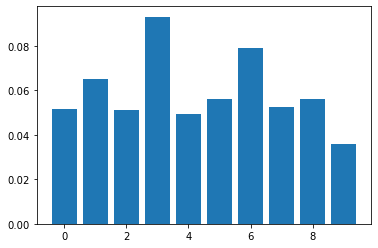

In [269]:
# permutation feature importance with knn for classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature importance scores can be used to help interpret the data, but they can also be used directly to help rank and select features that are most useful to a predictive model.

Above I have tried permutation of feature importance with knn classifier.
Reference/citation : https://machinelearningmastery.com/calculate-feature-importance-with-python/

I found this technique useful for selecting best features for a predictive model/classifier and would like to explore this further.

According to knn classifer top 5 important features for Starbucks dataset are membership_days, duration, gender, reward and mobile.

Because of time constraint I have not done further processing here. 

## Model comparison

For easy comparison, below is the quick view of the accuracies and F1-scores from the best models:

| Classifier | Accuracy | F1-score |
| :- | -: | :-: |
| RandomForest | 0.659 | 0.715 |
| GradientBoosting | 0.672 | 0.728 |
| CatBoost | 0.674 | 0.731 |



## Conclusion 

This analysis suggests that a catboost classifier has the best training data accuracy and F1-score. 

Though Random Forest is not the top scorer, classifiers differ marginally from each other. We can use feature importance output for further improvements.
"Feature importance" refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric. The analysis of the Starbucks Capstone Challenge customer offer effectiveness training data suggests that the top features based on their importance are (based on Knn classifier):

1. Membership days 
2. Duration
3. Gender 
4. Offer reward 
5. Mobile

Starbucks can use Catboost Classifier to predict whether a customer will accept a particular offer or not and then decide to whom to send out the particular offer.

### Further improvements

It may be possible to improve the performance of the classifier models by creating features that describe an offer's success rate as a function of these features. 
These additional features will provide a classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.

Also it would be interesting to explore Catboost's capabilities further.

### Link to my Blog Post on Medium

https://medium.com/@dsjoshi24/f0d1add1da10

## Additional References


#### An Implementation and Explanation of the Random Forest in Python
- https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

####  Metrics For Evaluating Machine Learning Classification Models
- https://towardsdatascience.com/metrics-for-evaluating-machine-learning-classification-models-python-example-59b905e079a5
- https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/
        
#### How to assess Random Forests classifier performance?        
- https://stackoverflow.com/questions/29148355/how-to-assess-random-forests-classifier-performance
- https://www.kaggle.com/gijick2107/titanic-a-survival-prediction-problem

#### Parameter tuning in XGBoost
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

#### Feature importance
- https://machinelearningmastery.com/calculate-feature-importance-with-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn

#### Data visualization
- https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0